```

| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |  열차 하나 
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
                            .
                            .
                            .
                            .
                            .
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |  열차 백 

```

전체 구간에 대해 유전 알고리즘을 적용시킴니다.

In [1]:
# import 및 변수정의 구간
import random
import math
import re
import operator 
from random import randint

import json

## 저장한 타임 테이블 json 파일을 이용해 기준 정보 생성
with open('time_table.json','r',encoding='utf-8') as f:
    time_table = json.load(f)
with open('port_table.json','r',encoding='utf-8') as f:
    port_table = json.load(f)


# 리스트 크기
listN = 8

# 염색체 해집단 수
N = 30

# 역 구간
Station_section = 11

# 하루에 운행하는 열차 수
One_day_train = 96

#열차의 출발시간 
Arrival_time_zone = ["05:23:00", "05:33:00", "05:41:00", "05:48:00", "05:56:00", "06:08:00", "06:16:00", "06:24:00", "06:31:00", "06:42:00", "06:46:00", "07:00:00", "07:06:30", "07:12:00", "07:24:00", "07:29:00", "07:42:00", "07:55:00", "08:09:00", "08:21:00", "08:35:00", "08:45:00", "08:55:00", "09:12:00", "09:27:00", "09:41:00", "09:47:00", "09:55:00", "10:08:00", "10:16:30", "10:23:00", "10:35:00", "10:43:00", "10:56:00", "11:12:00", "11:22:30", "11:36:00", "11:50:00", "12:00:00", "12:12:00", "12:22:00", "12:37:00", "12:53:00", "13:06:00", "13:12:00", "13:22:00", "13:32:00", "13:42:00", "13:52:00", "14:03:00", "14:12:00", "14:26:00", "14:41:00", "14:52:00", "15:05:00", "15:13:00", "15:26:00", "15:37:30", "15:52:00", "16:02:00", "16:13:00", "16:18:00", "16:33:00", "16:45:00", "16:59:00", "17:08:00", "17:17:00", "17:25:00", "17:34:00", "17:45:00", "17:52:00", "18:05:30", "18:18:00", "18:25:00", "18:38:00", "18:53:00", "19:05:00", "19:12:00", "19:25:00", "19:36:00", "19:46:00", "19:57:00", "20:12:00", "20:23:00", "20:31:00", "20:45:30", "21:00:00", "21:12:00", "21:25:00", "21:37:00", "21:53:00", "22:10:00", "22:25:00", "22:45:00", "23:00:00", "23:20:00"]

#각구간의 열차 속도
all_Train_speed= 65

#교차율
Pc = 0.7

#변이율 역수 관계
Pm = 10

#마지막 세대수 
largest_generation = 1200

#보존할 상위값
save_value = 9

choice_list = [i+1 for i in range(listN-1)]


In [2]:
#초기값
speedlist = [[[[random.choice([0,1]) for i in range(listN)]for j in range(Station_section)]for k in range(One_day_train)]for z in range(N)]


In [3]:
# 01010로 이루어진 리스트를 10진수로 디코딩하는 함수

def decoding(X, Y=0):
    """
    input   : 0100로 이루어진 리스트
    return : 10진수 정수
    """
    for i, x in enumerate(X[1:]):
        Y += x* math.pow(2, listN -i -2)
    #10나누고 소스점 1자리 표시하는데 왜 
    Y = round(Y/5, 1) 
    
    #처음 값이 0이면 음수로 return
    if X[0] == 0: return -Y
    return Y

In [4]:
decoding([0,1,1,0,0,1,1,1])

-20.6

In [5]:
#파일을 2차원 배열로 바꿔주기

def Readtxt(fname):
    """
    input  : 파일들
    return : 2차원 배열 
    """
    w = []
    with open(fname, 'r') as f :
        for line in f: #for each line in the file,
            w.append(line.split('\t'))
    return w

In [6]:
def cal_move_time(d,s): ## 거리와 시간으로 소요 시간 계산
    return (d / s) * 60 * 60

def str_to_time(t): ## 문자열 초로 변환
    return int(t[:2])*60*60+int(t[3:5])*60+int(t[6:])

def time_to_str(t): ## 초를 문자열로 변환
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return "%02d:%02d:%02d" % (h, m, s)
## 각 역의 도착 시간 계산
def cal_arr_time_list(obj):
    train_time_list = [str_to_time(obj[0])] ## 첫역 도착 시간
    for i,port in enumerate(sorted(port_table.keys())[1:]):
        d = port_table[port][0] ## 거리
        s = obj[i+1] ## 속도
        move_time = cal_move_time(d,s) ## 이동 시간
        train_time_list.append(train_time_list[i] + move_time)
    return [time_to_str(t) for t in train_time_list]
## 시간 문자열, 분 인터벌, 시간 문자열 리스트를 이용하여 해당 시간보다 인터벌 뒤(앞)의 시간 검색 하여 
def between_times(str_time,interval,times,after=False):
    int_time = str_to_time(str_time) ## 초단위로 변환
    int_times = [str_to_time(t) for t in times]
    if after:
        time_list = [t-int_time-interval*60 for t in int_times if t-int_time-interval*60 > 0]
        if time_list:
            return [t-int_time-interval*60 for t in int_times if t-int_time-interval*60 > 0][0]+interval*60
        else:
            return 0
    else:
        time_list = [int_time-t-interval*60 for t in int_times if int_time-t-interval*60 > 0]
        if time_list:
            return [int_time-t-interval*60 for t in int_times if int_time-t-interval*60 > 0][-1]+interval*60
        else:
            return 0
## 환승 유입 유출 소요 시간 검색
def cal_trans_times(obj):
    arr_time_list = cal_arr_time_list(obj) ## 각 역 도착 시간 리스트, 인덱스+1이 역의 키번호
    transin_time_list = []
    transout_time_list = []

    for port_key,arr_time in enumerate(arr_time_list):
        ## 환승 정보 체크하여 없으면 환승 시간 0
        if str(port_key+1) in time_table.keys():## 역 코드는 1부터?
            table = time_table[str(port_key+1)][0][1:] ## 환승선이 하나라고 가정하고 처리, 이후 여러개인 경우 까지 계산
            ## 각 역의 도착 시간과 타임테이블의 이동시간, 시간표를 비교하여 0보다 큰값의 첫번째 값 계산
            #print(port_key,arr_time,table,'\n\n')
            #print(table)
            if port_key == 0:
                ## 첫역은 환승 유출 고객 0
                transout_time_list.append(0)
                ## 환승 유입 고객 계산
                transin_time_list.append(between_times(arr_time,table[0],table[1:]))
            elif port_key == len(time_table)-1:
                ## 마지막 역은 환승 유입 고객 0
                transin_time_list.append(0)
                ## 환승 유출 고객 계산
                transout_time_list.append(between_times(arr_time,table[0],table[1:],after=True))
            else:
                ## 환승 유입 유출 고객 계산
                transin_time_list.append(between_times(arr_time,table[0],table[1:]))
                transout_time_list.append(between_times(arr_time,table[0],table[1:],after=True))
        else:
            transin_time_list.append(0)
            transout_time_list.append(0)
    
    train_time_list = [0]+[str_to_time(t[0])-str_to_time(t[1]) for t in zip(arr_time_list[1:],arr_time_list[:-1])]
    return train_time_list,transin_time_list,transout_time_list
## 승객수 고려한 시간 계산

## 역간 이동 시간 : ( 이전역순유입 + 환승유입 ) * 소요시간
def find_score(obj):
    move_times = cal_trans_times(obj) ## 역간 소요시간
    port_keys = sorted(port_table.keys())
    ## 승객 역간 소요 시간
    times1 = [t * (port_table[port_keys[i]][1] + port_table[port_keys[i]][3]) for i,t in enumerate(move_times[0][1:])]
    ## 환승 유입 승객 이동 및 대기 시간
    times2 = [t*p for t,p in zip(move_times[1],[port_table[k][3] for k in port_keys])][:-1]
    ## 환승 유출 승객 이동 및 대기 시간
    times3 = [t*p for t,p in zip(move_times[2],[port_table[k][4] for k in port_keys])][1:]
    
    return [sum(ts) ** 4 for ts in zip(times1,times2,times3)]







In [7]:
def ScoreFunction(X):
    """
    X에 속도 리스트를 넣어서 평가
    """
    #구간별 점수 (11개죠)
    sp = [Arrival_time_zone[X[0]]]
    
    for i, x in enumerate(X[1:]):
        sp.append(all_Train_speed - decoding(x))
    
    sp = find_score(sp)
    
    return sp


In [8]:
print(len(speedlist), len(speedlist[0]), len(speedlist[0][0]),len(speedlist[0][0][0]))

30 96 11 8


In [9]:
#하루 열차의 총합 구하기
def Make_Score_per_all(speedlist):
    #열차마다 점수                             #30개의 경쟁 100개의 열차
    Score_per_train = [[0 for i in range(One_day_train)]for j in range(N)]

    # 30개의 경쟁
    for k in range(N):
        # 100대의 열차
        for i in range(One_day_train):
            one_tranin = ScoreFunction([i]+speedlist[k][i])
            # 11개의 역
            for j in range(Station_section):
                #각 열차에 대해      += 11개의 구간 
                Score_per_train[k][i] += one_tranin[j]


    # 하루마다의 점수 
    Score_per_all = [0 for i in range(N)]

    # 30개의 경쟁            
    for i in range(N):
        # 100대의 열차
        for j in range(One_day_train):
             Score_per_all[i] += Score_per_train[i][j]
        #                   빼면 맨 앞에 숫자가 사라져서 차이가 커짐
        Score_per_all[i] -= 1000000000000000000000000000000000
        
    return Score_per_all

In [10]:
#Score_per_all = Make_Score_per_all(speedlist)
#Score_per_all

In [11]:
print(len(speedlist), len(speedlist[0]), len(speedlist[0][0]), len(speedlist[0][0][0]),"총개수 : " ,len(speedlist) * len(speedlist[0]) * len(speedlist[0][0]) * len(speedlist[0][0][0])
)


30 96 11 8 총개수 :  253440


In [12]:
def Score_assessment_group(Score_per_all):
    # 적합도 비율 찾기
    speedlist_evaluation = [[Score_per_all[i], 0, i] for i in range(N)]

    Sum_of_fitness = 0
    for i in range(N): 
        Sum_of_fitness += Score_per_all[i]
    for i in range(N):
        if i == 0:
            speedlist_evaluation[i][1] = speedlist_evaluation[i][0]/Sum_of_fitness
        else:
            speedlist_evaluation[i][1] = speedlist_evaluation[i-1][1]  + speedlist_evaluation[i][0]/Sum_of_fitness
    
    return speedlist_evaluation


In [13]:
def roulettes(Group_assessment_value):
    roulette = random.random()
    for i in range(N):
        if i == 0:
            if 0 < roulette < Group_assessment_value[i][1]:
                break
        if Group_assessment_value[i-1][1] < roulette < Group_assessment_value[i][1]:
            break
    return i

In [14]:
#부모 변경
def Change_parent(speedlist, Selected_list_in_roulette):
    W = [[[0 for j in range(Station_section)]for k in range(One_day_train)]for z in range(N)]
    # 교차함수 및 변이함수 (자식만들기)
    for i in range(int(N/2)):
        for j in range(One_day_train):
            for k in range(Station_section):
                #교차
                selection = random.random()
                ###############################################################
                rand = random.choice(choice_list) # 0~ 이구간, 이구간 ~ 끝 교차 , 이구간 = 1~리스트 크기 -1 
                if selection < Pc:
                    # W(교차된 자식) = Selected_list_in_roulette(선택된 리스트에서) rand구간으로 나눈 값
                    W[i*2][j][k]     = speedlist[Selected_list_in_roulette[i*2]][j][k][0:rand]         + speedlist[Selected_list_in_roulette[i*2+1]][j][k][rand:]
                    W[i*2+1][j][k] = speedlist[Selected_list_in_roulette[i*2+1]][j][k][0:rand] + speedlist[Selected_list_in_roulette[i*2]][j][k][rand:]
                else:
                    W[i*2][j][k]     = speedlist[Selected_list_in_roulette[i*2]][j][k]
                    W[i*2+1][j][k] = speedlist[Selected_list_in_roulette[i*2+1]][j][k]
                #변의
                for z in range(2):
                    # Pm * 100 분의 1의 확률 
                    if randint(0, 100 * Pm) == 0:
                        #selection 부분을 변의 1 -> 0  0 -> 1
                        if W[i*2+z][j][k][rand] == 0:
                            W[i*2+z][j][k][rand] = 1
                        else:
                            W[i*2+z][j][k][rand] = 0
    return W

In [15]:
#세대 반복
def Evolution(speedlist, num_generation):
    All_New_Score_per_all = []
    while 1: 
        if num_generation >= largest_generation:
            break
        #전체 값으로 해서 
        Score_per_all = Make_Score_per_all(speedlist)

        #평가한 값 
        Group_assessment_value = Score_assessment_group(Score_per_all)

        #                                         정렬   점수값이 높은 순으로
        sortand_Group_assessmend = sorted(Group_assessment_value, key=operator.itemgetter(0),reverse=True)
        #상위 save_value 개값        
        save_assessmend_value = sortand_Group_assessmend[0:save_value]
        # Score_per_all에서 몇번 배열이 상위 5개인지만 
        # 리스트 해쉬값만
        save_assessmend_num = [save_assessmend_value[i][2] for i in range(save_value)]


        Selected_list_in_roulette = []

        #룰렛에 선택된 리스트들 마지막 5개는 상위5개만 
        for i in range(N-5):
            Selected_list_in_roulette.append(roulettes(Group_assessment_value))

        Selected_list_in_roulette += save_assessmend_num
        
        #
        #Selected_list_in_roulette = random.shuffle(Selected_list_in_roulette)
        # ------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        New_list = Change_parent(speedlist, Selected_list_in_roulette)
        
        New_Score_per_all = Make_Score_per_all(New_list)
        
        print("-" * 15)    
        print(num_generation,"번째를 합니다.")
        print("-" * 15)
        for i, nl in enumerate(New_Score_per_all):
            print(i, nl)
        All_New_Score_per_all.append(New_Score_per_all)
        speedlist = New_list
        num_generation += 1

    return New_list, All_New_Score_per_all

In [16]:
test_list = []
plt_score_per =[]
test_list,plt_score  = Evolution(speedlist, 0)

---------------
0 번째를 합니다.
---------------
0 415088145144621255319356408324986
1 291410533124274183913889909577792
2 331635761550231232655641821580631
3 269345260740737625948771352799151
4 424299276269480407054311337557276
5 200065918224241396640818506178077
6 312354756232194858459888461469772
7 365142170149491734101590039415791
8 323174094887369338186175519183916
9 227961998075379959440398007643822
10 242657867452613959719327186278133
11 312935289538745506354410563069100
12 289883534709672528159786105678372
13 359704360962486780446991607977336
14 257608545283524205661779012527363
15 252605358160502987118902370251934
16 248355815090183783492850230333748
17 362118201065376400720187265336879
18 281264305627990437362091380799274
19 338723781511753944457020513984406
20 282432488918342506194356373410176
21 438843920167141184429034392760060
22 370456457799225380555174711795850
23 333367469573158134224644537035520
24 411520163152440286392649304904451
25 411416634994078520886813998683426
26 36

4 472679407335645290570889708832379
5 426280315903620481929251276365235
6 453244411345844743314518253286675
7 394801505472715571915462812079928
8 514785028805555514589413552713563
9 511946966480441010806125641142438
10 444502754448790639061247126422483
11 493631369321849215569791188659964
12 403719605770858504389080689610476
13 419881802719211122501707725994366
14 419303372852223517814713813394687
15 464174699484578115988745287710584
16 409950516314190542411578708988975
17 479551163068080119068931983998252
18 360579621554019568671634104546510
19 362907789334538653321668344550763
20 457741715219456696537891864555765
21 447932548479197409684370212668975
22 421719155608561866600666816682212
23 479929420494496315320960442764771
24 495979346996099022857010888513424
25 542908287687807019778144032975011
26 490666128197805776931173965506709
27 511042107429844865894727784109945
28 469743485597975804924926108855638
29 460572959215388521671081359637489
---------------
9 번째를 합니다.
---------------
0

2 475881486562458793087765695830074
3 475881486562458793087765695830074
4 495864748290202185351246853738512
5 502765616875070275462035220406686
6 470913274424998075520460260248556
7 481363237667800100259283074986610
8 495124960646134416692479815548456
9 566183207696719401508915555422017
10 467720868581226313383951718418726
11 383945103252589780617263655493051
12 498527557469471434333268887111465
13 453644115182092747998801113791602
14 484871152256045333209228450085120
15 472377664892977914161653505843527
16 519520869968145822950895372189071
17 503266152165751979438175631632949
18 528700888806179816106044759130094
19 443022379987958618528803142818854
20 384955015134696494760573619301138
21 449924619155740586393033178489282
22 490225149044950487647529830526336
23 490048332573748523319844963534899
24 501356045340029287257365831679355
25 548827913592162316662692123112866
26 537807659302904130068923272829911
27 471158468930599362532069870489666
28 506903924182510194075448433951244
29 556612

2 560331259438817419033243383889408
3 518935917494331105531108437856730
4 496538983300416935129909889331057
5 510332099182047471836584807767531
6 515139163081600486073890165680336
7 561897940086898355791277281458403
8 517928404363124506205155758831114
9 487999262198365393102156411620660
10 529512806645506740588336504587786
11 582325284820382095013961967409895
12 547274210021233395651054746069365
13 504515071782221441111015567084753
14 517000347376908055921845045445974
15 481474135510976202502939855091187
16 527377565401275006891188981513255
17 509445008674329022756934817686627
18 539443379650931079771394227292800
19 526366681650870260842015142810940
20 499388369973090267588794363625608
21 482964305820855208934648437746122
22 535703831282192547702381522306815
23 526684534557033718724812313261080
24 536717336959243180499114274362434
25 593681985107004970169319310817976
26 611381354018314861038215948195416
27 554980271908265267469436822223904
28 550144401684479329042947517040344
29 558227

2 533276789380020286678839091312102
3 564605121596614776954777826497074
4 580223143278401915924073460014853
5 566447756081722366351200000025331
6 579032035580716665615253374776187
7 544214187585146741273199372995653
8 576966145491258101078213297610504
9 510477654676631776336910622338127
10 557362338161152998109901090423482
11 555240243620860063121168260607851
12 537228290596502327556939029017109
13 571125595268588571705287723598572
14 557918650402092725790130421544553
15 553747772048931445607792801351036
16 538849663389268608678668402439592
17 538707168520467050545536174048519
18 563946727719763225251143960255434
19 558667984416695249978716287277995
20 568608275552223560162982039603923
21 550571423348346716612786712958868
22 553132674981697283214816521909977
23 602097390842988233040524952428540
24 613768626011203891763135197338861
25 593216797068733126160547673993547
26 605705049469824859305154363419723
27 599197161610108362322661169335276
28 573024419017994000761830259999395
29 604686

1 595012495111974242183068528938726
2 563370384693931484497987483164827
3 625176889100421197935531250521545
4 588422253728440624704292991395587
5 596955757672423733950866644955112
6 567948106202090525947896730444612
7 614813211842070567826165283422206
8 641632481256288325854139167911735
9 550497170259490659801305579498951
10 600645678588248236528352849476499
11 599856650552042359838527453308837
12 584679688991255040361842450325729
13 608525567495572522209727349011182
14 603083376173989568758598743360912
15 665651361584073492883936561540123
16 544927327111650406186120898842464
17 582692220148541816555801639847936
18 578840569894623238910589844785091
19 557878203752088641836243293793884
20 595908421946375316375806510831413
21 586115156494744503324345458208702
22 599424033349979600136151754400125
23 625768995388763276584111422922451
24 548617205553767120518220935441554
25 654836437151452732228799868144861
26 641482719660917406710514513389840
27 613858940197379241328874601887275
28 6495273

2 654150911529153809100628231342015
3 605635493965238200936764159072157
4 606402446963566772348959651234618
5 613647994616568147534327370406282
6 677974078546745096166382327146876
7 651048612743374352261503762746751
8 605529987998026087178210734291883
9 593920620045783596687049639422660
10 648369590147226239411553816505593
11 661439495567466949541890702689607
12 641174075894101581608360837163289
13 633926431676335417519810584708054
14 649992923457393181874532471978358
15 647183441064802355718168842273832
16 657737275128733457332037634058422
17 624408489606726674345600678438010
18 640825023321426774363203599433448
19 631110894836996681143816322955043
20 635204253633153620296598542863588
21 654062319443210659094329891885334
22 628297462858503212106636661782186
23 644633317253081413885241707579775
24 654016214352368740684235222212692
25 641630006737798066047226544031154
26 681027764674890484369747804059800
27 644789656086352614467165807472788
28 640339862795769672654321099566003
29 641859

3 678038144404108067720778034986633
4 677482265842278767249423534988357
5 668251383519245172488670595082471
6 663039974059363694217705773519539
7 662130136349782655675958317362411
8 674164868213299872832290857235211
9 680476977615112253339496820340277
10 678269326808811026345251657719345
11 666049248022605557240262426071566
12 663575617508595892910298762330201
13 686583931354021934184174035486231
14 667296311429251656840388086053688
15 664637834919825045701108194696991
16 666568116362167463739166224397492
17 616344903895940119557691920710357
18 627126694532808623267494175484093
19 620731758322953749809290056537182
20 668202201498305361117594683666839
21 679712731218203319140810868285827
22 680979848868841744263466858491375
23 674028994602901487328370418491349
24 679039270356946801891281741232386
25 657725976661527370142984612789315
26 695110734010403983104776769023954
27 686416359581030760420810673228415
28 694384809838577867224805892455757
29 670561880467700090196368656967321
--------

2 688759995205904746257188396294636
3 687818614733896245582359903033770
4 720789426819181177752742198148984
5 663744781705031030425390549648912
6 693529820922329273080061384995785
7 713705414305182985663002619448528
8 693836506741918752700145112920292
9 706443296140026074655563042195114
10 677371786911159076235929857095818
11 695381295360012852445187732544336
12 702758637266086748368060286317349
13 678963120880391724032832993322178
14 699127528657042677378695946885466
15 684457961740910914467380544372998
16 715507687817216889875736036564151
17 686652908300384990184549327978243
18 703324640854660647605541299785032
19 684976302905213494537044633152290
20 686642277527388226711285499241072
21 700895001586167244032721283801124
22 684724507668825145858750089821884
23 682267554446956506646249946840059
24 698973669413398126056474882812418
25 708648645828626351223713031332741
26 702477187557368134265102315846065
27 723093084389175962221614249228098
28 717250454299373621525838293356764
29 700496

3 718522320989033043513028165557551
4 726925073593567504491236911543391
5 699185717773264387052079074380774
6 691349714561087793311927321499295
7 711983431038689054325652780225380
8 693330339481142599166919961295102
9 705238967426081875539018840545834
10 709388935441048948560800069408099
11 702306046220817873034081337099160
12 714178197626129243008137304898423
13 719623150041258801603702728004756
14 707140508228360557288253893660229
15 703191012771119175406075593258549
16 722750665784298068545108401359980
17 703018868819159673953383981595570
18 712874760996720683494125296529351
19 711850328849803188596950627034391
20 710386737234785968858496997177306
21 709821831340330250951311295074323
22 691985889927277213763029147678333
23 714081892849012859866444815525678
24 707852957344352480356016882178896
25 723278207277458397369083192430496
26 728526675322444176305753527149024
27 730011031743022875571818209665203
28 708701972533424592233407546435127
29 725070072790744461957172703081449
--------

2 735962727638392630022779577044090
3 737234486732212568600046253665719
4 693181340972780650944286897737107
5 727942472844757058423317144371626
6 727805151382741151353779485186149
7 733430364206731380737112966748951
8 730814097269691391243259857694511
9 725235403523561905898893985916220
10 728530808120906153285881461758761
11 730628861897428788818429302595799
12 706292831561028580079920124021632
13 675271381127273152235519806977004
14 713978456122242374503841349034448
15 727751105137637210767553179776320
16 710036697352340904522801183000443
17 760168455435789738470874737026553
18 720978164518520083063214353859419
19 717607975556724717433033804570759
20 734736574195959892577100325546868
21 731000196260994329146859223989189
22 717079004400050823816469856447637
23 729305566765030985008524815058704
24 739802040215716094977281386694768
25 753842911334580460752704438240855
26 755044689108368492031638301033745
27 738112224471477774114018490752487
28 749077593212846477986808611272331
29 743317

2 749527197341181787147336599712550
3 760184301358765443836173526004929
4 770365755672084976824341837664764
5 771458787014941624761625685110474
6 762667345919411339385419866515538
7 736580032544878755985661119699274
8 756060855189928923434737004660890
9 765313914565082541753387580955665
10 776841060777250666639068767627578
11 722386145238890959418610159683416
12 744029774261436670706161976808598
13 729211297921713846920879997582368
14 738381781535975317852378362539016
15 770400178584947960946467569693226
16 728344609061956578961565365561942
17 751077163747756051520373666588967
18 756578270596085148819997832218072
19 706708589035094722833666979771592
20 749985395896206197234476006218247
21 729137914831746604810053470020019
22 737181348684980651910616764533138
23 703069569514028168530716581894292
24 755843378925621516198503649241234
25 774438155655554800992170475861929
26 779007385322642960270204545790378
27 757535624544570799451826808350524
28 770243486473968229533824733276000
29 753521

4 765941854044586388910732298109418
5 746404315517006283784345713908426
6 744951006955438038396344385032422
7 781587214236523968784079822070626
8 765956716643218716218721605724881
9 762457348088443010700489052736087
10 780087740893087224412596991440036
11 747594612562701273862287809613765
12 767926478032636920765293862330730
13 744345535278719893420793469402573
14 716177686021083691478945679522027
15 774549332428128049379544325147770
16 756494386124107135646998629644058
17 757933375712384331609012333513152
18 772216877388208160181200334376651
19 785488272969865719580917702407686
20 781870840825133863916330775914382
21 753632995913964574359393209567978
22 756645741700530297806321443536148
23 771969178831907653074111533895363
24 774310926930898530073837765773594
25 784387242723697885658561859953434
26 785759709559614709501398072013025
27 788219553046697530683548371363730
28 786999469704136643996267257054549
29 784519846125903440350783220337909
---------------
97 번째를 합니다.
---------------


3 792209429988658276682353247569020
4 779474069861306050558078540626906
5 780618247541490141220316263570826
6 785091960117721266385486323734076
7 769501063906022650050654092119941
8 793174975559324815866345095960386
9 791861880659199163050169125249305
10 790419017050969242411614908768671
11 799675510498153704956452024959026
12 788138381361581552104430755399275
13 783440988717705429291048138454685
14 787521305651148287029338379342027
15 790641963977343894873881583980784
16 780802742934500332409135720561667
17 784508189401054948524488896073904
18 789319513835465582747613656357378
19 770158094260247453300105965681209
20 778299660241727121645460416469626
21 788898823586527463412525231500490
22 785595017555525282898224754511860
23 777666510338669026892995926766399
24 767646309510794788719222447088872
25 795240387831644176180950267454630
26 803171216260505817011034936042387
27 796291059509126738330223851448637
28 802004738332686645309625498500833
29 784894522542842316778758093272646
--------

6 817514475260550444783827867454066
7 800399080824463485367234557289942
8 802416646620560324716717544352286
9 804999131886652483960256974125548
10 804445009601069147845171559133228
11 818821748410106244467323556551793
12 800761328546769880187371757423639
13 799494252737615013178993901700662
14 804232899414769531849727692110191
15 793444081040539838606326829152336
16 802208621369927550120424708449573
17 794869927296986809056200351190656
18 795462347306355963116906382747062
19 798073766417755641278163790270880
20 798816983542052922651531260077688
21 791380299011004454317948146849330
22 802484055391270508878967360492435
23 794185648219921679544288698987545
24 804596544093773193613235809086822
25 820197966218645569664934930803873
26 793688643035961058145870380148542
27 803780064294165629993915981351760
28 806702817324459175047090991426116
29 804520133539112449813652648156234
---------------
113 번째를 합니다.
---------------
0 807840068052381530360681645902657
1 797231742224038941355202176158039

3 817878826001108538960640823812239
4 806394009399367710854611605545222
5 807928189908315322487459366849161
6 819035810262581296312801854776203
7 805851696478008155679188186065606
8 820548809092255925064304242327619
9 816830612196891380012134783273314
10 809712535799254915445498064965151
11 824064013459830822084322492204567
12 807570519636499881026084300834189
13 808749685406169951821989026471889
14 802774449321435035212597820025868
15 805689667493381254105285553089315
16 818554300122812312962629278701387
17 820042702545157832208620123602551
18 800968756221641935854244781954435
19 827114318238845134117058772693039
20 810129322675376268307688897238523
21 814795326948866673577024552881537
22 782621095898239292917513173362236
23 819363681428867430636397052047886
24 837123780310794326315869268910257
25 817137287724465417119691741228260
26 825729700190973241316744489500280
27 820955471079177130655554771472889
28 821244075600105041163726575888410
29 824973152697137712688337502369619
--------

3 813284059918545368512726204672434
4 816280165214035751043758566366420
5 824498091955237760011717392483180
6 805125805050372421050351060844307
7 813717461889473219669900802906874
8 819500580303098311886607291591102
9 829221127808193823979103022755979
10 826440402665188403246483128070348
11 845193444881789212907611807089365
12 839987795420940515942605588310988
13 840132526267779139661410540500998
14 825183688614812017949336928367472
15 827625503011648190972649439934952
16 835505328023925035745971621954935
17 845140746670250670550186309306892
18 831932685351267150998712579221729
19 819334378303057636542077614482052
20 815164548186629181320690794003362
21 814446630135203797015425952953676
22 857775947662894026469087027158916
23 828156895843858889283231584642751
24 834504328636457448586318844180075
25 844038641708834628456552965490870
26 841825428249900740661132283827087
27 834830262722530453201002339764095
28 839201034364964249817111216887695
29 819327023279686279833123891027150
--------

3 837551220975056270577299357300792
4 835989846939886146519022920903256
5 835989846939886146519022920903256
6 836846217219162466450347979641366
7 842943552677910698974451242228372
8 844086231837093514186120142585022
9 864136694054224103929055551369480
10 829202143324934577470722147980938
11 840989216184988201816375049030452
12 867124575046600966678266347521686
13 867911625576140867572179793704112
14 849201180497687239769268394879907
15 843198860082797402433259187548027
16 846169147111989446188091135493341
17 844798200619494866022781101558847
18 825045415935140680530619312108099
19 823935533499544137601636481112217
20 802266157552039996658191299892801
21 868287370677838003669828516720866
22 823058846642338517679312515032055
23 840049501237835092866953312505026
24 852353703950048546775373343082954
25 869144863742138979576381248748996
26 870867094935902093479437607324881
27 863194148023980755881147916296063
28 843468770812067673360275817634858
29 868172115262543833100537889903875
--------

3 874980322643069702927345391097120
4 874642804915552182513761667017383
5 853718973540192313542815750750320
6 877711158210929929822075508742170
7 864915253490710325202693011369272
8 863328762315828298987201516804585
9 878151486979253688145488619391065
10 877086707395243612817648547844064
11 876457435851860159318824964747852
12 861531418558866720345496693097865
13 861450404067608551095272708884587
14 878412208224256948081591902212837
15 871199540032273148663232653736672
16 864003239052568386544310030220487
17 865642457443283258532335198505823
18 871893750002035318541392368060586
19 874778581716830847349849032650217
20 870657843429413593092728339520451
21 876505737506289460322697485166019
22 870772975401615708863720094058453
23 857722314951325828990159144255748
24 847544279427370666842129651069340
25 872730128882040674693253755114844
26 880199290333264582611646934668237
27 877201952733399673199193799599994
28 878107659874529668844731737826837
29 878761940730547137196106164583106
--------

3 878863504291302619410821110090810
4 879583773470813857281394966690060
5 874977471995285057073790367152705
6 879496560767553563498303538392621
7 884533463818021620033188498147245
8 884030771381294003548629297802563
9 876748408242042243161384479293089
10 882113646968087107587017416016280
11 885241631953333452596095444488823
12 884877660113861780729670858615839
13 887560584138470264821068805286131
14 884684315449759355678836374261401
15 880284641667209558730419054814057
16 884795482054370486100913628529552
17 863144006401255015079460881380732
18 880456318450113465252923516151336
19 874372124283488234668906457668892
20 886666582905148847321749845668778
21 856819419473419619806997737888049
22 879018596480895177726152834786418
23 896350928203828628538707735944582
24 877986056921382177068856933101259
25 882665645312427277972345518529135
26 888244638491381593157671636298256
27 886376766003315635673656308036359
28 884978553051274709717662623441240
29 885840223740279502653508567881874
--------

2 890839229106030278656402684480103
3 870595297859682608521715463565699
4 901391985459363739138352649344933
5 886274668502164813333107541896543
6 902260061076230489314785291030760
7 892493589352979554957229175718299
8 899505645986282429456193788499942
9 900886007088852890657058729284409
10 891040242274089823789026140473342
11 892443669025908627900671662534007
12 897705272198309638845108383698691
13 899545439664550606808136693389417
14 889752559499921783305755930413685
15 898221594049926373628780473322000
16 902621413886724510256335596531791
17 900981401082214013039949392040632
18 888186427830181913560657049680601
19 890011675391025769234476827769651
20 888807438008909395591089146436898
21 892298490526524182523792571726365
22 900231563861841920362163535387495
23 891410142690259762761466185486458
24 887165761246445004676988001762587
25 898898370598389624868100591445888
26 901762179943352532852581077376196
27 902957679552658993824389758433095
28 900434395503771446165874624032071
29 900759

3 875906070264336318266454836128668
4 895819902731618524006159326787103
5 902052768775202220739743861032655
6 894722712250317956280093051690301
7 901068001278090032146134998223992
8 896023813810837544928519703035483
9 877352502294942658337492526560627
10 891386067700524146841300258992017
11 899532089350956668512192902890663
12 886019415542085171295724535505772
13 879085030867067937936641437257768
14 905356633566504779973874333881289
15 892494726430256455894907286591099
16 891910788017064514456572001162113
17 891912571333937765521718730107713
18 896612337500357181940370716701253
19 899781983770108207195335492986289
20 897609398456318393852508369889430
21 897609398456318393852508369889430
22 875953153675687541956845290730130
23 893707227828216771367907374784181
24 881308233879621028579084736858146
25 912486619621316877346321446187868
26 905964550203613655129659638404594
27 904429437007391806514485402587365
28 906602425007504212592322896774216
29 903583935380504512383982324596817
--------

3 910106636950470916618280671458741
4 904778893572009272427713433558081
5 907539575647966767855696983139197
6 921685908121879741080093925918983
7 874971946012866070811091374879805
8 895991347238025414340067700572475
9 912422863441597045477159270180010
10 904819859241047669180370306227192
11 901564407046335036165000857415274
12 926330810092697977906013888282258
13 907709379416419775497913802272453
14 886830848279482526211113386810140
15 917301446114722970668115576214445
16 894903285728494312962688764180530
17 890488786708262372091511560617506
18 914387306627653745500068036484908
19 900427027486332858259490233651409
20 904367206579939149598076150637123
21 919430919374286557418430808254573
22 892391190656843204476970690578239
23 914794302169669034254998225113019
24 900848437210840874690169316987276
25 924403297985564005173824890360077
26 927057621190747321179369550197610
27 919934752291283065652333988482172
28 923742411743779479486819637600974
29 921562621023419603470569140010491
--------

2 924075408643448724152506893860598
3 927124327210561922876898005241829
4 908674921683824442737464223763417
5 923129543994233717973502590010902
6 909969870839670899006481181805834
7 925114579375898461151566166926211
8 924779312363369271596551422998277
9 916161121472324719923551100247967
10 901054033015568591998953794636310
11 912533866900028658697650211064269
12 921305887650222519691539134378142
13 921305887650222519691539134378142
14 916385098490031265356167660921153
15 908477501716009583406537115393898
16 886641807531971480152802873849633
17 922439387514348880644104142826111
18 929188004137346007635003582034830
19 924300130918104935520279706578062
20 922365963010291269366281578828903
21 911143244748827161260093079509603
22 927358811180934359761128383857849
23 900952156058621594110080379720981
24 920055842062742477838019196883308
25 930938109660032065330512595815198
26 929699708784894856137038519134973
27 930004899048795268075500127022941
28 929455061256918951717980475930494
29 928446

4 933851155540334971062924206887688
5 930307036367338780738736222699466
6 925272678525954690731366303308148
7 910356056733647437187403785036553
8 930350927599740462618765776481315
9 916461085260720492639945860361913
10 935545010540021433303625263090975
11 928049050295255913191465574765517
12 914037075880660820186086450481587
13 914643181239089207740765245590173
14 923557958237998710772244727412107
15 936070954515449142644937046429862
16 930953072015511916413008337691637
17 930609599932726227242990761425715
18 916672881772129127444319000807133
19 928372946309444201226277488386913
20 937701995035180248753393697800661
21 933437455011043524964220587765271
22 926691965796146658541113901444909
23 926698641494242443055727246290157
24 934294125432275375902822811995976
25 933804814775333810726084442618370
26 922310383066526110483924978684347
27 937555059016120922095017889934219
28 935260714708604247187364101345473
29 930481995130436230753683201927551
---------------
193 번째를 합니다.
---------------

2 938475787596548770136229505313707
3 923139198098757612778398154922969
4 940910620751224452640767175546491
5 940473537538890255339826159107575
6 939610399668739898192376100417090
7 939942131322555883514704892440974
8 936659877675959729485028854195647
9 940581757321364255734109359398671
10 936914901867022718680209029137564
11 936100628385222496308663861539396
12 949001047356384873695448362146945
13 939193524905636441185037335916978
14 942236063044185472894421777938387
15 942219002910237462854436747827794
16 932685104640563809038464114916592
17 921137142987130227793429196720620
18 929079814388349533367047742063803
19 915143917891790232577603821003670
20 934717535998750364284080500398636
21 940667842913258906556395280735994
22 927300793537854891787122829825077
23 923348904549759491640381040885795
24 940570490296866242804308587149327
25 934466850522711880377457843373198
26 943014335910659635816643311669516
27 943573928954057173498247679751353
28 942452421135944799563454427877132
29 942844

3 949546183625174226958646880539268
4 923863645870153560277704020883056
5 934959155483238275154897860504096
6 940332499543221619887385929397838
7 939991283712906117530106243312328
8 907711054661262644985650326166134
9 940590671969522511719728369474624
10 936651344794065631383892404135440
11 925181419947677916300595370627318
12 946696653220390500694600474655258
13 946313432490469275679069337975347
14 951969704360112744348914686661824
15 951905748923747860991209664803423
16 953469646524828782588839565805644
17 947904829136666184472399527465713
18 931692212088197484917761671118867
19 951706424486705106078638776273702
20 931267150880584445374306481278917
21 932301025120018207251161963402569
22 935644922438011331981717250098866
23 929834732668033112899551269799037
24 931940471422800683220287533499003
25 950136649231591436282793386748711
26 947036600529411006263886589826744
27 951182321832096251138441650971310
28 950321375574759254710147805769012
29 949714769795426156062972479651259
--------

3 944802303381102607964024460053203
4 946782452216134796326929946802254
5 955155138940857307196354027644287
6 955000862466676167768674880003331
7 955368596900645873319312993059670
8 932305170415587139260226816508181
9 952329112132087154533328360841730
10 945064047641893120086159012059346
11 930876148523581977661651844266955
12 951092436219999169611605157842168
13 938076731377839233931792875616463
14 941722411104590435669130299398818
15 954436781423978820239450786312617
16 955226512986931627070998197258809
17 932897995854495112941897051824646
18 945403941881876184489436131150378
19 953611447885402480355591135033073
20 937292365358365029828840249937221
21 943444160889315418626050107840917
22 942079001690489969440732151233889
23 943723638436448148425531173037001
24 956237356598694735281670497550056
25 956186660732904238530562216441542
26 955204326587157704612690707171095
27 957516867000518117529696745582929
28 955758809871307927381285753272926
29 954781094340016637893011099052861
--------

4 951796832865682465729905911004877
5 944817706636830619535374021022011
6 950868587213806453529315921029901
7 949590105238263026350540498902823
8 928877486898653094461365511028964
9 953668120272219907192504154242904
10 962947537443125905294912728667027
11 957090433448944694949537014622047
12 943280495379779293855154657164521
13 959829503808317778608903859685659
14 953153071758755542819381863794211
15 953139687468243901465718446144035
16 957567869139875418493940555669497
17 952637994760535212436386419920840
18 959243914559168548315783372187706
19 953101386538104221577268752887604
20 958461146074298275360876214698945
21 950266669526325864205211576655788
22 956487141776344617080187702251760
23 957936237407476768749073518728272
24 953900627292566579413872723491752
25 960771094917131032487333366347587
26 954895141320205337368084537984760
27 957007702114856685983016411450427
28 956846191054508068491414855727853
29 954666667556987448296976058135969
---------------
225 번째를 합니다.
---------------

3 956202608799157107248864792683158
4 949492087482625326555652753403583
5 930202153021366480011239430449664
6 964427290990238266580646318847515
7 960702571269543086813133771326223
8 959971366379888984410597479290671
9 960517904654945303171123647345144
10 959116633794266398489435863013754
11 951454656797570882819177544767344
12 953067983273904982019531898796494
13 964186123673917804341107147607262
14 959881337612207122328578294925232
15 963233946977783719722244569138406
16 947546861760407436554025975301259
17 958190679454560111644767335217108
18 957813772190204837055434227659989
19 953349347579053543796672187876768
20 965082764893130071743428770860999
21 958300377396355416760853746141237
22 949864162260600737231934371832189
23 954633428220240160040149077095189
24 961605001908396803897470953686902
25 956103975956388002231434361576355
26 964107973610246208714267181700919
27 964208713153115924694016415084546
28 964364027858599468199170930559612
29 958662519750695934529453690043282
--------

4 967020260923359450623087959720251
5 943269833812283467556042828018894
6 943364196535360494845611938231818
7 959901580547517645797461307399184
8 955404361828188919049512640653430
9 946109359057019379381362298645596
10 966367876892643377811853790894951
11 956090431722826756860538442148415
12 933200386783426701002533872793220
13 961301895632043395484052173401112
14 944283937438363692991516662587938
15 922039573298225155362679598040081
16 957403597308525761196646010482435
17 949605321784410366121167867551956
18 957204582599729628774089103311642
19 951316726645113462348563480566604
20 957292808679833284664421915006834
21 961947633048123356997649417867693
22 951065268314444331557621331660539
23 953278485259692406549416920287929
24 959455209513370040217813952335295
25 965757259315124271210275642204021
26 968596017937772515376295851850232
27 953551824211136231276502127687436
28 964948966196325945414841132250705
29 962469153732778544169048879864405
---------------
241 번째를 합니다.
---------------

4 963944853037282403289304895646720
5 965079334246670188462059434181505
6 968983483984725130017582338722891
7 976631531383810105873934494213982
8 964615915271471932109035746409839
9 963374973305770855411726865047319
10 932572437792027288972193784450732
11 981370480041308883623019263419978
12 966689206336374802675419920549621
13 976071825239947558584798697379025
14 983118837279465561131993163514011
15 957558673907189347651285507383142
16 964349290813687658175373068279812
17 936341346397921831027639369600185
18 986794447594509902626706715698262
19 965132679895275449578877711561866
20 977910210249548881920498245054055
21 977543420998971355309875030000259
22 945694500091706845405807973423867
23 980866000913978570817452284123163
24 988644658349905896466355056340183
25 978122658862397482503817981945628
26 972370331249503946914530162160441
27 981190294476253280826016630276898
28 965606258473279786187629634530683
29 977883262350544480158445543639910
---------------
249 번째를 합니다.
---------------

3 971110814216447685840432555321798
4 968682512234191146701632085984411
5 981024027298051507850746700943481
6 969230533651813784665300046694890
7 991939875748759109042844085915372
8 981233382069522754656352604898031
9 993714627546356096591963046105210
10 987134606730639738963596653139947
11 969044412928865438750706310351217
12 981538428338062346712183299984884
13 957905623877867155531015845880687
14 964368017669714125285351592105917
15 985110439509633574755366521615062
16 986666381087597305961315333751901
17 971965084129394483352286597178936
18 984716604685830882759564629398249
19 974046792543689009823312914674897
20 961474272922929925535400996420238
21 979482534009435585522021585320411
22 980063150672176486789136267617313
23 962666407983104093110062113282372
24 975684871606812981148470824376232
25 994517841202483664859655752148006
26 995484709573312366346365716969831
27 987032793669825719386650241751247
28 991870149271967581438118093333974
29 989333635427253690842009520503548
--------

2 971186784498416375485188266307387
3 1009221100287622759620273015624175
4 994157401321867892538978677552239
5 974203011491816717126390723393394
6 978313282353826082995855654973873
7 994803257605829732471802144380828
8 987354612834348902922418100029241
9 988197078801177933307763691729517
10 990986869936834440642380794883287
11 977378992079918898508281934388217
12 995341633916141865512480792905502
13 989785397048733133150693257544648
14 989680889748810252896044051719165
15 993525701245203462019446038984184
16 992588211230574109722184822873125
17 983836846110093669384644520279628
18 984581363964962482960200384632563
19 984559270044220182804621012368625
20 990409827452173698209398656855168
21 993754482756920449793591379003847
22 994152898196333169091369539201842
23 973382992748467290855127749491885
24 991555070220355640421948784762347
25 988450849711743115509788863442925
26 995746431867066622803719290428684
27 994895325131753079166326989179753
28 1000623627805449006880037137438588
29 9908

3 995016995565623284020936930485777
4 993224943695676394480955600259457
5 990977097526691698566624957249280
6 1001247932273281266926521375317851
7 974717759291591360458120189099004
8 991953101826712679928496793265914
9 990868897290425798022425872411231
10 991303670210825479906618353910013
11 985533446189947308038118406778015
12 986988672186801888943640794092773
13 993019620543066032387985235814853
14 971669224205883380816319125693746
15 1002145944213048167660749725358631
16 976818894544777487260120773429722
17 982632721196302541126419114963997
18 998171944154231679310794198936428
19 945210150385392831839455688434413
20 952934597007284642508958310026993
21 989258299431913832652417960493839
22 992063506130242154371863247649277
23 994910226368242620921080781421515
24 963425979091750630676028668683063
25 1010217963813552493773923924939416
26 1008905312456588970588449403039057
27 1005071554738298976216003934052044
28 1003839843824896687522438920795663
29 995385916100076414892557785797703
--

4 1008033188796239771120912121471065
5 1007236529258537795641086357961568
6 989239779729485648832538654925798
7 1005580009377893601416163635788690
8 1010910171440317363907675652184663
9 1004845923842722422312208676613314
10 1000689101641840377969012787106536
11 1003178372508334895494879376106724
12 984372047808427286664866604419910
13 1009037102008650358995219151003017
14 981795540238859352291464882470513
15 984027250521684236680990171406894
16 1007320193024517141962891166037922
17 1003021826548304851334019813704840
18 1008278840653133435828876210922469
19 1002470128518933775804357006386737
20 986214948608166769894108602596819
21 986321997191852208395344041668018
22 987690813259808625923357133941383
23 1000861515175106662862646980008157
24 976958928263722052822251724733970
25 989000167960314165826876701328725
26 1016885237047909409870392869932985
27 1017162288447856204712927535243695
28 1006612673048710916801964727817358
29 1019126881098440110466630954273287
---------------
281 번째를 합니다

2 1008841569653289829170344032919402
3 1007063901444206987985913796086120
4 1000143186469359339695726968196093
5 996299823928351853373614834961810
6 1004139699444754119641803765530405
7 1015916023319078985310909634609099
8 1014069965290947892267731612339586
9 994334108729630652261456355631050
10 1006359247799075162065673150065532
11 960807555814265991197265541492039
12 1019288753338760980257618885729306
13 980029688995698249638444704545311
14 1020382497273726720270959275335727
15 1011597733290706602568764961233624
16 1016865591190318100737035227993532
17 1003222236124257932106427200141662
18 1017110853517144492420965782632594
19 984208229407995722343107676031412
20 1009409392003841816629481471003571
21 1004357958606308530186485604494677
22 994825817384801942689517259518326
23 1008096456550794231075321135960586
24 1015282751098046064740166521663297
25 1020643500705580092557967205507912
26 1021403642284694058453933056930401
27 1022438782537349565794648569607203
28 10200866594896337305116

4 1001887519392031448446155388487284
5 1023249733290903673819913022866095
6 967572755068245133046717669217181
7 1020913230350220151988934793407205
8 1021038409044336504032506762276999
9 991790448949085307994826932384498
10 1010330290637850335428461516043389
11 1008841313574372072905437639905727
12 1016420053358122463545720852133715
13 993568451694703608307339107636737
14 1017255263280164201327467350803160
15 990942606207007491113211303805676
16 1019491257041783003784154974934781
17 1025448708160797824820578640812762
18 994521550577022232313546878262479
19 997907346340067312365102910465878
20 973577786965961858737796465162122
21 998901559876369783293118052744202
22 1006750658267057499538467931907423
23 990726291627234273819707505479308
24 1015856590930049699288598220769719
25 1024823536229548597553320894075311
26 1027327285226272924463765127306821
27 1023928866553029196621745055461452
28 1024889569893722355512465552353585
29 1023386520304011022349854893869331
---------------
296 번째를 합니다

2 1009940253777156176454199625420971
3 1003679939777042338778487464939262
4 986280641946719242813424373528518
5 999990872335136215329078254722692
6 1027255217601527426078396134527064
7 1011936826523346623106731272758547
8 993821356360558614407571350202532
9 998254224175409253452975805972149
10 1018177214090743755920066171482771
11 1006517640121167312100569537124700
12 1002318080467201027823959681333105
13 1001266796543836668404496591709484
14 1003003051995719352574122290424774
15 1010486949882647920582379003749281
16 1014298338408061312695550458724119
17 994992848286310894164536428139451
18 1024478173174302424494444911815479
19 1019795976867231443391282399851543
20 1001415009102736625280865660815345
21 988373836588083332643183198463185
22 1004410490634000284107055600365082
23 1023175289834637015186618776291407
24 1024586460459507673320125541282775
25 1025979339815104892795460178419657
26 1026830919428852771609835948506104
27 1029289488543727259481837697596505
28 10276853908831338229662

3 1026830032683344917168414350156357
4 1005929974836181914438387768647492
5 1026872921744947501007954006182670
6 1004278475541667300435211070240803
7 1034011749918062998258666585400537
8 1026893983892931097424941108109486
9 969864613842319794895964829761107
10 1029847541433610941506871269991682
11 1027457327156619227700814162824757
12 994399051448528222836289269984115
13 999931243540578549450598662212431
14 1013431453648321652077003426423325
15 1027903423406501836111762148273149
16 1002164458038959635790383163916453
17 1002077448974155844448648044931253
18 1028209149856500516725840232396651
19 1031576900582849183807013642885761
20 1037904743961489629578209495577205
21 989733724811811319177295340979457
22 1033906386972013891884024839481694
23 999184956527282332106262097787528
24 1032286659563633800657391097841040
25 1035193611014369751717299572448243
26 1028881108706412098713038044462725
27 1033663244745549504335650169257498
28 1031130941067068225468284430061425
29 102884959822054074314

5 1026025499215240382885544335901749
6 1015930170116571837407787059647609
7 1032891801162332269326786042038573
8 958915026688677978998392605834286
9 990451286046422636469339742462787
10 1029621371374692512386762712281959
11 1001897752955493887565819663780935
12 985275781104500896177402856610691
13 1036188534411248842982156264301621
14 1028013421727701959699241598307190
15 1006607660112797793248672253894463
16 1035880982278753757124088942115950
17 1023583530564587780493561221430190
18 1014928672346011904532363284189935
19 1033440787766695033988425141637272
20 1035048043063077321294929503721957
21 1038796210982515661585875061309847
22 1010746883554058877689286512088125
23 1025072398294434909587858895836529
24 1040351847533865705080727615939844
25 1037433548070422381188341059033059
26 1041222483459768987337394529540121
27 1037233172010837147130780979443862
28 1039128204396331974084105701504661
29 1034499349101021185561828058197601
---------------
318 번째를 합니다.
---------------
0 10083578517

2 1035005676877319658367424832210314
3 1015624980515610029604745672540379
4 1042259204508184225591116188529768
5 1040979163345591187227768727225687
6 1042069549553970618490977266380404
7 1031090877767912249043936578113535
8 1037359385490690774681034051921732
9 1040707169816149986643912174468671
10 1041242197348129838994522617817607
11 1028060609273180738606331494665557
12 1041096638765718249321405187287491
13 1035797761095565897882398656071827
14 1041340278949361113936690256900197
15 1035454834113079911282146422204365
16 1016256975611208207723115865033804
17 1036863737573756676664429277774741
18 1032572789447302453197024942564975
19 1042110528656035384900743116627721
20 1040780196010188462396051886981266
21 1036943060591550284175990190958374
22 1037060964860261368032975839175066
23 1038504030976122456359184621546069
24 1028211628117434539598114539283289
25 1042168378839368005590894581817064
26 1043628416153534587326341201165414
27 1039461017620918570053720941558395
28 10418369800828627

3 1035856455952999878289004939122359
4 1029544600518023638246005383581006
5 1031350710405767776661673609942881
6 1040838798077378947748826609267070
7 1040813842025220170766992485394880
8 1031706508927581069179940211159544
9 1029684009647213456675170888239944
10 1034172875252630971668728650920165
11 1040353778397809729601888303555115
12 1041072311075538295167125479679836
13 1031912390731891832093861919724293
14 1029093592416412660315791372165297
15 1031554640813266844363958002794573
16 1041299154322933634167891182888719
17 1042202254310715696522184946169480
18 1041767839339699411340331820331739
19 1042265461371409202623891034466432
20 1044149628662191381092603875906722
21 1029170903254474700879729021971495
22 1040223797304715161756596316450287
23 1030378051000211152876232927406104
24 1045697800200560299737170223271311
25 1043410227600752250004963777972801
26 1042557403864562320109711067082803
27 1040961649471301322584211434496936
28 1045710845595317618456472805959483
29 1036514296728513

5 1038658701677283542278159521303000
6 1008114856778876933699559671046611
7 1049470112242291298868530470052187
8 1045286070218790609035671533112783
9 1044082040637492274314196267356733
10 1038726595809577020526417472310226
11 1043119627446714828846634625732516
12 1046675638283971908345077490446900
13 1038434894084860605540722221548013
14 1045002916258742582778248111448976
15 1044936056498716478558878281317894
16 1036921755640249196420642731801713
17 1054937462860285962432314175922590
18 1052121388828457187492668830404630
19 1044595921455000852956387162989637
20 1054141690311665725662128962775092
21 1029291664815090748424289208528930
22 1039773726072444637472321327942451
23 1035911615290855550868441771168330
24 1041868434479552069930911012758660
25 1055340816165563395102998538650110
26 1052139604725363652659751774051810
27 1051830378789313691713126839040396
28 1051848440383734876963050721684051
29 1045080289555033059446927172990419
---------------
340 번째를 합니다.
---------------
0 10427296

1 1045013900328150270366795492534821
2 1025443243159524046756803102877290
3 1026893521796097281796995476934112
4 1049899514200095750840773849667214
5 1027548327371734889865368565876162
6 1047662913266397787555788219962066
7 1058642274550748058222002634181812
8 1054881851782269678669235508853693
9 1047112495505475622771801098331452
10 1052954464493165068092929570700498
11 1049111310705026557025184046747488
12 1053039015271557404835238510734964
13 1036050943950694134789153331193140
14 1049134223290918422268429610094158
15 1057444956011054568274784669026010
16 1006623119674492485750977726187000
17 1057029236620140167680275319832293
18 1043068227948822401738394823467343
19 1043098128744697943791709608233951
20 1037199531432731072521911720524789
21 1040401314028364415281235586343242
22 1040187199783880354935869268666003
23 1019587246312339643544076670143537
24 1039988034749254068336378573055092
25 1056168848210010984314443957915940
26 1042609869243191202840996990319780
27 104632490037552383

1 1053194579594732258337427674234009
2 1052570966285540319191962996893203
3 1049901481328036803278768543114594
4 1049383586772472309280565604100170
5 1062978909241839372241082337713681
6 1048301186750396502536133124476567
7 1060213197129113854053921215396960
8 1057122709979686939986811901364256
9 1048570065255332892701860649047921
10 1063644008117032305568046785152451
11 1053544151006344120139839953851158
12 1061314560103358773853311749536017
13 1045957639964980859878943718405781
14 1055040784766828452162235716561825
15 1067196139077700295849847547517718
16 1046814147178016632239385214632501
17 1062097685275660703527729464743789
18 1045896968784844107558496138447242
19 1067715145211064600462700499709210
20 1055045813636937723554406080405330
21 1043245884903621568754136951816060
22 1044167742761660264619874454981908
23 1049329792192711276432159737248086
24 1055435104516781051983901878355086
25 1062985873177577244736004967820531
26 1058922447171359311537172423347372
27 105713165767134689

4 1077682392392782081062301801769606
5 1061672048916464810157929367611534
6 1072281347745042198588110575335569
7 1070553014448384918173080013365752
8 1068673093125872709864510541464361
9 1064150090881476266259742447399759
10 1070404454084640842912635326357505
11 1063507184704284607088325934185292
12 1057146621693513738936420877368244
13 1075545494711520155644128587434532
14 1072221247730322088374797496485603
15 1056792299832941513735032167470019
16 1073246921375975738389928196118423
17 1069159919661905515129138689612135
18 1072775330357803817136454051506555
19 1067236701728362068062333740692008
20 1059404767358851328313681040148896
21 1072175052803153582651838304731777
22 1060001274355200130722541677903382
23 1065732548967813545097524229939554
24 1074918406320366491857100922767785
25 1080277429648262896278242484737974
26 1071791457274090773581137817093261
27 1077198476359637055407448875510936
28 1063535985893410931272147922988028
29 1074613536110845029450315341252203
---------------
36

1 1084828118853112456505243677019392
2 1067843388304599863893002705663532
3 1068828324710940949638357790951315
4 1079503721296097339378868525064215
5 1064535135593210329733588134759801
6 1070537513808305364446810387073050
7 1055068695940071464262775643375737
8 1082851868176047990701861561887625
9 1083583286146698624711772568783998
10 1061827318037051880986346389485022
11 1084712224684246275609349690766773
12 1079338318135050657454988696088895
13 1070653542876244058837549517049778
14 1055571522086650261280780043180267
15 1065622799859483200188828847843415
16 1074948772112431157778280912756228
17 1064353667551303105861218796488009
18 1069594761911814745414496783964442
19 1082474415923027885424963131761638
20 1059953264073254969240756178015485
21 1060165806746114093203639133354734
22 1088781402297299508301209945692147
23 1068587578002444308979800688387962
24 1082666079326167733140115877893533
25 1093148151996078634873537073392770
26 1093119761184236946534529636739462
27 109065716273939717

1 1066202631197099321809971936366089
2 1071986626527907072079997503231614
3 1068580365770002021384123836937616
4 1091194212535624943177798216167425
5 1091211936648994654624624808425134
6 1045475888428207550937168564820753
7 1073305587003877032823177828079085
8 1060326511438131633085925322954164
9 1058459662939606313923753872253753
10 1056617383196918335187884979445903
11 1086458395240145170277395352639413
12 1086826907422378957195065515884702
13 1069712015893044435855555138451939
14 1063498468768575251740446567565598
15 1050811860395662132062527544642313
16 1079699397536733920880052750691357
17 1072389974819305312884934257428162
18 1076461486202680874355345512915749
19 1084870025333366228001971281536001
20 1071725639905661539108067747009403
21 1052865627765749256692058975090484
22 1091813575771153034083427583301406
23 1076950606323916518942012736395009
24 1057830433352744752980996020676644
25 1096060602014976871690525946912590
26 1093237693579947472226540996699412
27 109758238009482123

1 1075364192811223166057252516746772
2 1081416376878746226347847060613863
3 1098166668294304315755402961036883
4 1113888977118898220986785521921919
5 1098011956808855221897271199491500
6 1096361566434697465660420266458885
7 1120326912338250735128651351201647
8 1080211585528013401091782054366028
9 1116392630086727347388808267664859
10 1088245643068650287587552985443811
11 1074300832776263482566814665518409
12 1112529454034183141502760107533917
13 1076669289664680023424187887048849
14 1095542465038693005629185934745737
15 1089449121580551866690315845644001
16 1092038234801858321989549526597106
17 1109815343900048149879240923395894
18 1096930884333792899844651236234880
19 1097043483472701919929008122302720
20 1077074609346324824441950065073508
21 1096309808338057432063805957235252
22 1096041586799981628114588507719145
23 1086845189071696530005246182996670
24 1105185207673502949581262313845462
25 1118126425831118712022810624358840
26 1117291498003346164497444806785093
27 110857284520310281

3 1121816254050862340945354649811304
4 1098630687714954589185900197421629
5 1105884892313321593585416103999759
6 1095242000518271253399871547832324
7 1124887644583242926896645611802241
8 1111279996234750687262735989063319
9 1087826347857994880623783643949896
10 1112030551793302186564232241503724
11 1118855333197040874718775834835297
12 1113669108855196825533192796616464
13 1061393266751582210430359621262698
14 1116196589734043599563473343069373
15 1091780644069923231972843282076666
16 1091318067200300431600342335664020
17 1101519804187771721613471166021498
18 1122976117192277049201458951511770
19 1116514593069107223831705992576063
20 1098577513024853851936975678953753
21 1106224770250381361419435183911144
22 1099929716742287206023437797736040
23 1101633879387916976631973940555186
24 1097841039018359996104773874481414
25 1108092608534003825077694201881212
26 1125218652245897457795968119584398
27 1122137414430590036717647312818433
28 1120863579581773913489480397001550
29 1124115082458286

3 1112293511673098568951757409234778
4 1136647095595336702349775048529505
5 1132457548656325461128119068407136
6 1117233433835211254526640602578663
7 1151860629250929116419578582389201
8 1111309198135776444573221397017620
9 1104604336999250211963590726089623
10 1129240334549409179425841239909541
11 1121874632239508577622977828839676
12 1139606160104738496589134414568514
13 1110957352393835236661455058881981
14 1070826970219950851553747854425974
15 1126177182392655031555177626232866
16 1151673847312667319855691276269285
17 1113586115099621934215208240367541
18 1134833599641335837573435630547373
19 1090203010814990730820854963084365
20 1135587665698344136527990786569617
21 1119637053540403616003827041329684
22 1108934387711952585196909033334407
23 1118757684340669834926521248426699
24 1105809041240046496306174369232774
25 1143284553016470601729433621628648
26 1137397470106016179209154823687293
27 1140544595061217910123503865085598
28 1134879511143288834325670488273154
29 1135775742207419

3 1138669426925292243787656344000768
4 1151026266997658229229211608876159
5 1152708874109557735181290809304313
6 1145043040949969188808867595601945
7 1156031370265428069981521709330666
8 1123521246391420783037982460224460
9 1149841088249606421159800577389613
10 1146010498347652941226514581463000
11 1145702297565843548955242375854543
12 1125217612500550544259171327999279
13 1157465384214733334853561020002954
14 1151308930036335742498729903528399
15 1134358894120351428008520981721718
16 1148416262915524182242016371658164
17 1144970959942346970152385513483941
18 1144772961729530762537512038423514
19 1150386292538269504358123435408118
20 1152883541188346580109327449834084
21 1154759259075910631858081767871113
22 1149692589267479630940039831089679
23 1103014895841875260724489122605165
24 1154458928864355142688659840243888
25 1161764489094099853553067223384733
26 1150824187391675378673463419055719
27 1155137952068750593062989718924403
28 1153343662343156722384502519850897
29 1153803851302865

1 1148194797410013185486353316055215
2 1155021504017360134877432388697134
3 1153678475256412131429985114005336
4 1156311654300879736868339244260427
5 1157840678941906138445375102547744
6 1169489346922518333925081195823068
7 1170138139845700894003902642993556
8 1153367604628301828449174509823942
9 1141076980034659276979987436439892
10 1154715391814801709253668396867233
11 1151410926903500996149946544429018
12 1151838189594714795826487737153400
13 1165400988179075133944084512073455
14 1168813073130305270968922442229104
15 1167795326286554426754683240538616
16 1131360066131122296206519592929995
17 1093215342639957720544042421058525
18 1152125372350054690194613809145579
19 1154955278471092165025800225650312
20 1166005074341042763505088822908805
21 1130773687283076625353692535695214
22 1162219319203412752861430039895966
23 1168927733980588453544546367601768
24 1126876772172636748833331861279212
25 1156203753651950555517559210858158
26 1168327091756613025714172462210638
27 114708463902603365

3 1167418154802476729400702526976102
4 1155770915535300299160839647101700
5 1162033055165526007873809611821443
6 1149611736040125075232015646571176
7 1161178886871126851218742601192540
8 1132505032393706114179533393851710
9 1165774994839385572193522926462733
10 1137195662071516553442530949298883
11 1162677036104840502305382049004008
12 1161806998934547270774159312585595
13 1153156525913669995230185390015062
14 1139844702220744516429620419825471
15 1160112699146897426267385207399611
16 1151391003604704754924340418524966
17 1157233658271001121559949063095344
18 1154494526193473325007829405042674
19 1174979574486326788729598121079973
20 1169687383215397577246409292986712
21 1163251013572202211649937578459352
22 1167997712309255354852396042200502
23 1169402502858036734672782789973897
24 1168325342743276289671871130748852
25 1174037864512013175670690681065655
26 1167947510864877909449275839472070
27 1170187627880320536194018563895048
28 1167658509913946434201017668806947
29 1168915281711507

2 1161579219828470742159041419423221
3 1152248996601268461643075408592867
4 1177894557139822716441018489922802
5 1159554794363892181222357507558101
6 1162876490612202062236323594879207
7 1167363526172920649454214469140246
8 1149890659604822059195317804730288
9 1171875663582115629206874844459797
10 1162268834190075333524091938005493
11 1165170267875254766676452250005030
12 1156168331250628343266223731114126
13 1162068705572948713156589739041374
14 1161160115239863208394829287262646
15 1168520837276176070026520894223553
16 1175253010412683304501844493309096
17 1174287204159633999472578727384853
18 1172881724453156371942298050160087
19 1167352473941179341081656602646117
20 1168890794566472038299866794473051
21 1158489098176229269196038932764697
22 1171695150409842428696242584807224
23 1171782460928269420842022434073096
24 1163635390050737611838521239165232
25 1159934170623035813441053832245064
26 1180525039320688674232712390347656
27 1160060226308773239890621613320541
28 11608323034668853

3 1178765609657618026204763144252386
4 1164410009562186462339865477755381
5 1173790523474947241572980133901719
6 1174925560789493106327201522460023
7 1178430835035782492855619503510919
8 1155268160695115624112814640463585
9 1180176913924589128059924981194440
10 1154879977830639785074707099504195
11 1184023821587630604650480773605837
12 1172696048347481538044486476136781
13 1172665137733985832344541899070142
14 1174048670355971618468416996483254
15 1165382104330011058854772089735628
16 1180233052424468090658212490593638
17 1188597415047294471197871081826754
18 1171092232875369794102275930327801
19 1156072691918390394920174327507466
20 1168296898147950541297969825059860
21 1173363037162599855963760335880157
22 1147400124937171334043176780626167
23 1178736212253395766612784260605535
24 1165176341664454119004129998095011
25 1187764740518752753703860800280946
26 1177134437832862804853651329632611
27 1188676318386691887591726849936042
28 1183080972520452106125761396910760
29 1184110895178533

3 1166340047395432212565616355832752
4 1156521908673029311856513068223471
5 1188558971137478479884576803120048
6 1171809126834614096993161551917504
7 1172237843514181328938737203934174
8 1168638634642879564287426969381680
9 1168855476221702133393506290853936
10 1150060018563360974557149085609355
11 1169533266809668199026080958254200
12 1165561342209089334512005467715086
13 1156229247478117415393624145411933
14 1183224245832507934310179743409113
15 1191569834293768705768956219401592
16 1171691857638197773486008388261630
17 1185418727016074102028533140648076
18 1186211163109748731898377739595057
19 1156982929676238602109162294720488
20 1187032053275293162366271770689319
21 1187717495196224695967913564054609
22 1184253164045686148775429729214271
23 1187688709592520925325188951174620
24 1188692354489771330486250641521269
25 1176604749467290990832973905555563
26 1189875692799001789435082519354502
27 1188521776429718116581410053050053
28 1187543265571540296460835228176061
29 1188669258973856

3 1171845614468718109780572076708597
4 1190948993921202544262853606392904
5 1191542841331472206625273721772208
6 1183041631858651100104506764208730
7 1171188471296175996939680955427543
8 1199279383480303682179372937479741
9 1187863673787640262049491434456474
10 1191407536291660948339860179168431
11 1172013807645377544525501526789038
12 1197891609250606379219798244339605
13 1191463750710286568449523295270156
14 1175477858617865949908410170243240
15 1181470795977930360985054692911795
16 1192008169942330716382985822585273
17 1150403374794903116428491090317701
18 1196069406057658333742211697438548
19 1188649286222241500874170788312001
20 1170577457899986057260839565700926
21 1186481879498951676736242996130142
22 1186415988045903962534173368568261
23 1152125012979067865497992599546081
24 1187646479638882322816649474580269
25 1196707850539939363973600715152613
26 1197219030217143915989325636996938
27 1196299597893877806484693563073662
28 1200008906286787814009484484291463
29 1189237339017809

3 1197471221629710916547418174378053
4 1200381488345222068158869146233152
5 1187740122456435924852468923784376
6 1200847721994354266267409206909019
7 1180079328177673142342383387261895
8 1150070482642986047688485757522145
9 1158061711027836719294123134034525
10 1166795882134802534702617879320984
11 1195701881549567139531516817580158
12 1198826985458244733483214406997182
13 1176976662159692561097681896761172
14 1183557397638975989439179908474495
15 1168853664472452437577400568207953
16 1197846523020747392850309042675457
17 1158868812851456232104301190825063
18 1171729088060115376899060222597077
19 1182791259197890573921109234321495
20 1164616868451706056921868916907835
21 1186711488788776591452058969262812
22 1187277829049837666133466935246769
23 1176524155768481285962976825139322
24 1183442048791405924644624529657025
25 1204278919917052466415109317219686
26 1178136256328440720845164624185068
27 1207149010702306973602894033399974
28 1201420876748521009954288429121885
29 1194742290784652

4 1184506900588612030661439635668281
5 1203922655146647963973725028913775
6 1186030889940082196707424519057109
7 1186030889940082196707424519057109
8 1187661493718140223466175540061643
9 1187945066540161614973854709518825
10 1198891252057677219320869355133957
11 1175640497661123697035200888433974
12 1199585538889580313599918653344170
13 1156867322211317176934677195571541
14 1126696469865615344457667893520329
15 1191411016192282823464308323656585
16 1205350445068047088472666980576703
17 1193842201057271731750869159687482
18 1197287479571130416841322460960955
19 1192360718538243295449775706940394
20 1199284833840377869982009657242822
21 1180618462688001610029686588627995
22 1198891297891594249315322058771545
23 1173537995577907339518511421296471
24 1187401772039507206362456882311014
25 1208656079723913524780829137814074
26 1207301437873077320964210305828730
27 1180148599759112761825735815582032
28 1197591118528836200473862174924149
29 1201731622372498842491351537900095
---------------
46

1 1173638083227146576817254541547465
2 1180205472541721208948217978725918
3 1202239263020337254764677105058428
4 1164737226962880286063766618306833
5 1206899407551490503227454226983929
6 1189350862362324533276268832242072
7 1189001663467752396836779478589640
8 1208277089680111107281215275040260
9 1205083824296988238118709984077608
10 1205555054766175403228941105816939
11 1189583802567672203240068131136506
12 1179506580934395718432892775444199
13 1207061321891681016277327196774478
14 1179455708048450078096140037144444
15 1177148731951126360518788878371210
16 1180335534492193584829648165085823
17 1196968606080291793139906206635599
18 1205719513659577400047529519919914
19 1185897271201311656368786356061328
20 1179048075888124451181532081552527
21 1190200774170137291831897287384130
22 1204929074112145136748381993771259
23 1208373441547141244862879103653305
24 1197528580987097147167147443935224
25 1205666891588668597153757234606746
26 1210819809665124547944486418089117
27 120078404359876822

4 1206618373246628799969047596536222
5 1210156094129546859862606625283710
6 1213155520020559989438276610651092
7 1188490092929157131121662519814627
8 1210600509468658189998931068662368
9 1187880310697994980445147279201598
10 1209153118311456470904663718864632
11 1208966105970132765186357705593549
12 1205301317516143264485123633550377
13 1179338382760613781672816032457708
14 1185101250800303292287719711828507
15 1208593474907613895261643003065485
16 1208717932645833288654252747232786
17 1208765571660174671724149103294672
18 1162011740217208768567759951722588
19 1197481103164270664662084230514478
20 1168168645860768331657137655314885
21 1211586364146377730147541397904753
22 1193156908618238698147697965192329
23 1181249559080434660033522696027837
24 1211906577567188521647516329026908
25 1208289212298235851125765297485664
26 1210316789972778230906518677455482
27 1204443870592754763286004333554955
28 1208474607688149498073329310878173
29 1210688991691671856158694596318670
---------------
47

2 1190532888300612614393618067478006
3 1154755677681847770203616411226931
4 1182932978186960261721801338037586
5 1197373572378847075929418156160188
6 1192658885672377046494363104753737
7 1192623171889023952250173364834928
8 1215599840148489711399794528101690
9 1192951566166511964646005848588294
10 1214081162050877682112368090095769
11 1185852962603188781968841510447504
12 1158910218636289447428874534571589
13 1188393659530195434136663845849941
14 1193273126932082808540514090437471
15 1211415745179214446328619000900286
16 1183220967488470938810139001738529
17 1211486738076608780069854271546573
18 1207818842737271370564086154448581
19 1212402803078753452805885581840497
20 1205933014014993531929894473195387
21 1201603780064764405326377317376174
22 1209413774783705640044209381393076
23 1208511083317741494675905925255136
24 1184460985211775130554388208240055
25 1200508224457049624977432948124165
26 1212209206880916626154685388459695
27 1214007181664834339995334715275062
28 12119768858438408

3 1219139964086330913482239121498102
4 1207793307123808736122934850917901
5 1211588557700438065704180789212468
6 1217736653212055029034006511626493
7 1182417236022380891308876109751284
8 1218279087056661546220525798844213
9 1169404254945704256646252533398895
10 1199035529521999033934676150303720
11 1205295112376227178296708581889912
12 1209077178688367503444583584414738
13 1212374882460642607549734723692399
14 1200093574184581011930283472879949
15 1211932415356205818092125432738592
16 1190272611388102523321114007144933
17 1182507935880502769426590664029539
18 1201862413311754356495187827348692
19 1180154019343437151042774806501729
20 1218459799068861307393907829867669
21 1218459799068861307393907829867669
22 1173802183658964323161069254071907
23 1179081895997325722255723953506054
24 1214227627524352183333723647959522
25 1222831969163612102533077141140935
26 1218523079433911975877185882045514
27 1217896532500918846402957896456967
28 1219131823007206283724092896417275
29 1214738132982015

3 1216499898005487919459349030434819
4 1219900808518225813480941329740986
5 1219168006215524597799165582347710
6 1201519125885913835169779153762438
7 1218118328218283204324462416281283
8 1218425883687625882616059360699689
9 1218604626450280828561394200128714
10 1219061951627210098027887941829362
11 1220262432210162718793108124933350
12 1219662701288297910123912554757495
13 1219093404575838334650788783762248
14 1205600433513502306748715271621230
15 1209345472289666166743817068698087
16 1219838789918975409584860345169800
17 1214601467841299199707677630139896
18 1204094104730559405058307453982873
19 1212243124988611980287001795150232
20 1215402733517384840243802897135301
21 1211533842987722815146426008766340
22 1205268419493132206092499737038315
23 1218507912812821817810678717204013
24 1218970742280965029098955877915809
25 1220692230816307999108959907022903
26 1201734296013386798032709672913252
27 1220442345196497247603899316184961
28 1221251603422662716773504762249485
29 1219531644181847

3 1207567254642874457834279498760456
4 1220651057108982729864488491261268
5 1201102787937808410302741330390619
6 1166816145366006370238801160619220
7 1188956120514110786195153077755732
8 1214579682975443641423849360808935
9 1215265050735439376513738093059309
10 1208851533863565298199757890133680
11 1208836839849178900554020338997587
12 1215594536960211674614873466222456
13 1200010522110609003311044165594682
14 1221557109197443116599870708175482
15 1189065189192198578085636190332025
16 1202834470723789598904600127186796
17 1213885317491924477089924181503974
18 1199408114261550617147275595805033
19 1211543519146415059470333171107308
20 1204311572905092654220506843739082
21 1194477431926966917217111078220413
22 1203009642893688993372020607692951
23 1209598346626026732586375370507077
24 1186636932962751952872843768724009
25 1219076653030232902518159003883463
26 1220260428145734371807965632893470
27 1221046218575686059425885292832055
28 1220616581179510325340989386246553
29 1219857145600972

4 1181497447480471316770959232313812
5 1194425037887941643823303039630249
6 1206217144832138058215891822771479
7 1207576791374293650621041326570503
8 1219468349460625583573274230532490
9 1204586076506295247260373017372065
10 1179584503673973474004272322735640
11 1211396703955765044256694757448778
12 1224941135559896204998159529981263
13 1215367801811515635881638222013206
14 1174171285935512184352239401137251
15 1213291389230446969677030951119721
16 1158991675440688880220197557453980
17 1205832232888341995923924253547763
18 1216249542257907080729489158424768
19 1210811379296493366104364684175084
20 1233717023241061439866927016855741
21 1209402774138648343166678013762938
22 1214108243920678630937419721096285
23 1203666404494799215470035075530661
24 1215901964669332403336742225560454
25 1221687152381687355880805598107090
26 1218497051320767570101669922671454
27 1221500221935558568611480609773989
28 1220462822365702643329582040749755
29 1222177739344737083953129493375402
---------------
51

4 1230734781588843046019181141202468
5 1234803356204474701643877618976738
6 1235099162528334813165398828773289
7 1233289188628923856884895414891742
8 1239852845146104258225445773170918
9 1200837353187502983699277808929799
10 1242413730581815204134547767855420
11 1198464981604206809773326230635082
12 1232829764526208647979363478448843
13 1204729434085786071420894502298703
14 1219545549919711961025032269968704
15 1219803173563496557762495854004294
16 1168968448279175672234287115979053
17 1184720060725574672340053348526460
18 1219291615466134989443970881314248
19 1215247535504491615335905255827343
20 1217713862405800109851812958868065
21 1228657604335513426046454193945685
22 1229446340397057798816729066727326
23 1226622237231767781603689329307978
24 1209376166169247372892766076403702
25 1222900788880447715624484251388262
26 1240369142650464886266719484045780
27 1240591235530859438642988256207764
28 1242462881705179230310612336738399
29 1233567784816678861781818202743836
---------------
52

4 1243382441573646620869768173435204
5 1211210678185053868116329014265769
6 1154184552690604823666209870568147
7 1207898849005247968203891829004755
8 1208993061856550447183399638851117
9 1239185268097014976856692973946433
10 1208444292288665640069772006576825
11 1227485679920184793670944983522573
12 1195018737044090958782368293416370
13 1251091397427068126428792772866842
14 1223070198112905245578825431252404
15 1195998461399619147695357047758797
16 1246251602985820567518612982593427
17 1226776155080225037218694255133165
18 1239108013521498758325204178234491
19 1210209792568117842571793790873438
20 1229369628653402476389892107288873
21 1220712598081044414353917076016916
22 1205577186580542747404689049923289
23 1226582701024543727886830851838295
24 1209688285795172415302128858059692
25 1230928011610406777413833631426828
26 1250487049014038752088426892739791
27 1243278206761416249873168518682660
28 1243755705725166936452147658916998
29 1239896478975361685174663812159654
---------------
52

3 1243455798915610542924314644054959
4 1254132762913238664090255422781883
5 1224587851215983090141164083565155
6 1246094345424579781860475701438847
7 1232273622572623362498589587171178
8 1239007706671621195907567820217818
9 1229972607764931832990586218837159
10 1225235986105112057634290884846595
11 1246909681760130828577536659942970
12 1235119901759511791765970675367682
13 1255113551820560999139974809056540
14 1232093195593746390012597936024766
15 1223452014763009031211729827612200
16 1249316135434295936981768742422124
17 1241070980939871609701930087033474
18 1242400848648441483068179177110344
19 1241269564955070352021844534327895
20 1245218686502899675161458413994509
21 1237811672201276667300942438474519
22 1232782415739928361118298682745004
23 1224530799000579081748240017789735
24 1229150538796418386327929178493118
25 1240586764248205580033224091779183
26 1232682517455433199338925279130774
27 1233338466873357022531732457431488
28 1246009669891747184389978793630050
29 1253004302033142

1 1243903633403923431362668971918028
2 1239682370675452351155293399547307
3 1239822982937779400484992655646917
4 1259772148871745975677192313570903
5 1240010425231600990558127497631449
6 1244346371287202769363296715248602
7 1219156070989711316874329797966488
8 1253603558380640773043469911850187
9 1254202608886221678076460773862663
10 1235395537366295574147648734906008
11 1249185195845132758283888177084972
12 1234194908378106600136437013270448
13 1220096110786883383178475587085345
14 1251836448042159240540760808052017
15 1239207247375614917696959419022611
16 1216098609096907163321256884298595
17 1226824600125382850050969166494185
18 1245494728798811822867527261054106
19 1234832516022427787213294217414201
20 1239108086610327235891746171332924
21 1241828265101360163947227489989418
22 1234502184786276864428801003241927
23 1225340829669580360861364339451651
24 1244847481059393978501692771583920
25 1246966261004474133240081241471921
26 1250044342133160364947248969299499
27 123657508642805795

2 1221179828846661258539114105099061
3 1243086712897244698919555360616461
4 1248394106549552971115897894489044
5 1242913869646491626020411732431478
6 1257183814079623793480626155888717
7 1233642886942758454309017387192411
8 1235428550444075797309044588771541
9 1253152242821770601010980221238914
10 1197839022089829246182237966071464
11 1232239421269878596032451474887260
12 1252051601560399331275728926066431
13 1264902615563254242024132478176171
14 1174178083435577879046431184039386
15 1257054738893742200902180976365969
16 1212337138960787816145413374744935
17 1249243016348956728803634593970946
18 1244144912233925534294134418801709
19 1258095910244265063551195706537334
20 1229099668816112312450842655492164
21 1244330713323271707237548716138783
22 1215767179623259934713207564873094
23 1247229180194849553288502422297531
24 1237764924395819556962927772414182
25 1264633775339512715983278498297331
26 1260007421529819978154261312017706
27 1260625614745735008142502482674849
28 12591248977125929

3 1221999463212283649111062208283921
4 1236063484169176519607138709788047
5 1226787967123355331341258968989242
6 1225027254706943645902553643652303
7 1239239616763572402788698075161934
8 1238534308860988382295543828900720
9 1261511907780186794571129025145363
10 1222148262824130357142603058596978
11 1263508979228872978513334634285923
12 1257888121750904424976027180784480
13 1220460887598609753268871559826148
14 1214366176286090134422192836382420
15 1212585726413991822024259039730591
16 1235061512645666255132554938077915
17 1220653664670426694666330049695510
18 1228985323485860573745604557962927
19 1222932772057720461781330823752967
20 1232714406979407253629100586782562
21 1233283123017416471685405399089688
22 1245352220522842399389484237927165
23 1245352220522842399389484237927165
24 1249243041147573444099136430598939
25 1265069701080138647885063667513320
26 1262647840656004154504369767842951
27 1260046569441497979051079821017459
28 1259502906200480850596190867584923
29 1258240172836736

4 1235236651558435153712057143398067
5 1254554423289738533357206014557414
6 1250401375972102191934621557072734
7 1255174364734432778813001121339687
8 1262059557013425885077250001160765
9 1255655980559858262301360774149636
10 1265047437868874471098623979961143
11 1264101433741019677290402047786301
12 1257848099500123180906525022686672
13 1238043410200826358869381312864920
14 1220822217680818571952088720291835
15 1255445081963727414739973335063504
16 1265828375318602419805518644770779
17 1245757568493911974735207785568925
18 1243552456715405887530392060422578
19 1243552456715405887530392060422578
20 1256454595290429470194884645090152
21 1256009762488537531681751445244422
22 1236105392301387306409552407669066
23 1233917571777767001288892410455640
24 1243827518450246814135662121996593
25 1267753777580189455572899760683798
26 1264755194487560552733707836102411
27 1267959015685267568638780503363982
28 1262369697907469588072966655520133
29 1261673490427167551147370269607574
---------------
57

5 1236552688799544081602185520025653
6 1247056898979012687619823726033157
7 1246695519275734922920466199936582
8 1261613702108750482774770952544888
9 1259180707031374857660814216326995
10 1231104490720760583352295897291174
11 1248175302954316273046859076996146
12 1243731864029659717429998205596624
13 1247365196430616735730360809472520
14 1217315211762179107296064044357152
15 1204541926442817989361848004071042
16 1263369412456096513579387269045104
17 1268609743720767754841907781543272
18 1270263076345533489672772929644232
19 1260939116233975127458911885640965
20 1224929679873313441789351982010115
21 1257999375980022757145625863039856
22 1260738903152464349100096055688252
23 1256170691735926538066151951704986
24 1265760599522894698487760172372598
25 1266520815699012667954742591549483
26 1270663311968146004985184119557229
27 1268610806682605512051665385195138
28 1269234968222979818900669871283106
29 1264184629483168735843153532457961
---------------
586 번째를 합니다.
---------------
0 12272984

3 1249724525284521541341088592569691
4 1253159124422434100766325478484807
5 1260036405191308862957917190349710
6 1268609198554313768274813144116931
7 1233656551924628264827210509438132
8 1213155589757961854569810862411647
9 1277597155086864922479567208282321
10 1257379295559742405555172823962675
11 1237409059138498315224248675115264
12 1265952159158332332691283669533330
13 1248221348372299777939299302713006
14 1262409654306708292120847531914804
15 1226027097905292569906818318844032
16 1229298743088134447270507828569006
17 1266786098227345046362305026108322
18 1269791818125504346029708680959978
19 1268027233104667989960737090872342
20 1249608181259799127208991963445410
21 1268100543773754108606182089858199
22 1230098066759533370009267337884518
23 1245587816896066182539698260055594
24 1251479017976028250424907465476473
25 1269956999279690265493861674346916
26 1266106671134931456897346584237922
27 1276490802609459845255725955196748
28 1271979817402126553375083871668521
29 1269991599568850

4 1236742790429928392667452371115465
5 1253189861182021504817458465527061
6 1253476292896393284034467699416065
7 1266348561310735097543591177000631
8 1292161933131690614511368070143091
9 1295635710709777156186278719613383
10 1243010662812067158937335997912616
11 1254835199565312591378650154396843
12 1283352023733262000684639496244794
13 1276465301996511958106287515457810
14 1234762685033465748420186005477319
15 1247399782521935130125215067229945
16 1277603875833341102729892107647213
17 1269268128528618872604892050782512
18 1276940821483506775573862362895158
19 1259811243489328435250560200744775
20 1291748820619356519343049020070041
21 1257976788882767600229916708394517
22 1286096218866539325087802370092180
23 1285935805682286195378224378693310
24 1267470838312320900533717477982011
25 1294153217281649466694253146948219
26 1293292722956243367807614007341522
27 1295144503949190148129281488609436
28 1291103326599431312955996076226497
29 1286967981735811096609414585028463
---------------
60

3 1262394875453932178856016294716452
4 1268121610744889304792523085361886
5 1296048333803007107645010281072702
6 1266324012818421520605036346222803
7 1268775132577821944731931223593026
8 1282215001350789090110681820770086
9 1285657568123099256629129156624921
10 1292408159094811268985620055042787
11 1260209259053834120368347739450773
12 1280849623158489515283109463180858
13 1299981076829046490766841762186985
14 1276597106448895146305779844043697
15 1278262183128690090727189168365342
16 1274613533793251961453658315691479
17 1298518230772965889945658578223544
18 1282350324612500407075471370899321
19 1280241973179572869512921284413806
20 1274452856726456579018073869080457
21 1252989204083056751824898350473548
22 1274713074756845461932039517579829
23 1293066375514605013690969123466837
24 1279411878411815285972319697324069
25 1296014845127580051295938213228934
26 1297404178978652628270271884435666
27 1295902129379906692707429528853594
28 1270771535119730826576781626305812
29 1293817114081753

3 1286545861402205371901776435850129
4 1286863129932228904612896454271334
5 1260909881727729317473025772915900
6 1289630835577722094618533586263708
7 1275907159914112885666663094828174
8 1273125965467339891631230235441286
9 1281252967399967489505633151583528
10 1274060233272056064200530634056018
11 1286361087266419074237653120266077
12 1279290692593367801786699842755818
13 1298651981017101351401260832063837
14 1261317929128659569018007736674104
15 1288487391220750594039654241638562
16 1278233564224261839710663970536182
17 1298123197486399826469707478051414
18 1297904909105653675275992715913935
19 1297717477160201662841566862488188
20 1291216654082213995106766435142255
21 1285798411862059188938950751298485
22 1291868387445676710333814994515191
23 1302573395625225572184015070510678
24 1290017537098289354890405320205105
25 1294397723488280942489850320270568
26 1282976933141460116737998408883529
27 1299866729087233771317552895449976
28 1296586871459508070251397953902370
29 1296831078521724

2 1263141208909756293359033469358984
3 1298521975323798573771033597340786
4 1296406623998190126224511446844310
5 1262001188913642358778143166902826
6 1285566640026742486203180901614517
7 1274422378073958784003914035793578
8 1251262912396775293203246518567745
9 1260927799013105112490236464072783
10 1301889252794139647015593839043480
11 1291948586741873042223825370396765
12 1293066055613164201053338345663510
13 1298180242417664249197482491154435
14 1280953047688292896215458065900832
15 1255153434792574622554587984280388
16 1269103242504658647971030487874028
17 1280322901199461577968562703296418
18 1275139433338797243007336276411589
19 1266374350870492999627951775533229
20 1290911199140773915007033445442420
21 1292597035193799199096818697308001
22 1270070731710087186926592180064607
23 1296289572073928013607300877745667
24 1286712149500637212179987251729813
25 1298586280038605584941378582388305
26 1290004775622507465775491149407379
27 1302254772636140438036861313037375
28 13013785401842499

4 1299823248743775125747482809748551
5 1286565451104118626910654747478182
6 1288113625368136951743672789531488
7 1303197558096687356105499141701288
8 1303122238281475871619865562814118
9 1294742638907025515219014152840053
10 1273015205200497835120490575838302
11 1294855809796153667201999023841873
12 1300440338090896016258928185011666
13 1304738806885149641754522608947677
14 1300683898435712056395116896428181
15 1304343307009745568653137130661143
16 1300557133065095244595765712896164
17 1303617269265518264534430586454256
18 1303207819947487075498303953869155
19 1286281308814330824693050127636065
20 1299199981787161908050147707590238
21 1264559861486945353491132402849900
22 1304371310707933502139616135357048
23 1280315099376807155405920566901697
24 1291155439598949580277649699929763
25 1298892116114965584217373299777858
26 1279761266267303335565751837924130
27 1301870080211844252705977168316912
28 1305316944571473711684066326669527
29 1295981306536003350686664786310210
---------------
63

5 1287031433954316475886812925905712
6 1295170063056204824897021052857410
7 1279841848819584496627943788406932
8 1303024257397835360668093644403559
9 1263773682671504115108943108221626
10 1293905552009922926858692907904109
11 1297004919506725391089110707451047
12 1268338492435262736750733914614788
13 1250191363026827047228483052473992
14 1284641162342331248136500170078619
15 1301074726280600825553367141048981
16 1262271203406589835318967828984990
17 1299784199040736706168779927255793
18 1294996353608527738642586724156987
19 1286738651225529522420832787379248
20 1293126182286576515510663651643240
21 1294983003522144501500309527062806
22 1293231080384170324239225302620269
23 1288428440186991687967062135718329
24 1299242202069090928860461516030660
25 1300804460108180177265016693694853
26 1302257371675487688531130615510819
27 1306370208452868066612927156183773
28 1304151135632962270768104148094087
29 1297485594683976816594479899229882
---------------
639 번째를 합니다.
---------------
0 13046509

4 1307181165682842483951339090412898
5 1256410654435395053791311984387353
6 1273451276952813455307131043014184
7 1289382137346265226983384040353324
8 1289144931192555614402708272132723
9 1265605281571804907298523890557216
10 1305079445597404708598335635552140
11 1273507379016671125382261863479160
12 1291515860475166634856962444141849
13 1305921094856833922314779362557047
14 1278986489131135969304782165680099
15 1279578262253662263528943647942779
16 1265686886522641696260351067915176
17 1304644389842132530424035864000072
18 1265238966450766713561441044905936
19 1269967260167451680337418851183067
20 1278240811660796948037593046320800
21 1290314414278119762985954406013923
22 1283793780533325740867884073032565
23 1274509771490565734335996851185490
24 1307539596588994399666513441173913
25 1283529646371576914125010226774239
26 1309212107608432825028133940633772
27 1298739556636570897394085143363198
28 1300535247703405869888645160836824
29 1305709295605294565660781057124684
---------------
64

4 1283713433197990727048187127011124
5 1302874712494424970233891711882089
6 1308814174615322028095552029989669
7 1286592035166711697201385800851821
8 1277079387779956122304942240010500
9 1299213675255374150377262156644487
10 1282532449482803187697200165254589
11 1307157859612895392446237911678734
12 1286571191598500152852810516694339
13 1300741247595610480857667327308209
14 1293089253476506570271238679918837
15 1298522765342935123633602276077159
16 1282343483099076546485599844120361
17 1297006403235367463635820822784490
18 1296718629359874814181409823280435
19 1290863249261444585255039311150246
20 1283487403917371809378015733524000
21 1304503809266090754505950002032075
22 1253712482945198268169284017671438
23 1264402005252514811573095605964873
24 1302408175750351908310882236576029
25 1307564516602984807024432821173500
26 1311116763918492058138963719122559
27 1307786173361412751546792244742513
28 1308948939789184898436160457040243
29 1308067723410171567924321233018394
---------------
65

4 1294349663556616487252851171719896
5 1298380843885006035652733020038722
6 1307114790440617941441916205102929
7 1280936783568243560644144237995431
8 1308508377007256537184383961089051
9 1290473349362692070705714179440092
10 1301293172435902126200354464982006
11 1298797804152523762282689307293012
12 1304103624635042602049317499090189
13 1302975748879689790423325976830909
14 1307217223969534416206164496132823
15 1301207526883236620153892951421608
16 1308369669973176462736624235432890
17 1305869421710024297829048480268466
18 1308967226175314467920935729012513
19 1308235438359681555223325628100582
20 1306353890736821237928739650593668
21 1301835155703305642745958850033016
22 1293154109115958627457191023626266
23 1306649140110509330362051164484836
24 1291069405443204140259191896605453
25 1303926927346554969082788088474554
26 1309690826082109375877823634349909
27 1311066994375170448976663982918726
28 1308190979991718678136372817420806
29 1294326266277441831207823009416405
---------------
66

3 1310325537554111412394779713381570
4 1300619585200475798514368119929325
5 1309428926891772517226278101843745
6 1306238363918062311845202183448644
7 1307341286090969520645551388630986
8 1308622110585508954488017227895672
9 1297973078220882349991090522151212
10 1305348005139209501263668933711559
11 1304412646679097150880613248690158
12 1250161785947042597132772038315186
13 1258499993867445044823078945612045
14 1304719246633665009175924636682901
15 1309817698968055693621230848289477
16 1306880039531130517319825271400900
17 1265461421231891889583728096102378
18 1258590263250527041747195296352163
19 1282529540619267459284018875592123
20 1303676088716256000557109551634699
21 1251512395351946496482341126883328
22 1284626706156907957911468265436054
23 1309515778372249990413866694963695
24 1306361936165488216267438693594945
25 1303732385682241178021176566920044
26 1308600563711361757486466594891655
27 1308895594744977494400271243652976
28 1309384238978480562564433626317084
29 1307294813782220

3 1307887698322598680064954087912582
4 1275095350909157409488764763077816
5 1299917791818286687563924430854447
6 1275874467039431498400043260824494
7 1300217781555115295224766354197433
8 1265170444281342818460310422367067
9 1302355153541439216048035296176041
10 1287991792286356320949913299712743
11 1290664254511625266037599553490387
12 1299666954745821614062565353535565
13 1264915071119236391325307561429546
14 1307391066727989021764173155458091
15 1307261862795464465220965402337053
16 1308284452442577607167257909723814
17 1309301020148673261982536646846896
18 1261954709538976348531334256903049
19 1297411366593024962316939265131809
20 1304303637930111527690455098148192
21 1297967827732500531248572114424827
22 1311573784039752945906985382181672
23 1296348355508957457150204176512874
24 1299345489492537206775531345980627
25 1312814567989970414870875122505798
26 1311677380182403618150581147545029
27 1297251585290733496882956248647733
28 1309493993211882185861347199040700
29 1312896308950188

4 1294434521892593452035074436650570
5 1293341847360036709641602975862462
6 1294504689130479234403096727304325
7 1290162326868479812832951144092290
8 1290997378952804867180722085260458
9 1250011937004265210515087547874698
10 1286357252050861224110898398756603
11 1309012046061475194857247264458827
12 1294289663801986669980709807955463
13 1310788102523000056751645600937618
14 1301293374631206619138415514562223
15 1295072935791392020962763024559892
16 1245771780097993288682946417197958
17 1287674978733053527417648488745524
18 1294670901378565236895507536249702
19 1292120879609384459854750577092567
20 1290445726241228702573246854665669
21 1306339419167558362418048493584703
22 1282121885157390583067471955453747
23 1299732058071033933178537479673458
24 1277188291593841314194166166441084
25 1286657263016105279395584166661329
26 1310045893550643788091867702547846
27 1311874295282701221804438730510687
28 1309013825591550297139164128947141
29 1308511881158406212758230841749032
---------------
68

4 1310773403191832440902104895875289
5 1279039875894958255672840892234761
6 1305187544428979391739244239065781
7 1312635626396713522280710723637458
8 1308172854400150897624121864859150
9 1309872119257585125570001714166599
10 1301027835637392224684348627296731
11 1298012413095335873514328317869602
12 1277882874414838937161611188629347
13 1308638338482708978904668932610945
14 1300398039109500114697928208407523
15 1312699593064612314261779668118094
16 1312325318891051362153054036225909
17 1307673165954149683283195819111182
18 1299730974675682342533507518583245
19 1303561863454467902056559916551965
20 1289347697166292746147195137199171
21 1306802379929520147450011599386944
22 1299424338155989318171992563589811
23 1302944970868703248702637460700490
24 1294550961987251306001321350342597
25 1310907391212697003655547776788698
26 1312507030783226847569259066663298
27 1315377276760425484248927142330787
28 1311803429265739241509031956188743
29 1315864160974020990523252919397622
---------------
69

3 1316696974951191229097554904307939
4 1313559745310857192385518190480839
5 1316833799897369338808412389450431
6 1318665180777786951662099953763887
7 1307417358405436415650198711515649
8 1300711583355516282904886933076850
9 1286971088865113426314361508321793
10 1311758380882504394229645123015702
11 1315360884187094488075767167209778
12 1314534850715498172915935156630402
13 1286126833408499788428687132153961
14 1312181714588539073767874004055544
15 1315600349901227966793808823590201
16 1294726407590575217574161183860523
17 1317512517524696272571052951030516
18 1294103302825194775136331665010255
19 1294234799954093727711239126874022
20 1304740680416108466308936533662344
21 1294290612295778640422753914873642
22 1304427430233071967503114873959456
23 1316483907057078008735547879102275
24 1296802514152986743239934642298446
25 1311686364989080284972105612481956
26 1315378102826364640346947636534701
27 1319325620215317779349642268929551
28 1318601135638420938222899869582690
29 1311933714525972

3 1319163713224886486575298847808659
4 1297924448406823469532707064739268
5 1317062291006305967126305974733465
6 1284854289670643701994313348098770
7 1294061469362828716346833183065360
8 1307336165196150952287133839285691
9 1296183079945950269747591588403799
10 1319772550759866382363115707860171
11 1293710942444206143481182955812022
12 1278860933981885341208487317322598
13 1283900132937674765230380383390575
14 1264846971120683963471592859603513
15 1318771057662847958298851586678763
16 1275637299644684959404477507609174
17 1315982294392488983691469656860148
18 1282311011443329494418463104440553
19 1272816005286083748434016985623985
20 1301067792121503304454759294281753
21 1307945833877815593029673614043092
22 1290903005395575268558838711098305
23 1319097369967052236150468635523974
24 1290142503138615299891663129397340
25 1314068965481997808663924339943532
26 1321092947383134970744194755368906
27 1316870411117956999583570922501822
28 1317343869475436965140278735074520
29 1317657005327663

4 1319764453454519532240926102861083
5 1319737621736412492913973387029534
6 1320435064665908341063595311336400
7 1320408624603482369714914227607184
8 1317502948744635682587460667001210
9 1314592605818573194433018363775994
10 1301149717934009449159041260338528
11 1319526949004778519958242676224364
12 1312886603574122900279940237292136
13 1278842182063569713714396765067032
14 1295981502088117897602183149643342
15 1273391848948465636066427908288068
16 1319444003732387162723574013280524
17 1310551145091741861890133737193275
18 1321842122073625204742715333775482
19 1320942859117279844265717690189627
20 1319950773516825234191762076094322
21 1320328338356218440084522206558248
22 1311053932745355954804907936242955
23 1312669675920293445175815369814041
24 1316188538361705474842953009650475
25 1320881061431194920222138007333771
26 1320569100693755493764248209443377
27 1321144338753434871992343436732905
28 1320909262761813357740590620679667
29 1320088881486336810843689837231344
---------------
71

4 1299345855385161553773330178546175
5 1242384006249678301144289391770208
6 1315662260586094956489626607360091
7 1282241827652924100730036301408111
8 1276931903880549094753495830546442
9 1320473668198939642082173307553226
10 1318418680242449343863059536633232
11 1318565556308333067713530369041730
12 1286130762999915676569728852909151
13 1304108426538908534584239252855880
14 1322453292917952981562052206465297
15 1319326443747885355292386910559623
16 1303625341074082603652571028152222
17 1322008978217824491006649067691648
18 1314486174467059736322347551272291
19 1318558630729962586539191765456576
20 1311757857553611429969849373279604
21 1305462553650309960418370382669846
22 1287715397735623533856431526742743
23 1282236682399622389256742636239870
24 1312183815212045545874370843770062
25 1324723161926932625563867547418123
26 1321541037542574978355127709088742
27 1322942528614069615449352722905523
28 1322123594990036669677009686493679
29 1321524615070293618356733063751427
---------------
72

2 1306321714962261943092476490398467
3 1307675389356850742743721123499192
4 1306221428402163383459801137892521
5 1323718573585501236158622805970244
6 1318507303461432848199136704236818
7 1308563814098195875439716923815018
8 1305117892563903968464028880765807
9 1304498814941947133529156154962358
10 1306905144946600519994315344868014
11 1312876155420614559297613139715527
12 1319777200168870025076140545592725
13 1317585849892788939659853209918695
14 1318782215988024922058422560662731
15 1320367868323728119212800641335294
16 1278901038677593585612003060357776
17 1292674544981471938638293688144622
18 1309374219551340067623810872878825
19 1318786891588414380515218266845494
20 1316579982477513914567357700497067
21 1306796240764519392952822125064690
22 1311299705863922192366680618372242
23 1314960463438411086690247361724223
24 1322062043170823084088441687875895
25 1329182351095040114861053336834805
26 1327573585190812648532599532487330
27 1323380869626917312242821566195492
28 13030712066974115

2 1336140739703438809792082749439243
3 1319646647079801122266544668628173
4 1335730070937446777366608417672731
5 1310812895459359884689179196044831
6 1289706325066529942155258235693187
7 1311708397844661286438259031494014
8 1311049052527429557210613934777080
9 1327836395958538362122956195751877
10 1327482131881009962316181907915212
11 1318638303355206324103590681500393
12 1334256038415817128853891298304460
13 1338119287113688594156354952500328
14 1335158657027651528564396476017614
15 1324928314966706791841800083648707
16 1329767393996977047379261908280724
17 1316978975793948805266903289521168
18 1336416945246672649298509228170232
19 1298797926616216439846199732170076
20 1314314899881305922258369721356284
21 1320606422445902281983179720181004
22 1338600200910159772918759931494474
23 1303020361364569117943237015034130
24 1311863794738997127436409016497802
25 1322967295947713267202388697282584
26 1330312292071075619177064121592706
27 1333093267548295139905754487878275
28 13350546001071940

3 1316150676426249138254855571373824
4 1295044841191734193838748208627796
5 1320904143655845091517484978951089
6 1308792226680114680350196202720320
7 1308420111954998278882848326421388
8 1302953340805040999288100388936886
9 1302996166549045448425969446144037
10 1314595227323415240515165016540772
11 1321766341057893649859234300764639
12 1321261323349687556940800074145238
13 1336931530205271065384595610715943
14 1312839622146796188091224910351278
15 1327595658837139764900396579660298
16 1307335918171320860411430599043614
17 1329451046377086927526736871127994
18 1323066493186236347979233681526644
19 1332882269251195781118462040735551
20 1303798116335340462005977676877889
21 1323860237543706500308850600537497
22 1336946674364669656916326345463660
23 1320875174614625311298580280927665
24 1314191990207454059576841384781046
25 1327603980585252734932952319407690
26 1340063577662441465335230446994613
27 1332314239359324894089878764593068
28 1335199819866070840445530155584765
29 1333135020911477

3 1329318407737450410846706313523848
4 1346696287702048294541620884595272
5 1290316502040482639944542352561830
6 1342563750527658812600414940358373
7 1327558578351164575670516635572144
8 1323977556486615150676947982095307
9 1327651822581564948101908406994291
10 1287797178771869514301156815850017
11 1293716862629831738752337807800011
12 1354857122917166769050005534953172
13 1339127874931979722597523520735124
14 1343366017545408305383614528874292
15 1336973591824646367256687940107402
16 1344050973760620409380412604604661
17 1325919210073131217963888522543146
18 1347311024145312454972076982066780
19 1343713610839118730890116071512694
20 1334982598988106951717783944106766
21 1316235851560332155310844893251045
22 1311757378100513627744616367265668
23 1323763672345235331715048905646883
24 1299694599961524824909679763280936
25 1348966078360123735846352069913733
26 1347647420467519587315404630568486
27 1338881047253397856564134832086238
28 1346436355137110477971719877815711
29 1343191177179292

3 1352580707967557552567927325394858
4 1336487169649179406495966417561123
5 1331262071054940087877838315956419
6 1336766443618824506899405600039375
7 1330753554878486868245437239137368
8 1338630518800558884711748610259899
9 1334502613221459771947860294371288
10 1331034787555732928001795586223176
11 1332139176046422462320240018573389
12 1317754795141691208933138371383931
13 1325939754078263758741675429049976
14 1349087426787090691644443573621379
15 1327462902393809532023802564066336
16 1333658047029165446529900817479663
17 1340160692659329019034982833027793
18 1306638280876430733893026330721271
19 1335624353516006495736974912909344
20 1315960607947869998187866528988849
21 1345179348196551353613886056932882
22 1337797463795113612450676329166194
23 1342209178838036137386385025413566
24 1334885599301479118716258303390497
25 1352295895211315095971181309252974
26 1350857194530641200516332209100178
27 1347850566111530025697304729429213
28 1348635641923229557023638392030607
29 1349154508489354

5 1352630156025708272480937241895413
6 1353122908949911261239265282001884
7 1353453110196049281462845226190307
8 1334534417561233136983705167891412
9 1345609266595908690980378256316665
10 1354408388729905062594275473221393
11 1332663524666510283064069830115798
12 1331808515657656328974321419804173
13 1352193678013565877375735319580003
14 1316962324093739315675687021456820
15 1308691360925667017040808914456820
16 1303859523747728067324568620896463
17 1351959799828034629564899952697734
18 1351808732722964503778613559382247
19 1338107290637318646005489858347813
20 1351150280508389929600304076440594
21 1352142772234314389689795244939553
22 1322890547197627727406479804423114
23 1331455701683815594594789074580654
24 1355471664928612415445783639188043
25 1354378349472380303099254675086014
26 1355212748838883596090650800200992
27 1353403964752481436034973949945997
28 1353685577530562863677678861564864
29 1339812597443566595252666003098302
---------------
775 번째를 합니다.
---------------
0 13326736

4 1355285306345533554820410736456861
5 1349100035512288571385800390995572
6 1349151069307443503947722771902476
7 1353201096986912824778442662465104
8 1350484398661559115492355168117421
9 1311836282615521391199932134998387
10 1355556450090050181533531372774512
11 1325952448505434369378062924708839
12 1348961791854514685501237892579907
13 1337929696299620802761863368778675
14 1318826571857677634173354566148184
15 1353918596948993658192157220648280
16 1310433794402678654775194747721435
17 1346937427245686709018119129796297
18 1333350728405056299518305734131438
19 1330026852166157362791128205298197
20 1330003577680546210324218788698533
21 1332244251569434228071543753349808
22 1352927121544232072767428974629292
23 1330110886341274670945649004520186
24 1355739327339023175231791823906017
25 1351988497113615141945748997822342
26 1356624547977981721159364960994369
27 1356320960180670013635682485022862
28 1354829538735102829357669844923644
29 1351596877571263412903826400147596
---------------
78

2 1333920272016316546671445670364960
3 1355397031629512203138655087845616
4 1357473702713771559573988597702603
5 1322878174796212884111222983358660
6 1346502852771847248351010053547676
7 1347946596745425100362539911724968
8 1331500553403672240595255449133464
9 1356345047257146403569075163971384
10 1347501501183863593615709384161002
11 1350239726722557820107651858684794
12 1352780196714855661201537591490843
13 1353113715639688966326293868792814
14 1352167131904444788016287076556450
15 1341206280503145862509131616594566
16 1331817590251496774039382241319327
17 1357566744496715482300117175508655
18 1337635580238925681502318503630612
19 1355532950076314021224894280468693
20 1324211522192063892100877544774517
21 1350923582198284639749224689394009
22 1351167525170283034528304384757615
23 1358926279746864749531363386042582
24 1346001585197330501912257694060479
25 1344656305911928593383185270871287
26 1350082779289356528039521946603180
27 1342391412904734525614146178163363
28 13575911858410024

2 1351789123779856895746322538375234
3 1343583982104831226621300715142150
4 1351316644722808598460928878710980
5 1357399468975174123485945555527411
6 1357351458696298703807637762624927
7 1354554347653792400313220606131438
8 1355950814801196358334332262055826
9 1354813760926946916698850819265959
10 1349611125101867824101961907994388
11 1358675558452968245824997015545885
12 1358229176642871182731093766039998
13 1354351855208705743772441477593246
14 1356243915203550713271722813867764
15 1340139080147329511444636907226721
16 1355322399118193729149207253044151
17 1353322253159992291780022591241460
18 1357246767369644546347830282828436
19 1359627695060373205304392411647822
20 1332883004781737190872979406082908
21 1357082583322183668644346944374930
22 1349048193797693058437113064677392
23 1332147595855146841534686974808603
24 1349671691261668593692648088598630
25 1359809969415319692873334225511119
26 1358566181506977523110926393576382
27 1360599011452166947881738799279189
28 13605715420021802

2 1355497015166091414279798072432983
3 1357237733043483745193964362855384
4 1325635010295378127687242970351456
5 1351636015095930129857007299730130
6 1347917415505871775993517624161793
7 1362001732803225350673586421167293
8 1360003386101391287795120522302881
9 1354007918263190629549108733032767
10 1354215304735564460878472956263049
11 1354217109786885987733753639104697
12 1361165718454458216571690523834786
13 1360836972504277142680291550080522
14 1341892169655391984394568336364804
15 1315293350903861078015776109053455
16 1355000523749020156155192612946027
17 1343910496048759217834142558217263
18 1346830377263403183472462738977143
19 1355451203265242942445019050522756
20 1359860253536950200963800134787286
21 1343548122500901457549553458855405
22 1357762190598417101264985123683518
23 1359934608514153260757479065780216
24 1356549219079412064018333562902246
25 1350692139551115961568767511578703
26 1347952575975077806804078016494561
27 1358827690694561232669115303311926
28 13600552329249463

3 1336913448205068156390490000779051
4 1334049693296672219250884473107753
5 1344485445017765905147609192143699
6 1343548657925954620035939948895078
7 1327225976802037249710874340199501
8 1348523983555465906771050151716240
9 1357059728734674817986808564681590
10 1327567334279137335472018369605618
11 1330712497634274661741133623200131
12 1319711206630893989699080784755159
13 1343148076004043056466108100598006
14 1356957900871416556552783356669616
15 1342394761075498200647556549295604
16 1340383622217793925308065843180245
17 1336441812110097350488045452708122
18 1362999269408352518065111326056422
19 1348800897134654823941994602515324
20 1353465606182835590050965079680279
21 1356475811390326545669273093846162
22 1347953865041223643999485920684706
23 1331932904226540878745821737580395
24 1335378464509165544222100773338908
25 1365625690488148185998573564760015
26 1363954303770017051247329168597118
27 1361899987853452311700071537982460
28 1322798447362501871626588337623044
29 1358709640136596

2 1355284717469218407965530432127439
3 1357814844905999991032308723037897
4 1308887967798299381829052911375576
5 1385180403515203571952328890963238
6 1378402082793818892973179171889942
7 1359993555298618310929937217235879
8 1372604883547981909068123988089282
9 1349126001698351147445127865026124
10 1355221133931139510791108384367473
11 1356952613564740555069453540966871
12 1361683483122561378759470392379284
13 1318570197860509139388531710752822
14 1333593334158198153806679885741182
15 1351943951233393899279477680795318
16 1344982717754950063297823134320246
17 1341724439691725236172906867681511
18 1374294586939491692099709059466885
19 1379237165406713000857670906135439
20 1377633196041876903972349757087474
21 1347801765222349236955651337601918
22 1317988097089246398530787739149920
23 1378950173277986779649878819431602
24 1354623623876548765392924802055496
25 1377134097674264589879241224150385
26 1371267768299711149462365491482961
27 1377843043418616277121020008925187
28 13759877117002998

2 1374216890801482008736126404258281
3 1381081721718540155851899356625889
4 1313216323480467900079145498825502
5 1358509316818276085567114266017594
6 1374811774172812749082053808362640
7 1345285504234633753707012808469074
8 1383918644097617187449678232971560
9 1361065032101267532986079459498421
10 1348527353890782654336252412325319
11 1385187814183253806297553528303771
12 1352136684834275607458607851889806
13 1352461269100148871691882051658720
14 1369238119358090189708381040474273
15 1357552560376103942451653867555433
16 1353177171541289253792434706499170
17 1325926750154530375022634283134045
18 1339431656705071801453068645105162
19 1368052153230717648594750869352210
20 1354133399548922670589652950474862
21 1373884753815209223923650480449282
22 1356450420299568512614021343117300
23 1345754292735995328941815503205437
24 1387627610855787929066364130517178
25 1361890724636659709761386333894298
26 1380219623819444920276641141506003
27 1387369105318650166268047239129988
28 13832698630847197

4 1370499263292774607471313181606816
5 1369433008022618376912568942740849
6 1357740119734797901355520381864299
7 1318948600028882202740311945550964
8 1365537787418800216862238917126132
9 1362361359263939307605272198896165
10 1321014024357717614715339988079230
11 1331330916872933181646849419738008
12 1373896623534915699903377409475068
13 1303532290510477141352101494092751
14 1375403609507821637736686273827853
15 1365879334402528791346971230909713
16 1362100392823546763307954623379485
17 1359241919219997982787271573903473
18 1353142889222320335926342749203757
19 1377041110456007090362676654550806
20 1375671596389822845644000196466836
21 1387489955467427044968127721690200
22 1372289449033312878319447471118553
23 1368436042025792408360105680139974
24 1359768370878937696800180090061000
25 1382249409746498305401540953195132
26 1380862910027815939605955129045949
27 1385188231504811276457450900523284
28 1382347981890452872077701398349456
29 1382727042346585305982780876724965
---------------
83

1 1387125713693253636355319299476036
2 1328024309115719349879011183313501
3 1366815763610621011043916092485121
4 1365532788089217922100774869124142
5 1367099202635078178989422645008735
6 1351483041763965664156365194057508
7 1370248487288854335851358304849929
8 1381407723096196208535772231735555
9 1364167762148516571011396921383167
10 1349803627825607790633375112644262
11 1383377121742884646957980835210409
12 1382524599559059732224524676788933
13 1373710657155731513822987298196864
14 1373038819248108551860732116584790
15 1369299375799415933345300728423625
16 1380171865258976629820905086966561
17 1347284929823959019767178620217471
18 1343335126094870474984597571273518
19 1336385042041920211504589521937449
20 1356812443252919355288344858092040
21 1385224262258214159992113194945974
22 1370748886253218288081554029076394
23 1379491410977692190912110069714067
24 1346681540465080058271579757737903
25 1388384982542420041712309132910573
26 1387398969967700617887802879492423
27 138600035396566846

3 1383681891126424736497433063794977
4 1362805665427704888949014701215601
5 1367881119195602083818477189917957
6 1388580971421497556360102272063553
7 1381604393402040815054604298859883
8 1383789949074685137317521560993842
9 1343775540092893640996088822593779
10 1382896951347781295925918630622957
11 1383284606179103595685229892655200
12 1375688997165988760858556950710262
13 1377939044096359072700439810218394
14 1344547133452862349617664131402894
15 1368979823586555820972530576776534
16 1347508218317187716143733956957358
17 1380132570237267197974287323956196
18 1374400746702874515860266445883605
19 1344816441215707100667604164526285
20 1368428331247764959499032094407238
21 1368428331247764959499032094407238
22 1378600605245126638672998462549617
23 1377741412114302771002221889057056
24 1381237949009158762845161871772255
25 1387777548605720963389172936650043
26 1385185121215094757257610456260059
27 1379976841524799352918915670977522
28 1385859318250995240455662458096426
29 1388372366562134

4 1383137942169064506404121781614797
5 1349944897536022516147616518383549
6 1336825693259974172302862625580411
7 1384496343879363803634069276521624
8 1361794382893279011855814975347287
9 1365359039290735364760809845383408
10 1336480440418270081556916842044728
11 1369457444017209306714453545529990
12 1365560567788085271238339898562957
13 1368942069224227678891845339398197
14 1384502518129569136552854760113700
15 1368520469110433912579031696029496
16 1363763802215863385902915502289341
17 1383658193788725308146828444634128
18 1364397159152914941267755989619444
19 1388620976113787127932600778146919
20 1388769408261250790632389212483754
21 1383613674190212428896877260845756
22 1385137406727342607354173080932754
23 1350824269819721303220203072913228
24 1389201803225269023750919355624036
25 1389061805238355812868281520027654
26 1384551934354288959112484533747843
27 1386439408733915455357872395347113
28 1370669817595278952752379997163796
29 1386868980237520277700362240078747
---------------
85

3 1376646273223534735120726185751008
4 1332518210587143026715958282415775
5 1349902557611117080649913338411073
6 1374426688724059233721021574257732
7 1374888054954219236387767516628564
8 1341378316118505796176073831208349
9 1370952432576147892190612056895427
10 1340547553260080672893679287437067
11 1327868822648396052413932561311110
12 1365282564454118150245137975664214
13 1385953524396756815760114437676351
14 1362603101812226395459049225073088
15 1381637526008008394929894171962998
16 1386504256135803240363450734970878
17 1371256642749140153630135946618040
18 1354997095507543455124059517548803
19 1349239171795472447841392491027892
20 1383258971035592569290000705017668
21 1368251043841342988518144537883199
22 1344578453324119097485608410759193
23 1366323174950774266515995136342161
24 1378359658017431681606164414696282
25 1384176556155463506947588422722127
26 1385055874397628433945440149771924
27 1373877129473744139433323270892276
28 1365996612735835796676151533132537
29 1367829134229174

4 1363860544303386388308907789171545
5 1383289282604971400454577616029848
6 1383566831677935731759810452688648
7 1383820658027812221492751416134485
8 1384305444843127863074131801614180
9 1382897558423747293152601201468296
10 1385405590878334583458710030152131
11 1368341237485651082072844127636726
12 1369168350307890972162763453312413
13 1379153657480503455703886330213844
14 1376431003459130833823886360369933
15 1364211148283164145008223862152530
16 1369167295401490333736861072348948
17 1353110271382016098836283898714034
18 1363557698638755121361144959811292
19 1380077801660785641770886271981185
20 1380211107582732977549780126308630
21 1376285377034272763577522558354453
22 1378008039898240388213874765998737
23 1378038519462721015510902610596232
24 1366414401667299253621456108120353
25 1385525435105610946856571519580544
26 1390072330303908125868465641802599
27 1382508967598903783169196163247409
28 1382528286702879267225071003127888
29 1386966270491727087197759114314452
---------------
87

4 1385093861662290121946784678181124
5 1378753790041117495636712159354227
6 1388050062645073600461616155104305
7 1371504945925439275757608363052324
8 1385614414645167743404448929384540
9 1369022349974217350723256779351964
10 1345150780847215092344920519928053
11 1376178091735789948644804631046644
12 1365096465835365672300915429548574
13 1372103673152198727839834369688437
14 1366318934989494083805879177308825
15 1383280493482067571040349692892007
16 1349472483299289496979656806818998
17 1360662306975731262719083787463496
18 1383796281943319324301278940678644
19 1376948135827181406933361711648130
20 1374370393570965514361139662876946
21 1369249911896647830315361452293090
22 1387124535369146498439405046109239
23 1374888213873715888135415017395289
24 1378853586191737500287268812963660
25 1386039495769335001774653031737967
26 1367147403235549346923082370548254
27 1387262004880966949485851923238421
28 1386378348456916412556957062528269
29 1389262056867208020707070452539338
---------------
88

2 1384468139265923965382191621906950
3 1380275994345464089993348682073714
4 1381317765713260206244513052569790
5 1377855954500341433610650131765006
6 1368604106593678171188735202379952
7 1384390843160849794807065201491803
8 1386069496266346213012954267995447
9 1379385407435570198919058986062968
10 1370283123257003086910037575857026
11 1377838913071966725891586423918862
12 1380001280832776932355653393660080
13 1374360981776344812585653212565942
14 1365597894019276619121701667386833
15 1367685772036666420769594415174872
16 1379176307327762875122521491778414
17 1381769193455478285974211030540286
18 1356907730326387411417324244261879
19 1373122845413330975718758357163380
20 1334380623714781857540741304913203
21 1381876799184466838306089967129420
22 1388146213799573286941853367327757
23 1371725530522842847029560813989262
24 1370212792590274253942818443204920
25 1382520425697105170001394024922982
26 1366295917456461836632004014691013
27 1386401615077943302347746150496938
28 13687024729173688

2 1377597319350738235649640247670836
3 1367148567715299823659655406119160
4 1357033275335345418423670761712758
5 1372224661393313483276082924953929
6 1375981849618177524805970855327643
7 1375254828469726521709900583086795
8 1373838809857002346456264911732455
9 1360605511815039488519106533950757
10 1369680573050643301894159749929829
11 1374358632916660110357095958256898
12 1364991556838325264607697181561127
13 1381676644725018409224318875065379
14 1369424182970837684084746939923703
15 1379020266156213441738060225890172
16 1363473178115968853374438732518874
17 1387618071307154617890856309320757
18 1361519813729535814647137245456253
19 1351521755885606078355959630153889
20 1370233742857267642013450145584359
21 1382554963246855379299749355109153
22 1362938111431715032742306521710070
23 1363412996935561838782696865912608
24 1374323934109077537723820842421223
25 1384343012783328262275053093688643
26 1382013657608788873359325289186504
27 1385961088110216055076806999255623
28 13835534594365985

2 1374338822800791647802292243954890
3 1374338822800791647802292243954890
4 1375125585021548321267521172431191
5 1376046412717600956422164399214032
6 1369158072960867997044352354561379
7 1349112552431349371738508626863902
8 1386459626704913135851549520206686
9 1385850202209882950682303606616912
10 1367426461171079329380936071328404
11 1372130376557616561471447316797384
12 1380289846063691961689829376681038
13 1357842989269590209535211404406391
14 1369092668781448207779526860352477
15 1360346379127378794639779864123857
16 1376289082959468742043596268838591
17 1376395462361907613541243715010621
18 1386393241972890178971014599337096
19 1352657311582263551145049277555458
20 1370893727277497073459517728112832
21 1385842087939287772169104128790096
22 1382281553485559008035952756865023
23 1361106473805108721523179310453372
24 1386669766319304481713823041574665
25 1389304205970566237967504363587110
26 1387968638840217996235215975870654
27 1386344331436854845969109383641052
28 13793359740965666

2 1371650601570821780463438404882899
3 1373406864131709079190069053670843
4 1378798410025323986663165582303839
5 1383230239277737282271045922573743
6 1371695974980434637960708489314256
7 1376992979917443392651779008825481
8 1377581100926964617301590498536012
9 1370344673271215019336721902848163
10 1351242361381135960657945366978095
11 1368833528290026986016476956833765
12 1360810320759767682892104988363616
13 1382039361908809276284926830139620
14 1358216607752519228845707327480993
15 1372846396005065752174590507917994
16 1381264814678762299756884161504323
17 1387115714191562277645856652087963
18 1385920211722904711157351718341433
19 1376213253665625823526386518934010
20 1382601122704722930092463636531748
21 1365188994229908581185699200431310
22 1385027038125273677156905533259620
23 1376574633175576687631476653180481
24 1349731812059436711163558111056563
25 1384157161586697513574923183065940
26 1386417613586072812826846966591594
27 1376131598734191961949975228268915
28 13827393637979204

4 1346388282572509382659696015391840
5 1384666618090320094620523653193736
6 1358754032790702123149439961920130
7 1380307977471545202828545862134483
8 1375545022801775935944822084958347
9 1373797864516988909854443390705556
10 1371560298155699575580466090431640
11 1375246770549130706954437874537617
12 1353755770519254425907522098209022
13 1388412479516069921623922364450040
14 1371544447489552835632198346824318
15 1377255451713782432014679786012418
16 1368522934621227748140094317600084
17 1360560194685953245222826544944127
18 1385630626792780751964878620999494
19 1345476381055795751389433380410515
20 1375393337225856315865472348428600
21 1365938806456770966641980455855872
22 1326733002819887783489198287863480
23 1341414916643533068833123692889424
24 1363458689807755631590825983433907
25 1382928934836296093124777981390614
26 1366278625643081486325704192603553
27 1381086193594395734986676221502883
28 1381305718592827788294531884485786
29 1383231453272094771765413795650882
---------------
91

4 1377210489593481707108538516124104
5 1331719988254691350565755798126791
6 1359474439649508342625049495674703
7 1358621259924479676370836132792126
8 1353432985556434523187863901594566
9 1353567856046423325075128100194996
10 1374924289655683417387540832658099
11 1357413591066931269860479203513816
12 1357165466801552144826845561126801
13 1376746903609705438392886456437108
14 1366205813103641005022884171718081
15 1342851409253608843510245083539825
16 1379714310041067205272660702248391
17 1378097313735454660642622715635783
18 1324836495335217778151203175759340
19 1376094773871645345733386485379713
20 1382986616121903765283585361768243
21 1331176853238634767489717700934542
22 1352291771361841484036073372812717
23 1359801421346654877885557640757336
24 1375484298358706873010390065604351
25 1373752238603119281795318737082096
26 1387243128148677735621571318833820
27 1390463818840282761785071207149055
28 1389211223015440381410816928663301
29 1380307393716575760239696915062033
---------------
92

6 1371390376721202027314920785922988
7 1371575062417779814364809722699259
8 1374903829434092532298952465663124
9 1361177178220913763083444034010716
10 1354914060596968347610670110506081
11 1330987652485263959772059554753938
12 1382621119561959561550616265301567
13 1383136787811999756049154127154317
14 1381593535746717899377155080872606
15 1380131558666019032253080847105397
16 1335189210720997458054732963377016
17 1365208907769838795924244308217854
18 1378682368437141413917704747811792
19 1336855883851457865666599669075140
20 1386281967649570381872764597210101
21 1344403989618059466155145641783542
22 1357495936119656203778452400515327
23 1335276204220126145191373302869193
24 1362906261163008506633070831267431
25 1391162822005905201443086725694410
26 1386376044793317311100770774853850
27 1385694523977928805939647332529527
28 1380640657432676756028514420184509
29 1388873566881043253503129753176948
---------------
931 번째를 합니다.
---------------
0 1330861280676592526676041511776160
1 13808867

3 1384539193480826546884370989004443
4 1391860543268438380352510326889336
5 1373538281757138988889102959480233
6 1384517018953525169164029416188305
7 1385725183778583642637605124033833
8 1342583712474028014367324860722981
9 1377876879697311262075920953752171
10 1357001516001988301158891428220843
11 1362154511087709414697750456143410
12 1391846452205121113139579056141675
13 1390091536482494572341028730976301
14 1366339853958187520816224161555604
15 1357412923131155891893124253249982
16 1357723895653943349173373038863157
17 1384764697206681098741661498476589
18 1391648970081412541499165329302364
19 1326545776823765271421603736993691
20 1353803036424823920306663596633181
21 1357799400425275565475244654755639
22 1386341550634785651696531892923425
23 1397440840669494411403564533316424
24 1387130290555331934885630581982491
25 1395251415867767923109154148366009
26 1392669514300867884127768979288432
27 1389679699625363483204315287756178
28 1370515385321363257895120550139418
29 1389303275685690

4 1390173594326491373442484904068238
5 1392422130011408446470042181387371
6 1396140160377145912431026153115898
7 1378281754356166110943518996172018
8 1357872045745194576887479467323132
9 1351178256170038702565966484037528
10 1383200477758017511826156635097357
11 1390973639038755592910854435424941
12 1306704057953271581699528163788392
13 1387227056923072310150914694885428
14 1379820851961711701480062469647854
15 1314062490497567907873206834982290
16 1366658184974459171005686519199660
17 1389584746848575789699715760351173
18 1379729646418977374701567161497675
19 1344991314483607411057775480596976
20 1379453603989034133039162188672829
21 1380400429908224254997695341756128
22 1374014540863649362652137089608683
23 1358777115242390677453660555293637
24 1395942177044799920534876540944454
25 1392846333013229347518655163887720
26 1397201317644668917278237098554868
27 1371317342536385541354124834031572
28 1386796441628581277305665836431771
29 1391903574063997055955990112723921
---------------
94

3 1395951804146645952979422801317698
4 1379923463840640232406814555757352
5 1394328482263233447059954994854011
6 1395640007299434744256629740184179
7 1380059520327115455155521885686115
8 1398863002653936971139674140581009
9 1370274622508742893694321046821659
10 1396085511739441806813108817768213
11 1377048519053902323444707542735544
12 1395840534084458981892378733268954
13 1394811304432255596786861491379575
14 1376832178384147913532679576603770
15 1370678608615707883938972844722208
16 1382526822649896806254867227048347
17 1379186967755195126227736112648304
18 1395160610394656923323069746744541
19 1359094860434147654398231007028841
20 1394922540192450713510786480214358
21 1365429846250370822481793679706813
22 1393168153632107604235130774078660
23 1377060494199842999329988599675216
24 1349663830139005295139729174386935
25 1398686736015455876581462926057577
26 1399434305580593751678138996803229
27 1390192110078653498041800516185199
28 1395294960214979342182220441040783
29 1396613915194686

3 1361092000903003601707802597447516
4 1333620531620789357840348754502560
5 1343308476046452406375215926029245
6 1390479879434153877090803844947472
7 1387787558480270903012987466261116
8 1381096256015908586941410770766737
9 1374922427148147799020165881132207
10 1396880266159253625976988917529453
11 1397893514335761739496991833386778
12 1397744025666161284855151639209285
13 1389200487523441883457411319994807
14 1383126594983174527123919747399960
15 1362061195166220842581302878856235
16 1384198467797048294510971350064806
17 1345333954966235476491116977124937
18 1382649431765629130972303100566815
19 1358324845525502451367509080170145
20 1394231068466581363242841531538100
21 1358558002624696283488563743372416
22 1369871994309466883771352467965994
23 1396864694543560970855608003869616
24 1399666714594906692246796840396798
25 1401736684272337143277629396628131
26 1395868688466949137170340909197891
27 1399691006952770987961909211876129
28 1400621768606282139358756605210575
29 1398441434671382

3 1392822911564594475418154615326108
4 1402559654330932058782826116902017
5 1395658615204672431185291626529773
6 1381881464089139227458063783406305
7 1374854622689762438680629802942130
8 1389069503249119466327239502733788
9 1367567673654093191062515593903703
10 1399585386832334787089501025456417
11 1377914916293296174703210047563817
12 1398888966008474724021108303269435
13 1358708934909099769580218257397956
14 1384430937640664115092442061854656
15 1397658835715022272541379441368637
16 1396205830051234244593739109175356
17 1400223516149192693670297396649074
18 1400633206337522009896370140869987
19 1393193206310027455417549005367023
20 1390622805349114106117367372059520
21 1389342631983669816962348140376554
22 1362593728035948355694185311254484
23 1376433588427144169624305775167233
24 1382610131438394347046405015256294
25 1403358306871386426215575482549228
26 1402466840427156992194910427114705
27 1401712672749133192629646234449719
28 1387174055092539428216594224462498
29 1398734513023921

3 1401893376602447501696078925473736
4 1402515424372607652330730514118775
5 1368882887612999140734933495010936
6 1378200653998693029568363968925878
7 1377414297589071769123515356295578
8 1396938874482552674870396088200310
9 1401883162954831540589191894087903
10 1386130415031510622572753807204434
11 1382064064867127122096038367032546
12 1366095138949963141847370008672028
13 1400791979333732183154509138947315
14 1373161868349243289200802155203233
15 1367136774170829728554956852483600
16 1398480252920485675662035919286605
17 1402902234661270489252759008773526
18 1368811193503896587869426999884495
19 1401294924636680040367656694489746
20 1379689884989847518832319708696840
21 1385218114326140066987084660341128
22 1394235088096523371436709745229646
23 1401157154323490367870911494138974
24 1370361453404814219137731478297027
25 1402585629727957559662817175405481
26 1405416582801006521908529668941917
27 1404980176889977923233984021347973
28 1403696756651705841909129004664634
29 1381908354574997

4 1385516960007540280991558924934436
5 1398962501768155452854862169823859
6 1396277654110249264768141815527737
7 1402020449176624605580006138714075
8 1401809419591127194937854466103936
9 1391844330432485865790951500118503
10 1384590320841225072999644971015057
11 1405368084533611385354413636193445
12 1403231266223783390792768312367435
13 1392661988192362963189685896589159
14 1386130705768336576996620717948535
15 1394993694091045746853162501157473
16 1390247297322041087950738944790203
17 1398331859831334000637944422831823
18 1389652423211968736908884088324008
19 1385633261241417419313952846892652
20 1385769470145427459618472047363017
21 1407286305443961570632417940384068
22 1379269448565877470274038232642660
23 1396129169510800432244264176017820
24 1398576068297380063120024904836168
25 1405612976851732113094031192505766
26 1405125449884401225225976549949634
27 1404541607975605152388436088644149
28 1402223015837530067942238089311876
29 1404255049338911183066941306364745
---------------
98

3 1376834094266264958346658478350861
4 1405425759861479947719167449758239
5 1405680100628221173032385137900550
6 1398541793240193976642369079226039
7 1358680544073785244504029796553995
8 1403308000765138111679992828427568
9 1404930569247043907973784314793190
10 1385905132604429296360915931556754
11 1397056762772589804073130866453254
12 1390676247158045656799128629359726
13 1396849283725897696136821502856547
14 1382704180743529642409227566991362
15 1373471016440604091469459370758706
16 1376517920998617697151734723272710
17 1396556740971929950701024395644373
18 1404713605406470788716587855789763
19 1384735592253292781207232935360280
20 1402661563795807317614306269975763
21 1405610460301985702942663578711281
22 1387596283005288356904881922985307
23 1387871772913231342425808189345433
24 1400138757739015250331757236439530
25 1397806712357783762052459722458155
26 1407202195329840745083586180390719
27 1404565627437151520796219395983190
28 1405504950279538260140603551996956
29 1406467975653880

4 1377908116232039865746760987065974
5 1395132762044644728463695655997173
6 1393848829206281442324309509486889
7 1399379258442340229339198313453460
8 1399755124885691951184011962060689
9 1399458738988642716311725038281932
10 1394035437619392938061070519919048
11 1406044003498208643734133095190014
12 1400200465645710538632768210163402
13 1393464856257131794870866096680792
14 1393594416272287033087261569048806
15 1402020166372863063215240022069883
16 1395180569482528263996911999383645
17 1397045675861799348512708034083647
18 1380814343354004478614315879502798
19 1397329856423233142191957326521189
20 1389569172928865455933896768731939
21 1393268608215000189893459455010750
22 1401319675787802566222561994576108
23 1353206510911772620496170984257926
24 1399924910372207181720910947808470
25 1408443519613284335344449765187097
26 1405505895853122432979996146573634
27 1399517141622511176458315445022039
28 1398251339246702565739234137313100
29 1404814950098717885712600527610851
---------------
10

3 1386012870533456880184145952921544
4 1405449091867009765157220873162731
5 1381963544901438967869477199366107
6 1391086564230516432490995086551197
7 1369145587056498330645844983475589
8 1391566411552717913505528688195579
9 1384874796929988147095063731870829
10 1405665495043098653246583326861796
11 1394774888523172488728626712636780
12 1385751894955180081172770241512440
13 1404655210119421783245354482627510
14 1406011292084565343151784158932131
15 1405405078850744756525765100268650
16 1399007607272416714894583288291993
17 1394527132674371897139739316552145
18 1397585884790495076290067137164754
19 1368863074475032935566861590597668
20 1386853691927630902122993597318310
21 1394525278581357957210006806835078
22 1401813250583991795300261993252147
23 1385890742490445961500178158915582
24 1401765940206236063110373935370405
25 1406628266032607630472623425154156
26 1384414374583393359664072337421667
27 1405546539269480547803128375700926
28 1389089781326517660988714896889626
29 1399757592768048

3 1348571963875347165134828406571332
4 1393121504928739831668103164522853
5 1404822689089018666525866921034428
6 1404878970068094219820228903493850
7 1382466048729824556555390212516636
8 1401179854320073124194948765643026
9 1393848171423560391690247211036949
10 1361120117253304391350572960875961
11 1404099377320259968770218390347057
12 1403606893521997489663981110911647
13 1397361954422529318786440628635462
14 1360532158869670993645919894295742
15 1401507181494744658943122676982754
16 1406937401818759082450372964496548
17 1406234594729289898401604830921728
18 1393041657804596254788889833339533
19 1387741046403709697567823650265014
20 1394199094021908616808475854232198
21 1399119339984711161948908700662829
22 1390187088637878333764153860776757
23 1391765020900707690383764591826883
24 1407345743640908878323279038281984
25 1404876507651541992458178519029665
26 1406530868209196607842491021200291
27 1386144952156061803049574303737060
28 1407440783783767937274890363404336
29 1406967435631848

2 1385223497391968772432313693115178
3 1402040859018163193605408328769178
4 1387111632968786770985226901013127
5 1396981503178839136675060021199744
6 1401884597106599911269526191638480
7 1405005579425913332035542706172285
8 1386062024618946112440846039441131
9 1402173798682302770008086517479192
10 1404377958725150356879800274171974
11 1357798606183622350390413101313577
12 1394522052866619331738476083066303
13 1387995820911304922574419457262383
14 1374032501774205810854052543988200
15 1400659396086740668696339469873447
16 1346262367927726959445143903304749
17 1346640397681771300829227601985212
18 1378601022957225641461871291453805
19 1372045236084517122250193694262355
20 1378555870467183522618251033531668
21 1403440149982125496496992737251517
22 1350688724915870501376472595898437
23 1361351439448648831148377691717443
24 1361997543444489174618301792769858
25 1409865793470950205862148353609875
26 1406274438437800105224206072748287
27 1405117593762026510855272407114825
28 14078464108826572

4 1409483175671694457642588331412738
5 1409140591867978885867120827237595
6 1399617841379883050578514061723046
7 1408187578751259735972283118112531
8 1374484025780856297669625681519252
9 1397429086239665676946127648848856
10 1403863102764526096977661633726880
11 1393064778121841653328933497921070
12 1386573945422678613000804129549281
13 1392858899098537858149235051065511
14 1402998191312871924458414924706451
15 1390523693834694738792274137460740
16 1409174816553999837673273186142230
17 1409667140591738002280087699049623
18 1399445012936181194784689477476691
19 1383316458637553229050295451666167
20 1379926064328354824501350941311877
21 1367227520948586242321156190698092
22 1409933677523152967302600995934362
23 1403067982288612132203449393132685
24 1410215312205051852037215045833491
25 1408003115220712747143052332703406
26 1411521869661340400936286705915591
27 1412900669853531903679083650693497
28 1412177879816055825449468587929256
29 1410525377318609670721160644364218
---------------
10

3 1385423967369456464809853873965065
4 1369630224506794909242416834287949
5 1389875054621065016721095011279597
6 1402084589615569550078944750579954
7 1399907222070346500420910627327028
8 1387877904243630003572785295902363
9 1387877904243630003572785295902363
10 1403906747267744587043214395322542
11 1391883793676827717851117872823208
12 1395982117161299174222446420014446
13 1404932991754176403537766146223204
14 1406929640980438499949368124464695
15 1388218016290836629139266061451946
16 1387867189295853247817910863452616
17 1404258420979887110547954492815306
18 1393523373120473963851975641497343
19 1380975441363134198862091099270846
20 1364805419340517696034927963589418
21 1403709208143353092525617989896084
22 1366868323826933806128095877299494
23 1392995043199214572719578918404325
24 1376900434997734682748001025936932
25 1409614931917532731469634307717147
26 1409115182083897530048621495687737
27 1410725064056813538437977391472915
28 1408966314017868639949515398127463
29 1408579325251241

2 1406232694354735849821317688870984
3 1407969293408286135317127452344298
4 1399120091913492840765594363554923
5 1398889108280071356034145331299288
6 1358009206360637868600096506030228
7 1398427362334326499084676126432184
8 1393646130016594777494452388145063
9 1405109817363810175001011335238389
10 1398000334058648535516369995893090
11 1408142484182948868395738981657791
12 1379377988227594362812250620630758
13 1379377988227594362812250620630758
14 1405634509939594364837395353431585
15 1407729003996364360547045145599128
16 1411055218857260285198971781308958
17 1371241405198422065027683922269342
18 1405163140404612791115573539837512
19 1406653960036803197097905598906329
20 1387977549496672109721005728644329
21 1371255051487420238482994855387071
22 1376185929544425470389066564777228
23 1393203251643251285110120316044833
24 1395936279488520177791952713174227
25 1412344901236545106682979998094769
26 1407966647060959757857824266582885
27 1409254262674538615270855124276520
28 14058833485166699

4 1414808775666521030902584124833986
5 1402449623013829026575753613897978
6 1395609087177265965961645867970043
7 1402806279555393756627036486701592
8 1373565172739952754478292436304410
9 1397081997895645908127880429624679
10 1387727799017955824658333220072366
11 1402396730877054717737404459946439
12 1412158492014981712967101166687425
13 1379509672928107263567142876913495
14 1393981219903682361617732840271765
15 1380602044739220913058616248857803
16 1371897041806555493310290442374832
17 1380285893961050742481703962191156
18 1411171484754504005443409741869537
19 1406674887526581796191547140254101
20 1411495536306951063408350894856850
21 1404043426939529918080922848746861
22 1381652574430851740443499804653782
23 1402613237771057075824498779241387
24 1383957070484358366760249994466636
25 1410500588571339051426210010739369
26 1395540633185982766850823694184965
27 1413462077823925460252378698144714
28 1407250280091607505692551002327791
29 1413638135744108539441112755157945
---------------
10

4 1392189379872995992875896262660178
5 1411247593140967560745684365409072
6 1392153094448776372977550550678183
7 1373820805157136607808538890236687
8 1402192497904496700277809343646276
9 1383137281956223325565620486064121
10 1404904091250159104499209074663723
11 1401089449181070372891447813839477
12 1396151894576245461941694403113801
13 1384511912725801246666867871729259
14 1406319075442631253427059744919883
15 1392606070294121600189332097172048
16 1366104982181037358400270423793010
17 1403793013893084507957978727523724
18 1407817700252572918036214467856778
19 1399363797693147666853679935246776
20 1346096754706867372010365157346620
21 1383762380549287297737319181221626
22 1402518758121796638894009361369333
23 1379545560931402673781667370102655
24 1376708423255266558998581983323354
25 1412584234825990311034828664687279
26 1414072893711290709597053105595248
27 1399143844578337794978501070433807
28 1395296134384201538467179997253475
29 1415910654961410456091821366252096
---------------
10

5 1390220298503342086599049327612020
6 1386868077683104027580041893777443
7 1394168217803583732503760438587058
8 1414359907383975728491966685018437
9 1407119704050790443094364702917765
10 1412020922044506412939662199232898
11 1411894767235291810733437710865264
12 1384115401366813804985457538171636
13 1402743299977269822019157996839038
14 1409068472591026101938664397261830
15 1407326847204969055174426004338372
16 1404797342056765146527544673160044
17 1390699226204232546099503158922070
18 1400137434772271451315293869112446
19 1381748579247097589570793637105081
20 1398614333336466989347748956581890
21 1403900759463671612961350109828524
22 1360939537001681518502140741810552
23 1404525856864694360342737183187197
24 1376052861176799359929731075005902
25 1417757922545578396410312239392773
26 1415016503303924167985219572458377
27 1413059891660900430479287115915348
28 1412375484345905146587616887868536
29 1414091415492446308773781355803776
---------------
1067 번째를 합니다.
---------------
0 1407702

3 1413333721644743955740654637532905
4 1414071112435491613301144263678553
5 1382018782617486135521290931943023
6 1415344491901712069223224869940577
7 1375639602729245888710998998499902
8 1392166765287927468708802555027779
9 1416397959603202837952633924147261
10 1406875570834765940727549679629650
11 1371335995628783074941564070906337
12 1401788413108979179519039312184716
13 1421200875750971751328832930291183
14 1389817152853061901783978639434120
15 1408641275214586952688560432856486
16 1407559728649068742522276299979122
17 1409798749355189648735990504103434
18 1400586902338049426891783246109546
19 1398362019469937468256928855887146
20 1405878550864957434934968152140497
21 1386900847372425598417511118050764
22 1408593668071023615963815771653069
23 1385686716773242917695099875772326
24 1414535812239624366680580637871034
25 1422787759843899547537916871469246
26 1418996233434023429847994937072328
27 1412663518880665934195419903091964
28 1416671687253721782612829651977799
29 1415111491790683

3 1396054304256570887224752830671950
4 1392549553188110594387004230533245
5 1393788609106860994396865500321252
6 1397100390532806512482080165041774
7 1384024551646763783846274819728957
8 1394564308830138488080231431847871
9 1407271724816598792956751241926650
10 1417079902252988832666580158929181
11 1417054832963094417735470753648365
12 1382119503293531787351533799096518
13 1395225970442983634084996887310828
14 1413040770562804327848120568675190
15 1354568496281230462967287676910720
16 1429654818732770008293040366000641
17 1388046764961621785441504256094498
18 1390882088471668320414788237457746
19 1401335634641259649765689886641101
20 1386971580088610805101235985649334
21 1394575519965794932467564889306662
22 1403924989967445274208926255840266
23 1423535028654188937651475121077803
24 1412972080865000021270660277972632
25 1421761370005427873875959205396852
26 1415773991309781009889239004456378
27 1424575062651195180659768060809721
28 1424014476391318982684000559397307
29 1421724089400111

3 1421381670965150007124211834962652
4 1400586505158355505903914952780708
5 1395103502318527377128640120666942
6 1418732304035247138226579054890881
7 1403636850679201826395651114613033
8 1425391189616908962806494226023969
9 1403526816701074803561341382486696
10 1399580380138680378451307549634705
11 1415264043849667989808830315575076
12 1407751568997698375162679384598905
13 1402548915122179812992275500695133
14 1419004486957595536018108234481233
15 1418594168472230575493345676710527
16 1418337468765321883616215146184022
17 1418337468765321883616215146184022
18 1407754057838656670373568464729360
19 1383237775693291467814713955520318
20 1425292449280093464690398857312490
21 1419249562554229018254501929629726
22 1418196896495332065916755808894449
23 1387363380975968745737170309300921
24 1420862750413336451112581949986391
25 1422926438527439746472343180222215
26 1425802941853590552503299625049317
27 1419701039000111367340323578871368
28 1406169686469927015064024022634767
29 1423738546144162

3 1403176810075328949698345828061609
4 1403908804004181748316291127519177
5 1403831362481614905138786129936845
6 1413949781462780465856539375277180
7 1403365498786365664851145489651405
8 1411784455631280675585115915604598
9 1421617107133782951717483004443565
10 1428031031851362168429742856441386
11 1373073871189389080079646560153832
12 1399704520010388441321673265772198
13 1397694761154551055270080000304046
14 1410091565159805779809779536246108
15 1422724981671515887208463374919860
16 1381490340302535482553302733481190
17 1420843434767611476810313620522006
18 1379928293679376532990393600967204
19 1421633190340770983036578512194231
20 1418307570867780188232154515559700
21 1383133029273130491547783113404321
22 1405977200477806758194868799110066
23 1406229646600907559602452214192226
24 1401009300961560602241342661080398
25 1406407537075772606064030234244921
26 1429518313087436429383844574939876
27 1426066892832711444290224884596587
28 1423051072085410724240273578648404
29 1423499475255505

3 1419057846635060232698964906031036
4 1423054701426244149744097501466502
5 1420602980086343300129936627246597
6 1412793494763832569114794938606852
7 1419670107781238643655894253898557
8 1419095076441535553368838523858681
9 1425134024353202488132330470420902
10 1397341679377631793848426926919510
11 1410578304236414195934496119471277
12 1420703758412435804795566866343761
13 1421636351933541119675704853362225
14 1406130888220679673163872512044323
15 1407335760117102676821627137323003
16 1425500532822770554302705365650063
17 1406412417819299912059343270822207
18 1409176704001887179955159192453874
19 1426351335473370820373317329662292
20 1409591706473247091301486404204799
21 1416050422255706999902579205164043
22 1415264569271863054814963339410153
23 1406326491905083138375208819608153
24 1421764924209177320484275762340809
25 1434383526984406759896523630731145
26 1434642796419127796253830910708056
27 1426761670824977097342917270822101
28 1431315685496772201030416367516306
29 1423874562246842

2 1410304225285760606670729482240287
3 1412413529677361396093893997058760
4 1405691835712695750278721406289943
5 1410628407173155997549478609145930
6 1413138272442297833644881684166355
7 1427057294679911565964396230924936
8 1385254974593943809596315616281901
9 1400833122826481623117123834745792
10 1420062937023813293691906344510095
11 1409782928394934447538460957480511
12 1383015621115932891169274626460641
13 1382886465088715312908287504870674
14 1394500948856455195566522517812460
15 1402915736538759596029062563638463
16 1422757823772131586684388632412431
17 1384709849222663823527697139343605
18 1403672491885627587525348614412484
19 1412622237598464452209172742075144
20 1419193028773893449896683432935918
21 1424965140261369966847527264043768
22 1422277010971554519519946333155411
23 1418901336827473843044395563884705
24 1404580011068708106859858922112750
25 1430181673401931513046298913459230
26 1432223649817257297025405302021285
27 1428643464843923552590908199525263
28 14301877007881837

3 1421105682630664245996627470399071
4 1425383401897731335394015030503120
5 1425750236156153229326143154874733
6 1402614688167186977900519984709010
7 1428220837840962939879305726542894
8 1422066489918169326276659644536208
9 1411487892681963026486066906179215
10 1427089775009390968799865426019856
11 1421885361497768754790698290368223
12 1429461425450618849839199326665992
13 1404499732691237158386435007159411
14 1427520487171151119044378904895845
15 1426626764018196829245146361333891
16 1422865693220615573570563559066707
17 1422273497966712300386547376621821
18 1422334409530640805655240138554624
19 1430123787467231054061706343588873
20 1407555404790492378188510453560869
21 1427171968657625252285140422385200
22 1414580785836048144434268179772565
23 1421916167638679623239687596796715
24 1420111212418781548696252493122937
25 1401223592962914278673368830508631
26 1432903041668684472223984694598558
27 1430751636950912971435717874463173
28 1426167457535999206998011585685067
29 1431573162036452

3 1414517193454710458355516829782424
4 1400673959953087055631734302458208
5 1417427767555659938052948356182349
6 1432496010858791338585723329572447
7 1432496010858791338585723329572447
8 1431398375126101614442905016053589
9 1426952275735710757391036964966709
10 1424597132817154353479573834312516
11 1430791999329059068364724407286636
12 1411089855484550365222908005046521
13 1428882102264194226479455576551985
14 1412033252756126631740785654055489
15 1415857382555300800523669945179349
16 1400349478273834898710662576922243
17 1428568318042911195614619668254618
18 1422554339145060616997869721231340
19 1425366378434490852783169433118588
20 1432740758300260815710824361193122
21 1381182329564390892236850137961215
22 1421744431124389126778344257026584
23 1408252451456945930766931986640218
24 1385566562833915641235152839580972
25 1422409391191652537918517417548681
26 1431860757099856180826537206348597
27 1432169596458194425433972825952164
28 1424400828133677341854779529369861
29 1431542755400478

3 1438198351238234407333239404982435
4 1408909303959096880200753878896766
5 1406655051747302274618129920805604
6 1406662838406424536340248136682168
7 1439800566087595347967678454588345
8 1425240415177704602736038932880414
9 1432920301584814920732276559749655
10 1410871674567032818622566212129946
11 1435972837580884835161500465585602
12 1418199862236934630800118063178100
13 1420593919497968066276216480982214
14 1416165826802733463392245927773578
15 1425229659494453779165306793217006
16 1423949547991012635112501004750133
17 1427688303208248231801549505128603
18 1420055098097426691873253250237285
19 1413366345838968165614297520424792
20 1418452591723672800531698915654802
21 1432381560011765522265679397075659
22 1430257614547772417967483862920708
23 1428134785293465623385295198488981
24 1429813767163588725051929695592197
25 1437329330626882545498889335887161
26 1420593937864895933403942298423115
27 1432842323693365630504861686680811
28 1434702813287503112633361271222842
29 1433515588587058

3 1408197684805514189064450236305769
4 1415921120384506077471154286549984
5 1442586079575431804481443476401007
6 1416936895196567846933660533670619
7 1417127654959876764470742848458955
8 1429380450041441432451098585999688
9 1430190321772685319125290019756565
10 1426809225627174311377254778478683
11 1418237752144989534363120064051930
12 1428533008366168514291737432223325
13 1415664735247363703211081006746000
14 1435813804200832266430447852032606
15 1401202298519410981023592808197933
16 1426415482438072169692129645662138
17 1425836630823445135093523295053730
18 1435783774819866633692250420310987
19 1415250613454884515978648149273633
20 1417629326845381954370084774951669
21 1435052567431672986789431308780491
22 1407521096042832864813121049345643
23 1421543605160591363442003057391964
24 1441439906942681705270925493079405
25 1417785603220910231060214161001389
26 1441904316028963212545738284209613
27 1440146107980224867569064652792508
28 1423857903707389472206143540431279
29 1436079993239119

2 1419911462604509452255840376124638
3 1416268394724860180832318762280331
4 1440621514153968863259527515683725
5 1415567607237254036036898475474116
6 1426588606212592710462752319554826
7 1424755716196039734491046859984613
8 1422402231619957740633386070699315
9 1422409474753078675836291472791266
10 1406542790997393911591521392088852
11 1437987821504913948254080908386702
12 1403803360190930239340541186185427
13 1435814812392250300308839507585101
14 1405508353126006524122815743843751
15 1395787879911633009210397639007174
16 1420747343375110677808284565223461
17 1441204975498508503471665382874084
18 1431658207169171116003479604005837
19 1442428034963342788067258785875262
20 1405299819494958334606257031881237
21 1413800882353431998673802990964375
22 1403374482585919390942056342181835
23 1433180771350844864503967846752934
24 1443714973895961488002263637427579
25 1447880994136525302566000308403828
26 1447655315763105159822323542580626
27 1428237636216016472298954302557327
28 14447751758275662

4 1434590253191573622091068081526200
5 1433479231381866437854976640193925
6 1419403664707159366452615123608065
7 1416064447348783332544374621113816
8 1435416710816329252260412582962220
9 1447089388408703388502968366439476
10 1440405878965854983544970997055860
11 1430982112348539230039884907864604
12 1437486242827863022080516647651684
13 1411729206990027867097152450889225
14 1406649210347217194496790903907950
15 1440668871520094823790292567870428
16 1430456925717002627314316761683264
17 1445580041254919598465302869121094
18 1434822461142285858430578768639200
19 1432869355014145782521888001373733
20 1399381846643807523215187856539227
21 1420473996958760565562076239197518
22 1437583613874957620424449975002142
23 1408390471898810678431430907224500
24 1439295250177848847738026084647924
25 1445938925133003394665596807599898
26 1445592446170198073361652158364802
27 1426462016154274269992561943709813
28 1445802590594883634201594880226267
29 1443587953577843557393278526423344
---------------
11

3 1432899247170578204058762239224198
4 1424338077547200231389199128088888
5 1389418665425784749632611361352731
6 1434958444509218187609822311088978
7 1434362045848605173270056759661760
8 1410487206980720456687958323716235
9 1418309533012891823453442401336541
10 1398490269722708327722417984198229
11 1435763792918588159325882656764321
12 1408053312767356667141676355996915
13 1450715551338490848208208776531044
14 1426297511890172350836872112985353
15 1442416994707674069385532576670734
16 1402970277300219319505984310290551
17 1400798954833433978696235807020265
18 1444305037695602889148940653797862
19 1408566372816927640530459094085914
20 1426365662317628611675576349463726
21 1421689263901074225590399610055902
22 1431157817720806761538112692799070
23 1432350382532498938613220962911825
24 1433915032472411766565820643637557
25 1448531253202874768144273744309373
26 1439244474587276450251054640573366
27 1445607744598440683205867218951793
28 1443875462483526653552844423242269
29 1437752490927770

5 1431711628308096577865544052298076
6 1440806053746214577535165877099088
7 1435977012032759546475048576005477
8 1415609528357189062612484356901857
9 1439825467948797943793733504188375
10 1441947466750304911418880284678184
11 1434461687560603044915337224329490
12 1420783232482833797353587940547992
13 1437143624237857763554489678336499
14 1436736562642946289869096062654010
15 1424817012785046657859923463700911
16 1441295084943716777061991437358465
17 1446296861928154557483416162191797
18 1433205003968218739925765770872856
19 1430005179145078255991874330663259
20 1440910639456680740632471190774170
21 1422651147383219627405403169076667
22 1436618135096542837071446344632925
23 1430025934043481551971823811093976
24 1434211345740360050174715319701860
25 1442278957642145625814292063564926
26 1437026517355495743204139687105847
27 1444713421411879109929625284062397
28 1442249550592028248476952120017231
29 1443380867729521863413361333371400
---------------
1167 번째를 합니다.
---------------
0 1437958

2 1425880965018380455749818180267250
3 1445110432498398898566733923900594
4 1422036990989628653397846023822278
5 1445545456304397627772052526148567
6 1416672569771881808771433855249443
7 1421671332122643040029441379314130
8 1424781037069104277784795318290525
9 1443843820556474651011105502683519
10 1422591162327892532195199775452271
11 1422668476964829440723558724116037
12 1441100737411570434241700691977707
13 1446969394612047627470146341954727
14 1420846011178197407599845773274893
15 1443964766324870841516024324574926
16 1420720501242874998112729467692028
17 1424965163300450750248498981317593
18 1426042655947312046634217598178031
19 1427255317542135650568391997607593
20 1445682968919473271133655366140456
21 1445632878518196730005664589677928
22 1451953136705217694295727171560398
23 1428371333025083686008643686164962
24 1437758551590641260594196952459477
25 1447088651168889138301880868810807
26 1448448213460537414065896471955192
27 1444937148506227724482024424298954
28 14542109929873507

4 1447820941261942549966565826202123
5 1425595090010151504674988806833099
6 1428674804481737932056728190945918
7 1429969632628746860030331104056175
8 1423652588884032895047245750637478
9 1450589362861265372034431162360232
10 1386939603052354748729532469509288
11 1425763390717538143585380697998079
12 1450878638328221141672862588825366
13 1450878638328221141672862588825366
14 1447196678540115397911073339780533
15 1445956154237683268289975565582849
16 1402341076517821450756005896065880
17 1422585610822226356660414539954349
18 1450951223318599038233886581935798
19 1426878736959443932277302532911782
20 1428376011286731876946764797847521
21 1433467672788539532470609047178038
22 1451874654438752101530039222307212
23 1449007016786185035087194350931075
24 1447825028927168206707810450891353
25 1431699253127771535028205885795113
26 1452483591019745643303298550123471
27 1455787039601504665499888254555211
28 1453205793248540539429961466769643
29 1448080353056290396077335197251769
---------------
11

3 1413893146663360730432023482967846
4 1424576402994556366549682728171167
5 1446587259430470781201700647819873
6 1447715671657483685795009970019137
7 1445150838420682796378203549390864
8 1445237366088185082005709628743362
9 1424367102815665030230100443092433
10 1413674463881262782379398313340994
11 1428522044394811358989917958165255
12 1425243726607337218968083745213226
13 1441993897559741257630656880170497
14 1449381959287019315451524473213482
15 1423367555246664175953811178346490
16 1450053701317298842588212490483197
17 1444526915750074739974053860559913
18 1448874110641851783802359289932347
19 1388972411133187877389342024621730
20 1426792825573520730125075202760888
21 1409692655869290075381501765560746
22 1429762436386452544547693928019247
23 1426242261551829463346471265305421
24 1445641103092806197194899792122899
25 1430298418691059940468429422903966
26 1443190384966684261477697380282788
27 1451107999446969580647064684515118
28 1449866135420715952139754703622513
29 1446149804291880

5 1406895201956705236915764994934320
6 1452887079029179363065588865925158
7 1445477902966135374645209783263427
8 1410608140980512454714819877143537
9 1450539853863106103252975225283643
10 1445471269243499993531361351278812
11 1425728833015558163973547515249932
12 1407977565290533886366168038575505
13 1432497344143786345175486706066309
14 1445712732491145931598112676723242
15 1442007428551927670827159689149175
16 1420069506003817199159358129570333
17 1450650140666815308420018948260064
18 1449667311747615784449350999220234
19 1432502344686090436508587637660323
20 1454049007356844825838468240070228
21 1449073174456818435252313233517074
22 1441843713715372601401130247564230
23 1406959847725525093989601046507780
24 1422782590368998697109025568760579
25 1446577722710321938308733224651533
26 1432703069877399470481873214015254
27 1452404190183790686343076905118601
28 1434205215374975990919468255701612
29 1451073306619920334634214990750888
---------------
1196 번째를 합니다.
---------------
0 1431157

In [17]:
test_list

[[[[1, 0, 1, 1, 1, 1, 0, 1],
   [1, 1, 1, 0, 0, 1, 1, 0],
   [0, 0, 1, 1, 1, 1, 0, 0],
   [1, 0, 1, 0, 0, 0, 1, 0],
   [0, 1, 1, 0, 1, 1, 1, 0],
   [1, 0, 1, 1, 0, 1, 0, 1],
   [0, 0, 1, 0, 1, 1, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 1],
   [1, 0, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 1, 0, 1, 0]],
  [[1, 1, 0, 1, 0, 1, 0, 0],
   [1, 1, 0, 0, 1, 0, 1, 0],
   [0, 0, 1, 1, 1, 0, 1, 0],
   [1, 1, 1, 1, 1, 0, 1, 0],
   [1, 1, 1, 1, 0, 1, 0, 0],
   [0, 0, 1, 1, 0, 1, 1, 0],
   [0, 1, 1, 0, 0, 0, 1, 0],
   [0, 1, 0, 0, 1, 1, 1, 0],
   [1, 1, 1, 1, 1, 1, 1, 0],
   [0, 0, 1, 0, 1, 1, 1, 0],
   [1, 1, 1, 0, 1, 1, 1, 1]],
  [[0, 1, 0, 1, 1, 0, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0],
   [1, 1, 0, 1, 1, 1, 1, 1],
   [1, 1, 1, 0, 1, 1, 1, 0],
   [1, 1, 0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 1, 1, 0, 1],
   [0, 0, 0, 0, 0, 1, 0, 0],
   [1, 1, 1, 1, 1, 0, 1, 0],
   [1, 0, 1, 1, 1, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 1, 0]],
  [[0, 0, 1, 0, 1, 1, 0, 0],
   [1, 1, 1

In [18]:
plt_score

[[415088145144621255319356408324986,
  291410533124274183913889909577792,
  331635761550231232655641821580631,
  269345260740737625948771352799151,
  424299276269480407054311337557276,
  200065918224241396640818506178077,
  312354756232194858459888461469772,
  365142170149491734101590039415791,
  323174094887369338186175519183916,
  227961998075379959440398007643822,
  242657867452613959719327186278133,
  312935289538745506354410563069100,
  289883534709672528159786105678372,
  359704360962486780446991607977336,
  257608545283524205661779012527363,
  252605358160502987118902370251934,
  248355815090183783492850230333748,
  362118201065376400720187265336879,
  281264305627990437362091380799274,
  338723781511753944457020513984406,
  282432488918342506194356373410176,
  438843920167141184429034392760060,
  370456457799225380555174711795850,
  333367469573158134224644537035520,
  411520163152440286392649304904451,
  411416634994078520886813998683426,
  363192884229705357306093353524873,
 

[438843920167141184429034392760060, 461901619208825817272414461952607, 482953334446137823558095854889739, 491944920414073090693159131075093, 507273859862494918630960526907271, 507343125827651723135673642368935, 511994499801860102730387705827556, 584540605725317542553473302477042, 542908287687807019778144032975011, 505677355974470289066633967270235, 540298508706800796751702305804871, 549686800232292135980383279691759, 552168400275243906761869249910264, 572812484043778724616376519718511, 577456089663262909446023341094471, 572327128173358884276763993781591, 566183207696719401508915555422017, 574800451807742077974427547864672, 553904980498842275041278614705294, 573627504975110609024947217375639, 592617072596786120299117676760066, 574686958639888449884483283690760, 588613040916517050529300720104126, 585284381034025250887312221373944, 611381354018314861038215948195416, 603011083692465089261694430474367, 599611334297546068880307073395546, 598953227496280842348839773002170, 6106490364319521975

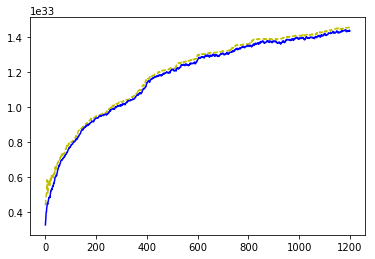

In [19]:
import matplotlib.pyplot as plt




plt_score_max =  [max(plt_score[i]) for i in range(len(plt_score))]
plt_score_avg  =  [sum(plt_score[i])/len(plt_score[i]) for i in range(len(plt_score))]
print(plt_score_max)
print(plt_score_avg)

plt.plot(plt_score_max, 'y--')
plt.plot(plt_score_avg,'b')

plt.show()


In [22]:
largest_generation = 300


In [23]:
test_list2 = []
plt_score_per2 =[]
test_list2,plt_score2  = Evolution(test_list, 0)

---------------
0 번째를 합니다.
---------------
0 1454718482222749452370904761885296
1 1428753338435818187722311128133717
2 1454265359789389304001726077165644
3 1408827290777792094494277128395997
4 1418423336294539883508250496328459
5 1419501028497817100913951254680203
6 1445650659063494649459596882453393
7 1445228246310455109493717820349572
8 1421377859313938915164054413097524
9 1406152174092974890426899115974207
10 1388397989335139004226583272056416
11 1434817261885830210019522025911954
12 1423648141308934677116345748156948
13 1456879882646800142495161664697427
14 1447258649152400304222461250787024
15 1452940672712340214562436260357552
16 1452048120576626361362695162013558
17 1432458323835263644487545619013621
18 1443724664983408393179841285988353
19 1368175170375200564008078182688029
20 1434060953097452273508777556459701
21 1408269566397636422130737653189225
22 1428411237737568277892201270554108
23 1454806550420591364921808468504366
24 1443151844831431245892157504710189
25 14549918122674

1 1438538227799450951172776667153078
2 1404978878884276353952363756412718
3 1422769996888116348319213134161948
4 1438810478239496802909209895831909
5 1443167666917491974482504432104380
6 1436666397332041666743223085954766
7 1394063271809878229435802432998712
8 1439811137634410820354431313895180
9 1448524861131102578159469305506461
10 1413187934376407033388252846655761
11 1448975271559000443529928574815484
12 1444341863310092623635058199559432
13 1433972399705684651318896061747440
14 1427782153330055089933662570467623
15 1421234942896915627663176064882460
16 1408866170152370555378476734594951
17 1447910140109127474833275831261203
18 1441973619031406451128257272341195
19 1428751858698532988478564611322168
20 1448006880117624165805643077263290
21 1447904126960852264163815472842681
22 1403048680827972191790933172191267
23 1452557170340264636996413763079564
24 1447293484806765106370494432015056
25 1418169319940801637484567260001480
26 1437454519672827151151284810139949
27 144024921895390181

2 1452090575820694587189323156457405
3 1442935797016503581648243800410526
4 1435759735432020384924394299689797
5 1406605927678137129873048006502207
6 1436790464606183729792903639900674
7 1453822814476835486080540680048659
8 1450534204678948793997737316273184
9 1429038286783618051743634291378053
10 1452406765801518482131250497993463
11 1433647535089036133402999024443305
12 1430955671098927427077651390334940
13 1453866340044113844296343407416201
14 1430745688555841965454560510497502
15 1444329541004359434568322569757676
16 1446908493787592252491505311811119
17 1453150712898987334255649603525317
18 1451258215409685862257415297035614
19 1454332458166651863626683983738323
20 1444637204995257176879416316815963
21 1395023741168694503870648058105640
22 1426284987835499601356412073503763
23 1437417668958912701650386693196683
24 1430899370358981373515606286895702
25 1448153890783416967597546155102400
26 1433343138619138749095842027533519
27 1453324557394417123939691505216988
28 14533529668358595

2 1447934113880774583178401998272109
3 1410239749763220220231342365371915
4 1430628589972410502388076019520458
5 1450247714841366359065809552231683
6 1455513965940110635362399763013003
7 1454425036170843084218693672431433
8 1425654172757506032677128410059278
9 1450463665604460638350699779942665
10 1447817252537550363361898825049027
11 1447475653511303193901553856624135
12 1455142467529331510761863654697129
13 1454208574337018582711778410595125
14 1449936592605008063200291469798576
15 1453234931801000031656526067006721
16 1438711410652542105308999566408146
17 1440668705419932284949808147169221
18 1439791184392284669621461822403768
19 1435252885178585773866199663731063
20 1449306257822052159706362469867588
21 1449251630636691947848464211463196
22 1437701216358216370893486866374635
23 1454080266341890355899354654638042
24 1448661566524405454614313621868302
25 1455494690354417866096049644601733
26 1456693050838564442539056378341013
27 1454744928325280290570912922656304
28 14550443634510596

2 1434784434854587132436829124441601
3 1420085981590090233205550258982198
4 1423021798041825146526251282403671
5 1418067027173877143466546650980454
6 1453543587384047427442537950021534
7 1455023465874339943861999129006403
8 1437512544684792430517554871106130
9 1432824419799766882756566509310073
10 1429642442495690297338439035741455
11 1438934195042403045486591966527866
12 1449697826634536288233156726759324
13 1432927907428213250987094299124683
14 1426218068249187644475962806178385
15 1447119016885536818212025836609307
16 1437972400098315801114297027671212
17 1410065077547413555720714217158655
18 1433831109053160531519129105131063
19 1421866282856275743532542485141666
20 1423743317053643620264638064204690
21 1437459030005212464185148179793230
22 1426198771216909339716518415627279
23 1435923081578111500432886809256158
24 1448502426746968922253930154956053
25 1455437810717222516420328461309533
26 1456399099635129175106122869725034
27 1456666732185641990749921568305307
28 14538825032347154

3 1453925421001828069989229223766406
4 1450456436458977884983213232887240
5 1456054537436977963858159076632675
6 1441124549118594281310893398123813
7 1455211724352257619254592711638398
8 1439472765796766894397614111852573
9 1383461996228330121671664573635880
10 1432799850911261515433892332924209
11 1421045086220901579539785934308753
12 1419609166189254672680023130811131
13 1450919375302724451800790416497928
14 1448096078753621760746399225895464
15 1454976334701039244229703143831031
16 1438911693838366582686642070804815
17 1452586815561987649223106174095800
18 1454907485537036399575829047769360
19 1456315424896630959338269412448286
20 1448726543452730156979909346494869
21 1439072073468129937076351410939205
22 1452426324577823978987790018548071
23 1449291037788368154463632049119634
24 1450348535167040993566219941732863
25 1456059100549876698567558943607814
26 1455760256324644501887648495856439
27 1434532146640281284638899158072298
28 1451019335394400853655799717584538
29 1454891169792691

2 1439365030332005388445611337072997
3 1436785159417181958700162926424985
4 1450176825060993199244144817101040
5 1445961175497956783122030364911445
6 1451103441458909675018160305102354
7 1456828841160269113179808647970448
8 1440687041988695272934672789629570
9 1444321430182654321125878649576963
10 1428128210795539410233165435509055
11 1453352959662407010295268169628903
12 1448877097000410504431210932243651
13 1443065640741127397960224587683860
14 1437158864295274328095240771030442
15 1449537280980597384088919103580599
16 1439947624950233923520981296489169
17 1453877789985183788257717237403935
18 1456563158994303697336044014563802
19 1453681398290127967887887173079049
20 1439642080539707913998390910783514
21 1422103817741963384518390812231416
22 1454857236646460669660654888591423
23 1454832929378549111693763780081676
24 1443836691871578675590731971315971
25 1457081475209126444659386251261257
26 1456757598151737067284516131247755
27 1438139013131056293782246435655172
28 14530277025640501

3 1457357385081376680114233100010361
4 1449815746192260662719843495616148
5 1458580884176385655361878912114223
6 1448261798491168110719643788831792
7 1455932568975136052384749277525788
8 1455671061178017637251247915272833
9 1439332502446490902036794197889353
10 1442614579469683469671818680880239
11 1448152145683536333281522998454555
12 1443612132578804169111689499787621
13 1450233441973501862031456745903921
14 1443187947731242809296518804562852
15 1456649459891581168531961976608311
16 1445239905013244903711350506712777
17 1455296260612156247081119032518576
18 1441380802227805017278539873983510
19 1457213871450873023896893895799303
20 1436432274839651877126552173426519
21 1453241216125389272754751975399210
22 1457569665505417535516557721141632
23 1456933246077865311978588256607359
24 1457987681705742647643269412716575
25 1457704032662565410157981831204693
26 1455090091625951199780494735650836
27 1458529203207430711855053927819378
28 1455575912105515696174335218248064
29 1445660963991742

4 1426834474952675398712399879540403
5 1438645268544068376554997496720566
6 1418051711357909192600364741201968
7 1455654225126306720040484676680438
8 1419529934557656925259152336739394
9 1414952967120873022837042352300356
10 1428720811171163050545975168967150
11 1445001733233795237332441564433700
12 1432259172097695820669751938647849
13 1436051192696451745944933233773017
14 1427733999641190447441355840148187
15 1427893871129093167685961327829726
16 1457716366394692054081239816182601
17 1426226830820143602027348881683153
18 1400377998725317365914597495179738
19 1441667295010275070589426647597536
20 1447973197386737572537455617520135
21 1436425620157869834332682488307163
22 1439564975158891472996067628222803
23 1439154643125072237728539959123878
24 1414898848717974180450777068972414
25 1453125600375876026907392186830075
26 1458252040195370729720358567795496
27 1454826824905569274724332616039792
28 1441274700786053816808538405426342
29 1458526481131268007667531397518184
---------------
58

4 1458629807973612677005578380780528
5 1459680553435708656465588460571439
6 1435834884816853222528792924571222
7 1454949478124114816893114072465510
8 1456749936308579036228226027598454
9 1441472273016973310958002695620135
10 1448117920131337669266062882532546
11 1434718141081337826822375159560235
12 1422496145729127214305736343751358
13 1453575570814102234947293017365505
14 1411959169518758074900628790922990
15 1438892543305728025583586673365910
16 1453821726834211365173757017491467
17 1457485537392899242402454762363405
18 1455648216342092975404335726527135
19 1439912301376223116117276531674078
20 1459031613256741296342052155350822
21 1453222870997929840729744110048818
22 1438841229905030984839775664146321
23 1431462518288790085300421623332460
24 1453756798185455756481385064407309
25 1450586474735465344260570025311366
26 1458885701548969523922389220027876
27 1459173656878014698283546651678731
28 1458133162956502495782025248657379
29 1430701263569070559887773147360770
---------------
65

5 1432066154698805599415986698498840
6 1434743157698197789660184959447428
7 1428452490829410920405946909104390
8 1449507590543962299957871307823329
9 1436937179387821405963500649110966
10 1458236006552823025582125780124068
11 1455179493708594717114512408779335
12 1416312954983105103680258782500133
13 1423502455311021080155984214468407
14 1441401873243566370665667412053130
15 1451762662404859870954805497419817
16 1426176047957061725664542684437956
17 1457260241496977541756153337678222
18 1456916164648644579681226893334995
19 1423214608910577749286564868512326
20 1433906279732660079051187937894993
21 1432938728221671757223865667360004
22 1454337408968342327904769363145314
23 1449550219705297047397949106251344
24 1423229766011960187781498472060497
25 1459299634850273611695557041542852
26 1458909655188224653642822718624320
27 1459197656803711433909664752302806
28 1454563927382004391755980323101459
29 1456121909240058713621761251683814
---------------
73 번째를 합니다.
---------------
0 142687048

3 1404654256962562822866934429915915
4 1452778508039927821570816181704344
5 1429569537553840826622260674577250
6 1454593541812345999356442116801174
7 1439055397932316675999397505105431
8 1436752912948986373073071251497768
9 1429808007768908416893261508311967
10 1436159698191076576317197654312869
11 1446471624822009347400801366708602
12 1417335551078918304917229283166975
13 1447250179192711627486384853093782
14 1429512742185173172399159535386487
15 1460261461543852206690089574073598
16 1414627646778525156319732867054421
17 1439809015028054578269637920273202
18 1403078489594087449851965446063410
19 1426762320389486186217762192694903
20 1430006596237222853343989965581732
21 1421092040019652975925209195999072
22 1440961093605629145123722243589268
23 1434684715234072391505588385351367
24 1456057510073292552044672099702971
25 1460211077728780210168035218099323
26 1459068620211073612637045878599040
27 1438183105824934331053720956214443
28 1451581069241827596317249114862509
29 1459723956658168

5 1445966367321361391710730419550226
6 1448794879059242939893852585803692
7 1432351634334298372974741589194857
8 1421364401099268485593935573138011
9 1446374098870323557362583464857256
10 1438068924457469665844239592385369
11 1455017492480176912961411105255629
12 1437195688664125515691295147064713
13 1453809125769084880363167313630922
14 1453587304307323090154746222308199
15 1431172835073988218304723106536679
16 1420068699250186933390820970891083
17 1452784166164939846312813676005870
18 1439321414873713020975376738359927
19 1450598367910964803449205389035452
20 1436236374106023729390318136763432
21 1441953483622171799627481198198865
22 1443378434576383096025985003158996
23 1438529525773182869883593683922062
24 1449477387463536373566633525625080
25 1459547960252761998141373997262662
26 1456759577381490536404507183497279
27 1457001269803160702131503701095782
28 1455687158669339319926518477511310
29 1456337918528974255274680910511148
---------------
88 번째를 합니다.
---------------
0 143945158

2 1435725745431692281537800199926531
3 1424134245940284355666979932772166
4 1458955844465148600865484627526020
5 1455685443594057874541569438492339
6 1420777557583365831488549838058970
7 1459427965404985502735278380802368
8 1461610832947091081039199436533659
9 1430076206391410922804388926232935
10 1453488627765764118998179103244965
11 1408688792658105397175037678746597
12 1411110682592286083250094884675974
13 1419575962914738396752986947545582
14 1458941937475085311566757676349361
15 1418011925107619385287071040579314
16 1461740611926116181320956764637062
17 1459572394566913245428942545828616
18 1420962982875681516715123629995383
19 1430383493782914425462594909986309
20 1460658364498543794524670724787101
21 1458035228036358199875359551241220
22 1459024971906607222683709800728572
23 1458995836999810419736534419771694
24 1409386380302793199225769473479026
25 1466701795595513431275968786540759
26 1447061890445175469842983407744022
27 1461291377097888932470768052712503
28 14580622283665203

3 1446302116978896766741266621827857
4 1421547963374322575638375256901502
5 1443595521941246347661225228252990
6 1459793860550785987193614714405633
7 1462984352222052383424243556797112
8 1453787597179756953525621165532337
9 1457997372698942775118915153870505
10 1444444205808833595086408198398213
11 1460310038202428812835758415013457
12 1455441721895238909370330500993596
13 1465752861846314248101817718265927
14 1453339801823092833389496340020743
15 1466978321601460307469122424172550
16 1458268815702158537738240151158005
17 1456933861498421477275806674733751
18 1426589873676683585485102233883128
19 1454622492297048816965388898748744
20 1425032324503805228611446124732435
21 1424415516126219814714786868314433
22 1461254059046533455007659174083527
23 1458938619009368489226090341321467
24 1456312373227805154903205997971945
25 1467552066491218921138768861078777
26 1464173492057392270387575315211619
27 1468648667835274237675901418324086
28 1464649048191320200294597710700670
29 1465186807740852

3 1431591049932083067404778139731787
4 1467969022669131472547665348188065
5 1464559783341232312564219714609006
6 1439031568901578751338708229285485
7 1463879766066317847488123157212410
8 1422680475265568028207041634195844
9 1465023811004368833967963077970749
10 1440663426680026628593055563435285
11 1441458304153529517776342562219412
12 1440276848188232735185611075091932
13 1419136473532457435597601482889091
14 1444911358661948560844179766309354
15 1439195238739027964244605739968021
16 1444612516794060582389640912037870
17 1446729138384936099405182113548776
18 1470363786908687289115745279509012
19 1467386391913703283675336615326193
20 1469511429803520047250191254446770
21 1469692994837454517313881471224755
22 1463063109467659535890244228609749
23 1459005395316863570340023725030208
24 1455160573699235512174539380611150
25 1469381578371810914152153216846963
26 1469218075677901967095622875035908
27 1465859606619483723159633392745541
28 1441980995624761418580351472301984
29 1469292457084166

3 1457009976316878106457651330422406
4 1452604281149748800367783491519770
5 1462496655505636663568082594240328
6 1465674386715052266592437900843343
7 1438554868780505561254983886476861
8 1433057638973360671942542034820143
9 1438081784923294881598455791692005
10 1464460778620410497638717581975112
11 1468800098846406687628115294772302
12 1446856839304920099773542554076632
13 1446258562855756278704294827937393
14 1447624250637751825764579533784369
15 1452633733430746782795134336644344
16 1439167698528094989546092511605095
17 1453547246604046462112071373975578
18 1459711775562420230424898786064599
19 1438186470156900220894089419943078
20 1471896775436752710270236841047243
21 1460041148567622556528529862605360
22 1464293706242829842919583574405252
23 1460318048806598719123449410296365
24 1462008678632747835849704226471310
25 1470290817393119524815352944460246
26 1468236666886387184083988163880027
27 1470482806294566878172371422662257
28 1464898092960108305465192298240338
29 1470331401287400

3 1468084590193888350741098699412797
4 1470618150280919776619258843909334
5 1443766565314786659901191720758004
6 1469378544012560361791403867503589
7 1455031218865197770448545227120577
8 1466423309834051698477818322827960
9 1447222723234753230885437521168023
10 1469093595742178993840694901446151
11 1453964751904181848042087459844273
12 1458595617762167024062393974802849
13 1463761934043396631875131136853764
14 1452403741670664455211782425292425
15 1420983897617626551625334903745176
16 1455331488859082760074511212099213
17 1465901723430724729601482547472555
18 1468167384612427048371370101378655
19 1432011998429677223038589665944496
20 1454308913084354005618531432629170
21 1448366124709474212275412587776050
22 1448546144624189649124148390982049
23 1464267110312864533210557624898274
24 1445824398433037264042884209574511
25 1469984016159523328332470640943493
26 1470038655319800732607571236474667
27 1458217280836167658233571546639207
28 1468790159970749963850110487457146
29 1468904425252671

4 1444035129412660150896017246149721
5 1467875425396906734197550706158153
6 1459948236584949511437008129290929
7 1457117737950805161733516477521451
8 1461201602678390358491618119257876
9 1436836167266195004417182870585190
10 1465034891069568446956859416086943
11 1463884738786222875661521704677549
12 1471676587946338994715991867993691
13 1461105402166946628343346523315261
14 1445706625299471300601100865236833
15 1470775323697715523750466176626729
16 1459877561993913525470969881543687
17 1464556278859511805737759286722057
18 1436666390244157233908041083889094
19 1463229478141701259032622747966812
20 1452437610523324424187814036041700
21 1470315987222847922976129259322784
22 1452096380879819784180473423621897
23 1441157102212781128580994861487334
24 1471497634042194467115236934551464
25 1453469914490101648739123009223794
26 1471480636830065058643856711420867
27 1471811975254577045716187683526910
28 1453481009673597877156146651673004
29 1470874419919648563419971903921542
---------------
13

4 1456285622280621267549918131945543
5 1450798000777673744904757465842778
6 1465482907610579661881872261810694
7 1443256739483075907112443915141691
8 1461199774612617383135490272653705
9 1453727507231680405404504914322918
10 1469616357702093217764564827530315
11 1458474718185245804308873664208302
12 1462902023080948541447371509924649
13 1469874861661744021442997125802644
14 1456583239706725286273704338886431
15 1432870551840533754547630708907954
16 1451541218325349369188935244422487
17 1462852074249861198367507498492010
18 1470554232298462915384003569015621
19 1449990278846641798243864110258345
20 1463242482457271680750057608179668
21 1430091631748297713258955548921861
22 1472522288312668238330769180546736
23 1459435404997350230898809510270746
24 1434805400274585237773098487744357
25 1454082523939206327114141288125208
26 1467355117023031981061220650323171
27 1463315525607540960767543038016902
28 1471513057059503724035819523599605
29 1471983609094033414653328417200931
---------------
14

5 1417560195703329503459919763033286
6 1467239645038275381711166552739819
7 1460407446247906927942447609758855
8 1471637557941923567972488155167131
9 1435055803343708043427939275804253
10 1436587109649750454739691615672412
11 1451040871117429906906923016401708
12 1412917501585636869527088309697166
13 1440745129236366473038732959076920
14 1461677073783110893395558804067920
15 1451101288334156211992138666822247
16 1467857725278134223503293182236218
17 1460866691631556771457181615825594
18 1465109378032871824246239718127613
19 1405111008469223745168874582999857
20 1433358265903796975443456367767261
21 1418028633795796336012121393435715
22 1444610665929591510450930981855848
23 1444037848198878435672727972871770
24 1460269479840528088460574837498712
25 1471024241345268851221070858462368
26 1469644776889607910750856278787947
27 1470397816471254583335252304622923
28 1469207172891250764936784463525049
29 1470432201447652016930348365678111
---------------
153 번째를 합니다.
---------------
0 14479833

3 1432891970505203091073860267018608
4 1468712588398180981278117957919379
5 1458812025111382994859794670575981
6 1464208193114787516884410158621895
7 1459660726896337119988826717600984
8 1421693024790820655545134965339831
9 1461650333302873415784405621459016
10 1453738113028161347803919699784499
11 1442383216805915009877469145024580
12 1468605667278129193391732512602756
13 1461188093347230766598217232545330
14 1454656793715354668490987616000492
15 1448307288099280721276955795138298
16 1461160735387647935886663121566387
17 1461161515473568785158604311862501
18 1431548525359356176883857290797369
19 1445084162755360569865531566699839
20 1470217846452612148175814794825743
21 1447790626656492736057810775897807
22 1457863112457234281046876192932982
23 1471912074072122746892035831174655
24 1432988424832092401710027282028869
25 1450509745316655793457026717035842
26 1471582566950225104548263470580838
27 1468846151714595820064284282675027
28 1470209467187436203539423093966806
29 1458431758584562

3 1468963808232519835458439850857952
4 1468436520127128556965589476911378
5 1467170408231007378976210665483602
6 1420527102679332310450257889573823
7 1453452797203159952371251006080818
8 1443991830793929774597438850771199
9 1461551042158414567384124606027654
10 1464153082978294066217721371899745
11 1454626628149098566469927707198824
12 1450502736241839745834126898475828
13 1467285628757226567418624471409255
14 1456444272118154235358764549960103
15 1461043985076258124275887601422590
16 1463121953388870073717279064103696
17 1467295508666165172796420881529249
18 1456827042180254423453386442999115
19 1466106572363515843989131262699857
20 1445891576840806010032002363989498
21 1462014128010772002827293142355047
22 1456251573511410970152599278137671
23 1460144602461841536511772985382490
24 1465008975142616256661202019735107
25 1468986346693082826127575707741617
26 1473126444798584449890743752807283
27 1473198551526297253940831782164995
28 1459643175471386151007338902677270
29 1473111307168796

3 1461887716582342652095341038623986
4 1459432478241900409058048975989244
5 1470630598465643381551056271237192
6 1445316333887595721286062289448820
7 1463966060214193778956234848304130
8 1443449309381010595984623278570491
9 1460450285906359187717654781507153
10 1446029492127173857525400252468389
11 1446029492127173857525400252468389
12 1434415038844214653771695305806663
13 1453853958041926708458203407384793
14 1443672630232023542583874227217136
15 1465202670772392248319060396894138
16 1441925892801730374683596873136192
17 1443482480104098636874491916457313
18 1450936368941153171603974713271862
19 1461568572088726450615925338730307
20 1465571075279446904973318048993639
21 1470467769741072470759652034676659
22 1461590504197935501570979094275139
23 1455371365327349600449213784657664
24 1453355748740996536502670125672105
25 1475221614663728757327009044130697
26 1467978468447666273898096859535929
27 1451442135279842995063926217096458
28 1472596134096572903257939981552821
29 1470800791113198

3 1424473529578427536804350175984703
4 1440871318349038074190458404555348
5 1440475385018319991871644386302591
6 1464336431025252799295372845143881
7 1440030913011392393595403225937195
8 1462332097497893789789235893275269
9 1438615222257578794470575695468183
10 1437263410367108785714980290940898
11 1445037350837475378200271363476791
12 1469426404581231720739991202737939
13 1468054577894501880836420993586314
14 1455725894555485824451816209366506
15 1425253055121062796956452220339063
16 1460930276368955760855860055068372
17 1471193314383186982109956548592978
18 1469526790159499151336445538049991
19 1448423688215544582240480265745417
20 1448970181026126760826512527659836
21 1467823596673266254959166233817231
22 1436753737292850384484802705777629
23 1454491161162649097992815316631271
24 1446953458051641338824439276158603
25 1463190905035572183942788315806709
26 1473608135586253417904210664559949
27 1467691733748917937139551661517296
28 1467162768523569942350752199989470
29 1466814821215811

4 1426500104983867147255088260658271
5 1447397156101565596220429872397523
6 1458189176497394935601542718959223
7 1455247393369755696458349597046420
8 1475204703730596196371302103744327
9 1440096518782323500526295152300280
10 1452862562479435591527266885493409
11 1464298998480072619054770471454133
12 1470929005023004652397866772059766
13 1457168514318544662954222251846859
14 1423070129351453565581171572457343
15 1441253994743432425973669741827608
16 1466734832260845383224327915436982
17 1460096121970234949005861173960183
18 1452160866333947720191601251986512
19 1423165588199617509297479576398372
20 1439842745656096474995943364196581
21 1455645291373216517545601410793220
22 1463487829891670565357932626993063
23 1470385759053177240479157573583830
24 1471565571026659543407622760309245
25 1448713805208517033456859318108477
26 1468425088962933319608833096469931
27 1475937561162637911546685282778985
28 1475056372813004248672124739854129
29 1463112322855931019985533414373835
---------------
19

5 1414601418015002601491806308829244
6 1474148049746117503224766125321509
7 1423865210867893969419186994552709
8 1470779878594390903105226055444582
9 1438614970894573946367198438399265
10 1456215184800609300118762704173296
11 1446803551561348117012445211244538
12 1475887711249737065654082840269955
13 1470901083517666511220779463848480
14 1472243670864760619148797163447433
15 1467000560456143467418973539809498
16 1459771329458127025886402460331698
17 1427313219819685029482332201912765
18 1466281505432903610003306630529787
19 1473339417087173609132103705103222
20 1477347243103843514809320919636356
21 1476102043370788394786488061187126
22 1453411673276882148481161631978015
23 1430206946304096249515100267854456
24 1476947448738771574269717200419946
25 1476534967545553697295261787904795
26 1456065244747928923632405301891320
27 1459971514090686177793716141774174
28 1475325600721363332094312257105109
29 1464313036359733337761076417677391
---------------
204 번째를 합니다.
---------------
0 14705823

2 1473653230367438662701615094735800
3 1471348599937441404254814552093225
4 1450835078528929223028457328856795
5 1438456611278085329411460709904298
6 1456886174152668325343708443446012
7 1459543060599449801311810786227181
8 1474265144772828946159207407952070
9 1455983798807830315924804499951876
10 1423637883354736084758613768758634
11 1467310598555862162108409898777639
12 1472663375468468532889866102815092
13 1441402973054406293708608822448384
14 1470754156344209437303845616639276
15 1461482599192517927471822390848470
16 1443951257391079123032815587207294
17 1461226978000233259443903718026506
18 1426959150476153248058264507933224
19 1452942360301253441826611624675062
20 1420199192069921438449332935665788
21 1474339523144402950538472634804684
22 1474168950311717965988821134187103
23 1455527316412677209610526445093818
24 1452240090453312248467902207418246
25 1477604429317272902901329407078729
26 1459416358610957609930740499004018
27 1476484594072500997361551169240608
28 14763477202554581

4 1466761741971142854983741891097952
5 1458455022078496220274371317096903
6 1440366149082064722530066747072568
7 1428007758135178108729896408023294
8 1457410400286518854617914044873993
9 1461153097481007262132168728854839
10 1467224398292865983366990930267497
11 1435919787213330435053221416228003
12 1441075348884942762507064384345498
13 1423096118784437454931505014834478
14 1432171422337504839673835608639500
15 1452944989909402305170476606639583
16 1403890282249776671633059167597879
17 1462454757743835621684478849354874
18 1465966102177286903203226531930355
19 1474372028960155044474794093073018
20 1464941406590896532473790336702824
21 1463809553645426410671131541106150
22 1452077874930938267553215363377131
23 1460454211906015362066725400686249
24 1429120337905491055165822267856689
25 1458323539450736305553793295837007
26 1476249915552116591216494121356255
27 1475167642850769081791885013593185
28 1472840062056988464079265014977137
29 1475439049100285088557046504531587
---------------
21

2 1461759350791187801390269286933638
3 1420909278378706472086693069943892
4 1476379491822574120222666600122580
5 1450116524841168777143476198322507
6 1448200950239097614236817486344710
7 1394362188865322300219508305167179
8 1435827021485585057530948665012693
9 1378937352844929596992217038970881
10 1431272652236004418985294383216250
11 1463150832318657275790659115048909
12 1423520499571307745361326487048048
13 1463647313453917253514986235306437
14 1469849760395792700376544655579928
15 1462904670593965676655640385130385
16 1469804708024633258691931830041026
17 1472561826693224096455002723128584
18 1428110228827229847896329896488192
19 1465469135270115571859628196328394
20 1457847758774066633345781035832268
21 1430851141007501613277102329630035
22 1466082602579627213484933576084703
23 1453987973555545978694267523454432
24 1470260400941291825301585994711799
25 1471540169204617361850916059388964
26 1473473435622993377879222230659130
27 1476002012236010255065049827353664
28 14580067071945942

3 1447291756588777387630032450432565
4 1445593214217655669590179422399050
5 1462657433004993788158840156619602
6 1373560080780066015447416204689512
7 1463413515774291928267194355953270
8 1476180083286734973708734621107338
9 1477038621738477121044628446095975
10 1475515196541899511303152680534327
11 1399997859203772719461047987535508
12 1463214038561868525529812111305245
13 1466256533868803448946675093155586
14 1445206585446180550855482952919364
15 1406899633781816420551184533163455
16 1466962207762814724230694064266309
17 1463446905677879671189590932666242
18 1454016623064897776542512622479970
19 1466251594163895553696595641514814
20 1448191788734736013230291899127688
21 1466681872269115518157250626521701
22 1434055594356737130509755933367198
23 1445128315886224114822551000285095
24 1430684286448461123749527058533299
25 1459253010242621275098994582709740
26 1476340346154701275597327542176240
27 1474713542684272819655151870677070
28 1475281860318089717958436212260068
29 1474556726766352

3 1450018966380966437276127918107080
4 1414327154485667310550548564749175
5 1433946656426174845680925186984251
6 1450349422368157490998191717223148
7 1456791938616171840144363088673409
8 1420459505956907513112944300293614
9 1453899615183387563348845324424842
10 1456235835993769328320288051410170
11 1431179564927703515330658254608347
12 1473870967360400962823897533230175
13 1457673076108549703132458359021601
14 1466888334276078505201184341534292
15 1458016445269674302712113431127719
16 1457324064270239150234733404079008
17 1477112934938142011194626414208928
18 1436971850150411803833024384698945
19 1437811753698827687015449092057157
20 1455139107812385158234842312581361
21 1466852039204015968340230598971969
22 1440839317439401662373182800759832
23 1461617758481973587310088351311935
24 1458579041813744391607454506213487
25 1476317789042286762578657005846464
26 1468723609843552047076177770838753
27 1476159833304096303675068062529611
28 1476189845198659828098124063652256
29 1472463805714801

5 1456416118351155799053867806026359
6 1435400638086897340293046852444459
7 1475931627502435751675474900586414
8 1455687396844907793590506559645179
9 1430843866218750022554487281130333
10 1455888245116799708905830688674670
11 1438275758163601265291196041855213
12 1427932858906676640832765678616676
13 1423511190718273600524490453447630
14 1455562094343096672650561348729175
15 1459850904027814321627848622717815
16 1471847260406845020284017199474984
17 1477628157511115964529929560663922
18 1476142200474441518615148124610605
19 1475797557801972299920772492903998
20 1434577057443271628121059959890533
21 1385919698925411635919865622264921
22 1475657138192829456355884489160718
23 1413911949444439253182632949935074
24 1491752886290855134552479268230455
25 1447271617676006803102377727992775
26 1493267148517596153824951547923643
27 1467005610799714779012617533968707
28 1472003309245714358387160423892938
29 1472732137045269610397883668498557
---------------
248 번째를 합니다.
---------------
0 14556592

4 1489807281887975217242327285968015
5 1489808344503523750338700762353775
6 1476404351303334512852431463349697
7 1491816300294391927188814425827160
8 1489365398287255430750637945991212
9 1469487121104945708592907760799325
10 1491906484435173956514202433442964
11 1481375989549873172978118299914819
12 1444589135234124293235726880812305
13 1483839889951905044559839445532020
14 1486502921730056752563525635093387
15 1484492203703404482693322203339006
16 1478217823808424589749928370507316
17 1475302987639625650615045632304203
18 1489662957403414637179118932485569
19 1492137951092937642577260802829340
20 1488335219946770980844866261006110
21 1490518658600765736663775404628477
22 1487545653828417372030216195066858
23 1494671752903099212268146008866219
24 1472178020875227936588823092403784
25 1475150646058520607729448851487916
26 1494557966441286596797589310732907
27 1479878894804953055359176567578537
28 1493811173053663136273607065886168
29 1493060230249109218708531983126655
---------------
25

1 1476258826124688683226750592784956
2 1474225319618161019462311607927336
3 1469595666941304882789381850767787
4 1490057533135495044325498543911571
5 1468975223510907893672033730374066
6 1491856122777040863379065815277057
7 1457039162317743515112562083127267
8 1465548364903675907771519226251774
9 1494909487618636144060769797197743
10 1476332152290873783862864873984499
11 1479758945149995367961430221517903
12 1489797207277262508466270545183505
13 1468477081774283275510195214656092
14 1492385626110410920316742196507111
15 1485543083153993920493336650174801
16 1469199625080232112258862139702198
17 1491283830094961298781307483154536
18 1472049682191118403688371960377191
19 1482746847780248856899124582332929
20 1467446727874332905388628371004269
21 1491434551480310871864867586758035
22 1493448692101817765985176880056156
23 1472880278019584384193149742386162
24 1492762758566552395995064049178655
25 1494296222683464177363351652773899
26 1495163014392376309333530399528960
27 149249758122635191

2 1472444325812332925160987290923776
3 1463863560785516529405055626669101
4 1486501966590400634481305059849933
5 1462448483339793566102604658134500
6 1489541776086563304241798070576371
7 1493898345952888249689086350383521
8 1488773490861566265998052321520518
9 1486954435506402017345972438841221
10 1489786387297532007614431551792545
11 1466722780513737050844653571034530
12 1493744671912077037968935046376339
13 1484745058647855358196321566715690
14 1470328855455362698341119355283280
15 1469296359722586158449809551965661
16 1493641888327277467946429231561143
17 1494879888427342933407076615320888
18 1473198787901163952942237746463748
19 1450323457174102561972936114389812
20 1458404624955068789958938231203788
21 1473161026757593632771418125237321
22 1481836665143724889245172801761279
23 1493683992487595619471712234378946
24 1477039346344132553664578238275730
25 1485833771803812401670911187228140
26 1494353530058170872312877814336530
27 1494275805043173694543573303551752
28 14878856714651785

5 1488639016154375422608738037388382
6 1473233403717903178596164497253067
7 1453347355430734877282227805172254
8 1485575503562210116864732853094696
9 1483580497266634820654749406998099
10 1462165589371897371957076714191010
11 1463308310568534545894084082844935
12 1471412707742817596838584005191394
13 1473639746171901880340706904634087
14 1488686054870154191365502394772118
15 1475444169132420808303065539615298
16 1488748014169597721031534912099353
17 1464415540329126263678505063046632
18 1454510891092532687338602274837102
19 1472107687352416826472400668207108
20 1478160250426651828759197583246214
21 1481284303867256281462617869624746
22 1494454193066025046433841373716037
23 1487901152488366421058350242809326
24 1473787882180519521533925098386129
25 1479843646648484410972825953007764
26 1494039236578341257714166810155552
27 1478647568645547133299734167119160
28 1493260503231659533829054662124791
29 1493109748107167139305227113602007
---------------
278 번째를 합니다.
---------------
0 14712019

2 1454190443375345104054308759876670
3 1493104597212358903727144506232463
4 1489898485781347356189958520675116
5 1479249676446153122949910086163414
6 1494750282885495885271622343823182
7 1483481331421719655993722679352708
8 1493756631492786403327101735161649
9 1464004247109948917403612915404616
10 1478276538764667116838393017745155
11 1493491429398657541122392468330404
12 1457882930897235588180353832784744
13 1492425884810490684106358291746414
14 1492426139277827406582736352226047
15 1486919843233060887485479405442384
16 1491683431381705226179038214555068
17 1483227513791910035860108458692941
18 1465296708347812663654031807677463
19 1486797677197434770026093934084464
20 1487143868576533241127655972914595
21 1492263425499126831944614613022949
22 1482841564921097468965536403092939
23 1488145215642051036309436443679076
24 1492808303425059985163315612130292
25 1494418343233515699143665787203107
26 1494992198816102016293297200223383
27 1493103247658538654087664950422673
28 14843834946724149

3 1492091814595423331447944361935087
4 1505533532698064733422044342190394
5 1488594529117380898310807695098331
6 1486041683556534248585119311080318
7 1478340195070966631636028849594498
8 1503884208560507255771179138702738
9 1496727371164141328275012676421234
10 1503558813825007214802676582607810
11 1492807828554234115940743603490429
12 1504829720051474392936256699849800
13 1504831848165141545833506658863888
14 1508679618987891816863076770857464
15 1492800106041106019709264486167083
16 1488997476954267923154080192784179
17 1497800038828406252405483042969805
18 1485132698615635547300571162057505
19 1483242999795156931748240899174388
20 1486868060046919238980279397215320
21 1482820461892874351216048164912583
22 1507853887532003154330127152848301
23 1477150809649411505114420865527751
24 1493697964888748920735175274550322
25 1486365904934660355271216213818520
26 1508264362049895126203242421532104
27 1505428741316732205975569580676950
28 1503528329063157842404871987999042
29 1506500766132911

In [26]:
test_list2

[[[[1, 0, 1, 0, 1, 1, 0, 1],
   [1, 1, 1, 0, 0, 1, 1, 1],
   [0, 0, 1, 1, 1, 0, 0, 0],
   [1, 0, 1, 1, 0, 0, 1, 0],
   [0, 1, 1, 1, 1, 1, 1, 0],
   [1, 0, 1, 1, 0, 1, 1, 1],
   [0, 0, 1, 1, 1, 1, 1, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 1],
   [1, 0, 0, 0, 0, 0, 0, 1],
   [0, 0, 1, 0, 1, 0, 1, 0]],
  [[1, 1, 0, 1, 0, 1, 1, 0],
   [1, 1, 0, 0, 1, 0, 1, 0],
   [0, 0, 1, 0, 1, 0, 1, 0],
   [1, 1, 1, 1, 1, 0, 1, 0],
   [1, 1, 1, 1, 0, 1, 1, 0],
   [0, 1, 1, 0, 1, 1, 1, 0],
   [0, 1, 1, 0, 0, 0, 1, 0],
   [0, 1, 0, 0, 1, 1, 1, 0],
   [1, 1, 1, 1, 1, 1, 1, 0],
   [0, 0, 1, 0, 1, 1, 1, 0],
   [1, 1, 1, 0, 1, 1, 1, 1]],
  [[0, 1, 0, 1, 1, 1, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0],
   [1, 0, 0, 1, 1, 0, 1, 1],
   [1, 1, 1, 0, 1, 1, 1, 0],
   [1, 1, 0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 1, 1, 0, 0],
   [0, 0, 0, 0, 0, 1, 0, 0],
   [1, 1, 1, 1, 1, 1, 1, 0],
   [1, 0, 1, 1, 1, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0]],
  [[0, 0, 1, 0, 1, 1, 0, 0],
   [1, 1, 1

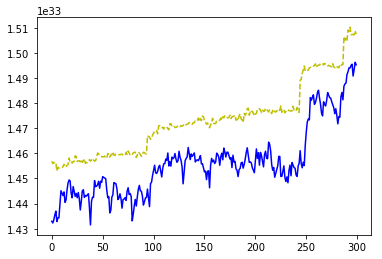

In [25]:
plt_score_max2 =  [max(plt_score2[i]) for i in range(len(plt_score2))]
plt_score_avg2  =  [sum(plt_score2[i])/len(plt_score2[i]) for i in range(len(plt_score2))]


plt.plot(plt_score_max2, 'y--')
plt.plot(plt_score_avg2,'b')

plt.show()


In [27]:
test_list3 = []
plt_score_per3 =[]
test_list3,plt_score3  = Evolution(test_list2, 0)

---------------
0 번째를 합니다.
---------------
0 1483913007887994877133713288281332
1 1507334498199938400049572150306497
2 1504874353322459733479622814462375
3 1504141040848671562547566306651281
4 1434979161285111743690531095057071
5 1500976232563698332657888763758397
6 1494743637813241994210101980692003
7 1509303994018892075731567152473428
8 1450015590088312594176448129755198
9 1503314198381888732928979179283809
10 1495088703370835912211522351010675
11 1488894916155653504911119387181312
12 1489127063032269965815283700684520
13 1503977871480613302073200912230100
14 1456021595736356883705781633219191
15 1504471280374535806412300634418932
16 1503623166670243425279916856262019
17 1499244909795976558109920595988185
18 1506231778688633309010003924820773
19 1489714688121096677278623320278533
20 1487132232625212649186842292801991
21 1457622910682757575007108495251421
22 1492846077692855331908281688844911
23 1479737895400874737334970878912568
24 1488298800929966567536366897708256
25 15014776586450

3 1494951282079584201869326604927731
4 1485169168349546649218725151124976
5 1506049473453648847779312332853454
6 1455837638554054246496256556766378
7 1494408000056050801897530830179221
8 1505564009961061504564199390883053
9 1493770443243855567688239484130520
10 1486906612623465674007902781686908
11 1496389643388150289202247476931100
12 1465516356925190701210725540114260
13 1506778025477939010159133111244216
14 1479707323680412112766031063687932
15 1491496790626185388167196347239479
16 1502141579709206305581818564833801
17 1505745260879856150971117397904174
18 1483815831814886139844229906804228
19 1498823624801836278815970040267706
20 1494958938985520728702588939271451
21 1489753125032017813155370462236460
22 1493116504306260597333975776662922
23 1486163021714616323394132841780307
24 1504060027449608070339607203505064
25 1507659521771110486336546395109925
26 1504737376452916005659063234916442
27 1505813398239670550963846849152293
28 1507774029072588557084981171471369
29 1502250012386945

2 1506293120845325712038311647585125
3 1502718670190870463916319012027594
4 1498175231031576277541053690859280
5 1494204402943369903043311667156283
6 1506320163378504569382752567615587
7 1504244482296308971333844386138629
8 1481413531960396118511278060840060
9 1505147801611278753037676741943209
10 1489934938309455103281114275586809
11 1484084785468704460741531991403180
12 1506487564989600515116712163352752
13 1497500297578874086939286761675970
14 1485214888484036749298452111754861
15 1474194069139583841833323282673901
16 1507620957372969516831771132257554
17 1502964603649009704294668217610354
18 1476379362541082626381396101524092
19 1508465463309256472524569709101375
20 1486248430412388104310373535099954
21 1503625608973869907990394003747809
22 1508583473025028875604078380196856
23 1480899036946739869078683004705280
24 1490558240746431726325538875684803
25 1502361083901218252060715381382498
26 1494668967470331042979458403284767
27 1506229261116299248933639305011219
28 15039909005782651

3 1497235058021033890223976469768760
4 1495847334028641582825983651750368
5 1486634314245094654312320946336456
6 1508562671874204277117424229548434
7 1500500485844724237508578444948904
8 1474045363611601914496051712794756
9 1448501130450909846787029004844764
10 1479032729664753000286263485639724
11 1507462025735168860683475623275693
12 1493974127815380492941068347855831
13 1478126719589599476224126678235604
14 1486735131023293080145909957414615
15 1491570156290704922705562758436042
16 1499479894918929760013684162798447
17 1495911222339035948992437987316023
18 1478857388088979544075316635775240
19 1499308693522741737115591740400010
20 1488585793941151229010948684936507
21 1509576109630139574889014875167325
22 1501890707263386917167545463123376
23 1484304364992179930287785725793613
24 1461200889085994501815204758158733
25 1509460515282575376013939425447606
26 1507243634986874831309941389902958
27 1506302199768356124070730348957843
28 1509498600547690576594067471387004
29 1502304833392189

1 1493226330614396346002089802811717
2 1427727583545944847979288688550367
3 1510403936244022325570090491746156
4 1507101336638264411349498890837805
5 1500030199865824300915437046250077
6 1468238408617131620308627216740600
7 1477101324924669288982839526969788
8 1503550531630479948757999419217405
9 1486317124535254178866578680439999
10 1507336008859495829805953523657449
11 1506734620560265807327611187499478
12 1510916009821131797350892549677840
13 1510916009821131797350892549677840
14 1457131210179107307730413004157065
15 1505433620190214118095580831464958
16 1478485068748633564257920206459034
17 1486427672725222668909313035626936
18 1495972999733455884076610759360572
19 1434615271597384686566146835357307
20 1456580596677397351421838943007169
21 1452575326320879902473663679632689
22 1508712393072715188634068179394376
23 1482612669385230750557667983890123
24 1504041628802552676038451309281810
25 1510801355526123103166707612795912
26 1509175160832558190813782689339980
27 151129114302177770

2 1466163559810042552916554197743481
3 1479141105864952369416958842031396
4 1487375991519405087569043863292025
5 1489792863958958853174910860266969
6 1458799702584597713468214271689599
7 1493831893353922766456446893086818
8 1506040628965904259397091535593670
9 1464106375012184976736001020759171
10 1482946960638472975849478917836652
11 1468019964064384265525448257812199
12 1507594276622182802457466716978084
13 1477914252378497016561910713813003
14 1487214807458492161534247394177799
15 1509478870348390263932157618316760
16 1475210116677255408459207202059337
17 1484885291171099956648861635418397
18 1489351869876506905756244290233382
19 1481714819200740191557000526035445
20 1491572403537973731393584752533186
21 1504815338230049340795122776754963
22 1505917179438595182132722764524678
23 1507026483011735594267488008221193
24 1508476720957043113562575370119789
25 1511569023941860581291283995226691
26 1511171252825067798723599893814861
27 1509066523561090310252753361154306
28 15085279374862646

4 1484308809628400884200371123576994
5 1473340159556336024190887979350574
6 1500742424860696134141875040020836
7 1508972354517144796330254240022674
8 1508571803174473279862717896799453
9 1495154139998029236719789268522169
10 1473587884769935219143272897822883
11 1508787915419776582780745652334853
12 1480687606125063804527766097162016
13 1485816065593978852141735584471114
14 1494432589759773550543567064211163
15 1508238156006664658781302627985404
16 1466815233530168372066930833576595
17 1498786502283152103383354871166052
18 1491625142499017565720894089838678
19 1486185702032999340095187652175713
20 1488716961617217642227039736688762
21 1490300411520549632212890973014516
22 1486143316979557107836181712567328
23 1488451478045993247369463315681658
24 1512116291334942552012407087901005
25 1503154972998684184373736025764512
26 1501821104898480175770292512958999
27 1507231839806763336142192347548553
28 1504952195946734978867450298013172
29 1482921830407219713974207222521181
---------------
45

1 1492014775362858277970879651056439
2 1458678776929765589215588345296120
3 1489386763788379222012529175891102
4 1474990376581563701405360073157716
5 1497410689465395194868625173149326
6 1466539993842281796382458532492728
7 1489837938853553314927787697599812
8 1493315183929014394888231163275456
9 1493298411488210051767768614449513
10 1509903648103954741752843858050506
11 1460743784169151451811769541594753
12 1508946127312591447612205056143024
13 1508158423232195128047489676160563
14 1504933793333654486768608046077040
15 1490800954671134910151964934434558
16 1496684320399930304984844389010471
17 1494537755552689604150000242567788
18 1475876134055715140027418248165374
19 1471007617303335251896706785709929
20 1480624490367067164855214318903343
21 1478408525028189966386680869856519
22 1506833185219798961832849435281237
23 1513333147618007361990049602983366
24 1504632061301117804375090450272026
25 1497277075010666504134772866735111
26 1508393903413919567097318629733221
27 151047886629943193

2 1487283442996903921690605350384755
3 1488275350586483940849561373644994
4 1502947148369561910698464722717994
5 1509629519429428123458402558839826
6 1511237473154391798072520472996651
7 1511237473154391798072520472996651
8 1484793355387808556099287791489137
9 1490340345972353598376765610483033
10 1469049907307075749109678845367862
11 1486499187376500390811084456589017
12 1490849771643354610135897868968422
13 1508960531291317094995262769263943
14 1493016012264833484000230982644431
15 1512437451223743368143452339332556
16 1491103320865322784767820527673234
17 1512969417295595427181729293812003
18 1502254886747234370876745905789408
19 1508706413239998234521959722611067
20 1503425394178235615965770853837386
21 1453833540269623387412390389736403
22 1457244651957157125736738553061013
23 1497662199573169603575205618342629
24 1473897821817611742561156511600837
25 1512132510851680478004315164983255
26 1513844468781558227114049990408391
27 1513624638707611897092969899256696
28 15122474775325084

3 1474116788899481595578538343452198
4 1513826151815131157275660518958189
5 1454984717563554451001943583550381
6 1488077281300258312972075398291934
7 1496278116498903029214066087326700
8 1496940427587014922913264237197972
9 1494738059245984626371899946599836
10 1478571231155534427285670519982581
11 1499870370466294323300687237664468
12 1498740471113142885688827819459299
13 1511803673274340745726821303351642
14 1506925886926708717203494021291249
15 1494529704287194992483258219694255
16 1466824157520052010478643833185981
17 1451101283157598093503118811964842
18 1512416027221386392578393673443064
19 1512692469151706672383246772887201
20 1474185548644890023273873195936933
21 1478722597819410981242066104818270
22 1511216801900242188133195525626525
23 1514409735225159805882940874736202
24 1510177605221700347099816778436268
25 1507117916489042896863332116641881
26 1515095485159908670345010756254768
27 1512769563715298721779652410576018
28 1514807281339575083320847871262730
29 1499159583773240

2 1514250951811711651802835997546840
3 1486797612535324572479438856307206
4 1508828689389461686704204438530860
5 1508257576387267267122779669973487
6 1504702789115596146738326478555404
7 1503533297142090583830717445183959
8 1506934934852988854911821564885285
9 1482652214114958640426136037950842
10 1515231569741533389982450821622677
11 1487724481519226616960624641384857
12 1509015261915657443632961245673719
13 1500593019069072620828963060864314
14 1498946304003873892852887669368807
15 1496855463606342530299575833045687
16 1510722434808607135057295632312151
17 1493134154582004652229349047745567
18 1486319174687208514729131214616596
19 1493921980420592767760264277504734
20 1505350935330288576432759607993830
21 1468918897328987830843583535858688
22 1507981646641770683218821791145886
23 1513198029586369069531733782621143
24 1497142247217811415488564119906346
25 1491672877548758043966658761253029
26 1509307478435705620921473008498153
27 1514592432664225361280627774838590
28 15118668573602925

3 1464329771918311505095992384494776
4 1501253229372246897875608751720364
5 1506583061130538027892464889056499
6 1499387004032016959815590080803061
7 1512527813829740313279483029865989
8 1508276733394867973800482351622112
9 1487536278325839275369218364153351
10 1483326910215477215441135126734327
11 1504312447247724285552488513486736
12 1512494076067057628600955366086600
13 1485838112170578674497849042772757
14 1488888039696733654793021618743891
15 1509549806405979021897593083468308
16 1503452158162716215719988338595251
17 1491528978900029629051499936986479
18 1509906257700236995711743462385725
19 1510299650390371394929068110367791
20 1491780482998365957641634668686415
21 1501823544421384876649985145725747
22 1492015803719328316838224388323476
23 1513253735425617413686858135373332
24 1499792436247302579301039987791584
25 1510103473832971372936522926853349
26 1513267586659271854407899638478139
27 1512291717406551041044008188069956
28 1490462376085114436353049491187027
29 1508815302282051

3 1461651194185878983517223562270539
4 1510820817158192084664495648289925
5 1510334630245194353227884793820688
6 1511970253270464135224300992012978
7 1514015564525698068794547088980260
8 1518480410569402929771787033500244
9 1508621724139822088193538100647691
10 1475358951733156980904236710571078
11 1470173906434705399095743603976740
12 1496952818618520756749256086084413
13 1493469329534514001949220682321329
14 1506536059509393034281979732171626
15 1493108822827632520616037709914107
16 1490211990903749652024533806778575
17 1461705781240661019645355687147574
18 1467883534995361322530664454109426
19 1473356430635908719142028697963119
20 1507859047723340430508730923245515
21 1491683359593721389249981766794129
22 1518184256699768423746589441031031
23 1516928144457742215556653851811619
24 1499931689474134837642718971572245
25 1500349924321065205623851589635119
26 1514103200571044394661741758110737
27 1518394693377317327982191243863698
28 1515657096581580424223341289651779
29 1516210314077188

3 1499248417288150509800785810531060
4 1494277499445346992974081463415439
5 1482610847502699316798199518537653
6 1500548815590212684787729536845484
7 1484420131673894156897001749101968
8 1487824196272302797753842265715048
9 1487824196272302797753842265715048
10 1491666883050773443538848549694056
11 1498339905798421704030966462189056
12 1491937655980450462570696274569248
13 1508936372203423075787557206902756
14 1501128284745133198947052947135731
15 1458968144562265439293268490076539
16 1454410353426056234597020241391485
17 1496893847428784151442800379827103
18 1514570453733073914852755293358098
19 1513168252116801306697020105714227
20 1516778340661694002092233760148629
21 1508842066223692425196263320402690
22 1496614057224537349988051460262618
23 1516136915816242695905350381304220
24 1515531200017413188015936279435303
25 1515107179724831020820466543707706
26 1508744866628132900310475538844310
27 1514678321733456104274564634642293
28 1514376764160794065759429621909462
29 1496759124011407

2 1505447282436011236032018440719177
3 1518836657293859822919508116984394
4 1513739342493676344551897470197196
5 1510723616416117459612017320623825
6 1466513350658961178124071346246980
7 1490156114465842896450554628699787
8 1485474981007563588686192827578676
9 1519532829447785487042792129368198
10 1475945280998951869892617159974613
11 1490654151069733404208040376156979
12 1485996926548158423122577523026856
13 1481865868122453724303496056943111
14 1496010094352563412418219816895602
15 1510573837501139923608064388651983
16 1500471830866028695153305617057909
17 1516574893747683927804807568450361
18 1495667225741145236288203156819708
19 1514154985417667109260049179551980
20 1493388897499779955842144061422440
21 1517103874458674381495991330409062
22 1514273332462873541530796154870650
23 1502962581527835983773858072600361
24 1490325201275269325297360471978532
25 1509684743207991474783972766865442
26 1517721103560232188735491715032540
27 1497524639332974623334757220889371
28 15165367156924395

2 1499233344183179989939261226120956
3 1474993720060543842096995727130726
4 1513797929866761103406124354151360
5 1502890742198594538963187718885525
6 1515728725119771955964878999250787
7 1482719763823079624394444755359981
8 1478806625741389632674218185875015
9 1479569507428565906473280692358974
10 1500577335793353454737533618111657
11 1485420851963373160633221530808018
12 1470253615092327457153736186022084
13 1480571243467843037572325947213257
14 1499117349038159643479043974879310
15 1530796343584968745894436074970680
16 1503103604423131498459344594811822
17 1470037172875650167169281385158420
18 1493744842260474250854570140550362
19 1522425965606402315965959725666208
20 1494410574634184887179707730940523
21 1483903584068757462330016829428124
22 1500317810312090066142241918134202
23 1521562412028693798527190551170452
24 1494607134358249407196344441928915
25 1526386153691397143127163919589993
26 1532901530558890742699197202433860
27 1518760115224979184722376562111052
28 15228981026040623

3 1526265001868812275808911011472652
4 1517432590428840131986120231479042
5 1511970372638295720037507423986147
6 1493301302271624561729445385531923
7 1494484765370200180343167732005760
8 1528301521816147856016980754693338
9 1495412298945993864177753780799542
10 1531452726035361562794889421488389
11 1512827602708130917794470241737591
12 1532710190342764810145341548724034
13 1529962942920621587713289986304711
14 1531373071160173394137960623093398
15 1519852260214789376786821444627795
16 1514193704016427262231185646950056
17 1514117676778957357885949454574953
18 1529026268486650032939470861961262
19 1510496183322862659153850446387724
20 1534172202564251566092143592861171
21 1512925924737367101094213541449968
22 1514595431019053692125193850919955
23 1518357365218323968633325698201538
24 1533772853223390360159902627144922
25 1536544615101862230587762322984769
26 1535586688691751599499062475362283
27 1532517233905396795205071680152537
28 1534516978388881898673491730020058
29 1532029712337464

5 1526709617673254205872485639294163
6 1518915358269380140735846061501844
7 1512569327125560342888336431614899
8 1527071094752855107175624184068016
9 1519406997518473054679536685854126
10 1520423008974806020297326193695713
11 1507498779712214802071493052140844
12 1501104946492047286360596007193212
13 1536268088117409570858511696260258
14 1498233409250938701169370653958067
15 1524900570965151029083896691010359
16 1524008585354014181881848657020933
17 1511059621000777476749337927459459
18 1470810931309106082285267937573667
19 1505082846366114342502527907643232
20 1505525593678996825613062931788680
21 1529041920186377580908315877575667
22 1533218728109481513504957108024165
23 1512472550028076856725301695007811
24 1533295016403880907804471942162647
25 1518299831849050792354008424170680
26 1525818549977297736956147767861928
27 1536701909881001744407350847124819
28 1533090942057386618053850748291297
29 1535695894910097817745050523683561
---------------
125 번째를 합니다.
---------------
0 15079536

3 1530793055524560991610547103991170
4 1534560842713184267476548052213605
5 1534554814984757781533574483533992
6 1527618792814165651735616412745936
7 1528601466193782995711444785489749
8 1512560300626121195920369708351802
9 1490964261566803660986094034431481
10 1508083451074005944856840562525271
11 1519310486304053080783828729426524
12 1535830847083959399625519067508904
13 1535830847083959399625519067508904
14 1506492725142811972112247588605569
15 1490393491752379670494878121135238
16 1523823215493760293545062910968707
17 1526827336137895395862874241779850
18 1510019611959458963331626845679946
19 1509948019271373600851410417852121
20 1499057827715276081289693907659405
21 1522945999738407048290134002649076
22 1523453299702233801645497919297255
23 1505321506552001497365796340815590
24 1498395057204370391263516669709747
25 1532450509759225323182899573836596
26 1536215373682690225564597744300891
27 1534352207434744082633138345908478
28 1519928531996953424806226145641104
29 1508805487654921

3 1524966429271514623084076055880935
4 1531960271320094807984705831527081
5 1534778750598969732614111501173391
6 1527399561804129871814216740128767
7 1514405633392007208178831556102787
8 1537139765893006953091560959323183
9 1509300815453862906724358024489403
10 1529693277457673128603376501531143
11 1536490880257622770200549558498967
12 1535924269345994468826808983353267
13 1485677941497744422453538122116905
14 1520294470099425475657129430265043
15 1523432416985051387454844046342128
16 1500636902181387615529296631748507
17 1531724894459321834587471977649898
18 1533635746997543494620209693918477
19 1534341729602442908908866121919945
20 1535755003092868242532115394107972
21 1510304543200483569777423571710167
22 1527048550219766328274330729406378
23 1501836016270899025834913290998774
24 1536105745606157636915001824193908
25 1537425584237151867970247845581630
26 1536907674685875416290083718050163
27 1532708366170255249233242142797869
28 1533289466905172994531522880570806
29 1532341716650145

2 1492220092080889934457764395770695
3 1517373612997848137646749945656199
4 1490108712705009855960250429718632
5 1525865689204238902558331767844577
6 1516653900245062735732375880535450
7 1526287909728599130065670419807815
8 1522408324549145010986933443699569
9 1525584374400933851191087727220216
10 1534515327503178925064592277881542
11 1518112721370796995483687813769584
12 1535944351092165873341265772537091
13 1496193565597960234685447387359468
14 1493941289540570612453817540193179
15 1522037350972861951159163403751048
16 1528146424892559811703210252975286
17 1527335872488818660605593755442629
18 1523434772148186498673456557289862
19 1515182619505147791310208103060870
20 1520864671487109164029984781956880
21 1524534707606954763555954806780518
22 1513820909222151443925244307992643
23 1511254072149954092622110317583016
24 1516732992683514481756293545204559
25 1516669622243049715988305851199446
26 1536300566419047676752144341291267
27 1536056313534068134618630684080517
28 15346347701896786

5 1520880676362896051776654082493621
6 1493066368265176627144792252393201
7 1530733406483617947125997440516831
8 1536771023713120320209650899308640
9 1507445658182032544073221547248118
10 1530549590221886181225675442540568
11 1506808066654263525896566915056979
12 1535189165877273715941626815559345
13 1511097033191169189019311638831944
14 1514450715368099142150700722222579
15 1529500070713270083171981639817309
16 1524771217539455747496759992968991
17 1533310257616252158669954738368925
18 1512412668159564215019767209921946
19 1523418522830597877387331875093153
20 1504987100897257040726813746416751
21 1532075232631310893321294413458304
22 1528279965788580254051641033990502
23 1509193224117778173081772786123731
24 1532871300875966100815334439323822
25 1537073331683612837670022815015446
26 1532790209210668821049751855021927
27 1537628215404558006807120691778597
28 1536020450629748201679715108950663
29 1515689541533895725359691651132621
---------------
156 번째를 합니다.
---------------
0 15181685

2 1524114739553982867717275786437836
3 1524008958598586284634636501632795
4 1516604572092148491969328376151399
5 1535586166879005814797791269633177
6 1533123852815986610008636923589747
7 1515210745815787496677723199099337
8 1518238021314889119287110390495946
9 1532211765562897791734348243146464
10 1534923981144387970589622487831455
11 1519022082647870587941777795331471
12 1512684471765841494734665470189796
13 1492716171144941891280862820455730
14 1519027369080034811018462078766213
15 1530116987760283806560455275715662
16 1531775346791613105608905155819072
17 1506050624472358568084941791145257
18 1517544963401542077797870284372722
19 1519019000527024242473149843840999
20 1531706956627139410151799552046155
21 1531759172135466054780443128216651
22 1533167323871911201222879661412000
23 1534501127820746200529962819931246
24 1533710868387685055971420077560523
25 1519845290792076710484735984211602
26 1516708140198618421124865826204382
27 1508112035041971181950725313315287
28 15330681090932268

3 1535816303126781505721911061825567
4 1527914682354914984013208251280538
5 1516561617751420020849386986106332
6 1535010838600498233088648557690166
7 1511408120464232843173451041182243
8 1534855502470950915471088305476301
9 1519345887346293327860950756745371
10 1518572871312246574293052536072131
11 1532502095423723653932929633146168
12 1513010352277430850532898082615192
13 1530951702889797419697129533328685
14 1517007438491944769840112940972318
15 1534658071175219986049529291930639
16 1536082247585077417157509168497476
17 1515903862403758841672029686860785
18 1506658336334090010968981618714284
19 1507330319979706154612841152802662
20 1513353758614368953454649876925641
21 1531237203388753778160582017063044
22 1517467476921919240371505683043739
23 1532826260694342456318736763135565
24 1508484597552126804862411725988364
25 1528829973381385938324231801867214
26 1516929180855557671516018363592433
27 1536682005444369486979369184256799
28 1535320561802638289591194984159947
29 1536842852161446

2 1536364806719646489201387810375960
3 1527484751697638765673565867675636
4 1514101732610759756476577336926174
5 1526581342524998501416494711727122
6 1526746974939688385815363400033213
7 1525583994287978589756981611061879
8 1530956145910105450479903251770274
9 1529943214055828336599884210712627
10 1508290129678925838179737320497200
11 1535073443840398597868968990553250
12 1534013037952066590377037012641981
13 1525571206256639967898793812036387
14 1529595626864979443797262068864285
15 1528494254335440451627127634002170
16 1503831939528582148214457150130508
17 1506178781537452599335423260713103
18 1523731909132001273686656552059811
19 1494427575871720108954450633599532
20 1502406033656522191575119370693705
21 1535387016101642153824311587677531
22 1515739829580293868725896681154701
23 1506488123757666430711376332050025
24 1534389759372027872195375504399682
25 1537750540269818585197074080213615
26 1534210973042191655252083255589751
27 1527926181408726135719209604500910
28 15317424672965611

6 1523498311069250537355933908077377
7 1498217308849462093438580112519416
8 1532986198092995015157852246022504
9 1520778334039495656199870772562394
10 1537160535667440195027663909934355
11 1529180179366622370480745165683858
12 1512610812355083377222410384684154
13 1527318297594027950931572443735217
14 1515841634127170741415593168180615
15 1535326975556164518720545455648915
16 1525694209999912508073212858760263
17 1527154864599774041011751022438609
18 1524924183484029761823096142828243
19 1507927799811604624147623366781097
20 1503888107999607172732362815964615
21 1511204678690763448977076147563469
22 1516334224973932336343218809215297
23 1524312026474111436921731400204973
24 1517600258757360430836076938916887
25 1531497067973758803650137903110529
26 1539303745480228484935425914537811
27 1537946098910792318932834206011431
28 1537082251915893497705958678707289
29 1537382036510101295498102575767924
---------------
186 번째를 합니다.
---------------
0 1527318297594027950931572443735217
1 15273182

3 1536134156980763057700567812587322
4 1517424687688206465122843077057746
5 1530944814229564877685933560820643
6 1527721459155658640686562239138978
7 1517072550541628805401050970842234
8 1528538957028276753864148238851223
9 1513916504074786428821251997100466
10 1528405222360153144910585988330883
11 1541096350865099652631402552578160
12 1499825888320902530360583059772689
13 1529176915660371431749810401706408
14 1540545247059156967994475671144575
15 1476075412308105169629208529834590
16 1532516484835570947531712620690804
17 1530474252780198067957550876703072
18 1530183586933803482535154068893390
19 1540702831655253982859704839385899
20 1535709838864082780465952448515960
21 1534050697971782522307765586690386
22 1541826125108911414100528641169628
23 1538123234116078524611934962208148
24 1535252213132630861001022445244077
25 1542582954004760183286343796805421
26 1541808432299042484187272697320818
27 1541811617628901333927368296219376
28 1540486381181761441278605325754366
29 1532640165904871

3 1516702943069690089819325809031590
4 1532158667406074135004631161881995
5 1523199998843910126686687957339162
6 1535051512779256778461575636055783
7 1535097767657895823750712524592377
8 1534655626825279361762828233089659
9 1508897312139359642034418571542566
10 1531737962061855461175905835774129
11 1489731504848035066174040156190597
12 1537090819018197572161602062194781
13 1512254794583113628982495524680854
14 1542344975727255585826497866094461
15 1508079897885067920221832146040557
16 1517513223595117040950443525811292
17 1519848922612845633423138021098824
18 1506695362868066042469995965577363
19 1532313504859266722938482284293436
20 1538248076589248985629413254887410
21 1506065759889945019619079714669243
22 1501814423667848990525033703466199
23 1482404368624179875835229071484502
24 1540896903945423349486753953479954
25 1536064667059252989036605751826490
26 1542006142035837824404827205794101
27 1544989041286371003924661161932931
28 1540459958055392583046514020216895
29 1540281098479843

4 1541019871772208583972049963426014
5 1538731165683534207659648666774148
6 1539881961085336259756331837979202
7 1536320055766314541194064953420085
8 1530175277250475436030956109685803
9 1528942896118610643816092215177788
10 1544085208024753513853958312576468
11 1538058239813411728845255450193180
12 1532981851434613080071164760299518
13 1535902718693974516008438033014257
14 1529310171580472222080453207916235
15 1534423117834405354956079888075887
16 1542607053815958980437682167140432
17 1535921906529483254734488918185485
18 1530878254501315505826682292012557
19 1532635044838491430299492420120376
20 1529874384511884460239413063840920
21 1540911539618886429613126236765239
22 1536839914721269090000160253926842
23 1542145594019277517417200005493177
24 1524859180216305127473393055113299
25 1545721229934074065191705116921267
26 1545866812724029100891845523363209
27 1543224046593004545557586635725260
28 1543226195818148117931910355133396
29 1543356678098043560164684445551944
---------------
20

4 1540158487573196162861253276204305
5 1527136432762296606910589316253715
6 1542638354608115855374195002944696
7 1547081617546843688077211640447925
8 1535673860690069133500704222867922
9 1514855248402268384452370190463464
10 1534936136687350407692157285670730
11 1506409755520004333287795982886080
12 1508075575868862049441524821155871
13 1546966710591377083505372293052238
14 1519873526215798100944375439580354
15 1543850371699974594202970279720576
16 1530290195260258869726266521684578
17 1544883326841969318982013593623930
18 1545576040737112929732409655625498
19 1533998972601129419776249722089852
20 1533692946590741541462133199794921
21 1540085282925782415022132121434779
22 1543206292546256007868375042998735
23 1539760239574015241806930952964023
24 1534575225434202438538854732719004
25 1546568094210062452705046335815715
26 1547120590006672772300167214615216
27 1545544211331893864240761066840207
28 1545695684592009115797856588699997
29 1544792746909791209937891393418588
---------------
21

5 1522196721888966505858550774771445
6 1529977552200566961016770762295804
7 1531998866104126103537128043268149
8 1535454497489292679347077314190888
9 1539713216483528233454761618086162
10 1526335142373744225680902223171310
11 1543731049790060082415439603203453
12 1500686758715697509824044437481851
13 1545752218492567785268412567967755
14 1544620750267399237073490956967325
15 1527121434045135261818756798938952
16 1523788862510009833810507455139478
17 1511659394311388494512094871518037
18 1542665667305265626346624399288524
19 1526073628404334488982511524471103
20 1513434371297727491838452337005426
21 1514134529835193639344147998891540
22 1531064777479155484833735370675319
23 1542220554376930744952681611111106
24 1505296770346968453807738299999347
25 1542579913437550905995589015661393
26 1542789206513528279262841726325919
27 1543366146642475889142954587638804
28 1537327783012418882314555535300117
29 1526176343288460006333845710807999
---------------
223 번째를 합니다.
---------------
0 15368236

5 1540933804488587039402830974124538
6 1527458692445720061638412619782653
7 1538086732509643171302513513666254
8 1526599070029419040885309467526136
9 1540167409255965302003838589408831
10 1521144223010263501003284484803714
11 1542798341744670947259008476602444
12 1530510784195614062279936848012525
13 1521303892409589724510810871330390
14 1527515228422450909395570573539443
15 1508116142458840557336596786331612
16 1543883113243887952224105797215742
17 1538265578785906714828752768019451
18 1526715869557527396219541640718599
19 1530376289727181618699794192790228
20 1534025007513834553190676822980233
21 1518745803809599823888417157648181
22 1521278528489600229374819642200492
23 1521374530588342449843890854767837
24 1529933899238266794187922054610847
25 1547615570412924566776572724554171
26 1546731691549288939861662804494612
27 1543163972968006557280368274859749
28 1543994677385699681722994998822585
29 1543782089136735448462684578903634
---------------
230 번째를 합니다.
---------------
0 15381094

3 1529913040957642085215443788874530
4 1506548842427828877871298381498441
5 1542472572279678499766974410071331
6 1543962188600911595600240835714197
7 1540639934049820469482308737105596
8 1548826427711038664103819448170942
9 1545176795904758057333076954657512
10 1539827352063546606684177207471977
11 1538488046989390158405397332191247
12 1506436632990572090195275692926675
13 1537237692518432285586078409033956
14 1543543259060208103481872740600439
15 1543580423753915103911799943189262
16 1528051759501989763298232409082613
17 1532945474004219796659949446624720
18 1505796091364340705714537471254775
19 1523133592026321194609950909286037
20 1517736225398598611571755272443592
21 1530513686350429021750429245262236
22 1547031277977042536302358821758877
23 1528323666887347715590578842851922
24 1519663577173087361428991096387880
25 1528151458261213596016103717265392
26 1537738470935063448928221661648921
27 1546060553412428226000535792969600
28 1534088908929188121363521272326912
29 1547616885514812

3 1537212063284454723395206358253929
4 1539932283610211232093287925104253
5 1516806823494990767856286705242451
6 1543022049630247984908330077690738
7 1541181123804051024553695889181049
8 1524107127412366512609369220661228
9 1527952406913294891240521193788541
10 1506778473762936815817159581051940
11 1536621006377419093422702709785752
12 1545226055892158866972274703659786
13 1520061791201299253118355934077588
14 1543692097061572877526580274691063
15 1518854691132635153750529908440832
16 1534283054611102345386948445255989
17 1547010630815616262368455928564218
18 1528797097762276296414881225917796
19 1516769109953306203009335457375848
20 1520793406462201996301855460997646
21 1525393355553669544841919970114345
22 1539126596407381916737298873015202
23 1523472432931789651279844708243849
24 1544053416399266483990499293732642
25 1539761071198388039573408470134385
26 1544315904350516167558233248237685
27 1545631987616351000432822208929210
28 1545761095815336006310338979767783
29 1546430878485643

3 1541147279412062782362275898998959
4 1529839027202687502652781095586110
5 1516268280867426826545705863655346
6 1516530464646207233752371136755391
7 1522542609761191105718395222704302
8 1519924527066073937988033555278351
9 1548074376797005082998866699528727
10 1527888298637244490445519269260733
11 1528916113973579942373848473626146
12 1531137734220071107518812063858290
13 1528295334122738941726965510541068
14 1545991649661856657931201557103620
15 1543031625493295413976189165965094
16 1538159262007638190490362544631305
17 1542385430654743477540316273919469
18 1540898687491618653029180791299961
19 1522539337953039959151434507778315
20 1520574556407033277994524128814213
21 1527910936277292371451712999273343
22 1549550574916986811813499442138840
23 1537328429449054475838191681473350
24 1535362690088727411149775743880979
25 1540969002214933248836811709943067
26 1548206387725236019850182674356192
27 1535930958811153505058796835883090
28 1546202307478077163233870743392428
29 1548369927084621

1 1545706693243392365836760793053822
2 1512128875968559071045793570951010
3 1529048990713521258746483152687678
4 1545020420301290537394007570682670
5 1509874442928426965988613366939512
6 1530178279722531953492263740626653
7 1516380413119213084931022863531630
8 1537962138787743903383406290494920
9 1521375810983690249386182437628636
10 1532705453084539336765376636755131
11 1544882106179180882518358259257499
12 1541165454118526674890845118084712
13 1526061615649700123333397949977887
14 1534462923404376821593452988676954
15 1548560350891761379603155339394332
16 1528854098717283465896065012479968
17 1540974412636353770142100680224865
18 1533165972401184074848720093243023
19 1544440115728124489009129703845796
20 1546445705276628344699006676304848
21 1546445705276628344699006676304848
22 1535936870405757734202934449047418
23 1547636758314616617133917264712989
24 1524764790753951779737397143401057
25 1510826180286862742464959680071166
26 1548071037870707781984816298747252
27 154481844073655439

3 1531160679330232202856215468937268
4 1509205551412615837292961073412269
5 1526182252083823276348998726839634
6 1538925048122203162807176077120347
7 1548403889294679537042205391115447
8 1521924818007402322828724451388616
9 1536216945619335143106440190154473
10 1518637975630531387797022352795367
11 1523040025629543278789405548855510
12 1506962543054583790076697646779789
13 1536202622043407909466947636991174
14 1544814294586429136739559831630487
15 1537749451620617152867914989267423
16 1540250289554999602991359169622176
17 1548653507409575981413267517404295
18 1523792835456284693670461694969143
19 1546756354233481267448778024868475
20 1519783789985249081042657265076285
21 1528284335210045184868411727208756
22 1539085855639879662401729502089320
23 1543014221495175753793472309963102
24 1532391474475113363045224124633724
25 1525056446219657361946122766773167
26 1549352936786917753133579886857978
27 1547010677405740917827186242991903
28 1542185853374862360078075800024465
29 1549421507072922

1 1528006114084311459870909565287009
2 1520496307409098906142141684079726
3 1520518457061109225192910859302701
4 1503015287990167921157002848550672
5 1526702061153345317547949317104856
6 1549668319327231296266817445406484
7 1517873767274211683049257889554094
8 1532687834300946531407822548872197
9 1533241359763841872370139182692931
10 1540224063861323488856024381745999
11 1513495715252152262833198907486956
12 1511576971387988284929161752538459
13 1540924829272881501704142699597124
14 1502187050163550751702023541291531
15 1535826549128499997657413964211002
16 1540236760347121288953971413245390
17 1548785065011853056832462866709208
18 1542664444909899037154169294189245
19 1529700366019164098419619376552236
20 1544254433601566969995083837266586
21 1541684309279683529886530278107654
22 1540532523195555222805219836734629
23 1507115704770259903623637873520310
24 1523107322909539024172197232148658
25 1539544886642686146479605348156146
26 1546821408174473946163127071863412
27 153251581330992552

2 1503492234142378012190920157509487
3 1541961889163824220381247726334222
4 1542911241261915528719109619759406
5 1545064172510610800121889568918813
6 1501739773435108831908271043199485
7 1515879686799397695050986871836703
8 1544710235748332409730210957836747
9 1493213053076036518175913739157029
10 1535493090830841549033942243488158
11 1519519273577100519188580100869897
12 1523030487475454089472297517308022
13 1499933735623929277290626785605192
14 1521913074062162913493804780442345
15 1511512663727514073808297787281460
16 1510436135760809973145797290000582
17 1537553783027683341276794957815975
18 1539197626824864530272497889018292
19 1546716914301439996656310020600928
20 1522737739295195180723583186002518
21 1481649459629151884080516535267163
22 1509713614623977727611565591545137
23 1537224710947019180865659060513517
24 1547124045332194828613618548889618
25 1540828137394583492171588198853980
26 1549704128204815521879917091406062
27 1532414714297300442107783387429439
28 15495565334538735

2 1523437263203875886640723237905974
3 1477744313835004526983311090166654
4 1542823348905380604873172960605630
5 1528757401258970620973416486152870
6 1524016297975695513564485936542264
7 1548061568148817118558305744165243
8 1516579687077195925369758250762777
9 1527799125463075845732378965733326
10 1511532958439674313470020930503391
11 1512519584694752878522248741733056
12 1531940373088843659060688907271151
13 1539984930531833026825815032683700
14 1545251112432884098406010420699300
15 1510830140225027730993000693743610
16 1519671932541009718112737822664256
17 1499675017667575256888153011725226
18 1515154775688485358608398657533775
19 1546307706172349788583096153793527
20 1512352387195466983168399354646652
21 1516986564220069667718986739625331
22 1534029660326896031131684025396880
23 1485209881084678047643350586596083
24 1549718147335610338733705456845777
25 1541623433005453650407586551591106
26 1549581775941402615278420392601534
27 1546962537618438997907818034176225
28 15466252923015972

2 1546558561653821205327863414273315
3 1547440543549505530137619348138684
4 1544673088879951431492713215959104
5 1531426590780486699832522210134168
6 1540772412210261959235752759969529
7 1546765030671512122390489312148952
8 1543848143618976237004693087341389
9 1545871537949232590673488645755305
10 1529366475382612995329275967822159
11 1542686050397040241262468114156084
12 1548723171907474516115469206440373
13 1510008043916337797070196453880523
14 1541222449655244926883489465915739
15 1523583554108517468059233747069134
16 1499339911243048026192991401988745
17 1526640517699535709589830965243346
18 1550716995488709088010018486408033
19 1536076899815054466088303563200268
20 1547683298502994181051786558411674
21 1531329566417150508129713008520551
22 1523261071385171945689295431736868
23 1545744262610130514957517036526610
24 1545345778690558691051263020124380
25 1532080562063474636346026293438746
26 1548765446141406463762366457142976
27 1548050798835852025550762941718082
28 15486696956851356

In [33]:
print(test_list3)

[[[[1, 0, 1, 1, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1], [1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 1, 0]], [[1, 1, 0, 1, 0, 1, 1, 0], [1, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 1], [1, 1, 1, 1, 1, 0, 1, 0], [1, 1, 1, 1, 0, 1, 1, 0], [0, 1, 1, 0, 1, 1, 1, 0], [0, 1, 1, 0, 0, 0, 1, 0], [0, 1, 0, 0, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 1, 0, 1, 1, 1, 0], [1, 1, 1, 0, 1, 1, 1, 1]], [[0, 1, 0, 1, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 0], [1, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1], [1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 1, 0, 0, 0]], [[0, 0, 1, 0, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0, 1, 1], [1, 1, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1], [1, 1, 1, 0, 0, 1, 1, 1], [0,

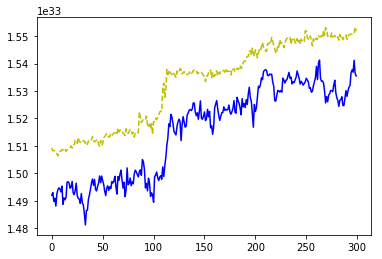

In [29]:
plt_score_max3 =  [max(plt_score3[i]) for i in range(len(plt_score3))]
plt_score_avg3  =  [sum(plt_score3[i])/len(plt_score3[i]) for i in range(len(plt_score3))]


plt.plot(plt_score_max3, 'y--')
plt.plot(plt_score_avg3,'b')

plt.show()


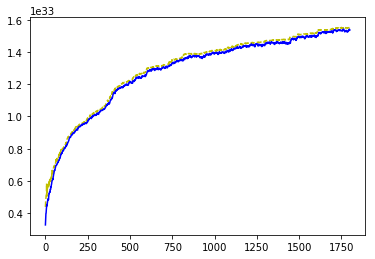

In [32]:
plt_score_all = plt_score + plt_score2 + plt_score3 

plt_score_max_all =  [max(plt_score_all[i]) for i in range(len(plt_score_all))]
plt_score_avg_all  =  [sum(plt_score_all[i])/len(plt_score_all[i]) for i in range(len(plt_score_all))]


plt.plot(plt_score_max_all, 'y--')
plt.plot(plt_score_avg_all,'b')

plt.show()


In [31]:
plt_score3 

[[1483913007887994877133713288281332,
  1507334498199938400049572150306497,
  1504874353322459733479622814462375,
  1504141040848671562547566306651281,
  1434979161285111743690531095057071,
  1500976232563698332657888763758397,
  1494743637813241994210101980692003,
  1509303994018892075731567152473428,
  1450015590088312594176448129755198,
  1503314198381888732928979179283809,
  1495088703370835912211522351010675,
  1488894916155653504911119387181312,
  1489127063032269965815283700684520,
  1503977871480613302073200912230100,
  1456021595736356883705781633219191,
  1504471280374535806412300634418932,
  1503623166670243425279916856262019,
  1499244909795976558109920595988185,
  1506231778688633309010003924820773,
  1489714688121096677278623320278533,
  1487132232625212649186842292801991,
  1457622910682757575007108495251421,
  1492846077692855331908281688844911,
  1479737895400874737334970878912568,
  1488298800929966567536366897708256,
  1501477658645080335110736824200765,
  1506246775

In [40]:
test_list3

[[[[1, 0, 1, 1, 1, 1, 0, 1],
   [1, 1, 1, 0, 0, 1, 1, 1],
   [0, 1, 1, 0, 1, 0, 0, 0],
   [1, 0, 0, 1, 0, 0, 1, 0],
   [0, 0, 1, 1, 1, 1, 1, 0],
   [1, 0, 1, 1, 0, 1, 1, 1],
   [0, 0, 1, 1, 1, 1, 1, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 1],
   [1, 0, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 1, 0, 1, 0]],
  [[1, 1, 0, 1, 0, 1, 1, 0],
   [1, 1, 0, 0, 0, 0, 1, 0],
   [0, 0, 0, 0, 1, 0, 1, 1],
   [1, 1, 1, 1, 1, 0, 1, 0],
   [1, 1, 1, 1, 0, 1, 1, 0],
   [0, 1, 1, 0, 1, 1, 1, 0],
   [0, 1, 1, 0, 0, 0, 1, 0],
   [0, 1, 0, 0, 1, 1, 1, 0],
   [1, 1, 1, 1, 1, 1, 0, 0],
   [0, 0, 1, 0, 1, 1, 1, 0],
   [1, 1, 1, 0, 1, 1, 1, 1]],
  [[0, 1, 0, 1, 1, 1, 0, 1],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0],
   [1, 0, 0, 1, 1, 1, 1, 1],
   [1, 1, 1, 0, 1, 1, 1, 0],
   [1, 1, 0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 1, 1, 0, 0],
   [0, 0, 0, 0, 0, 1, 0, 1],
   [1, 1, 1, 1, 1, 1, 1, 0],
   [1, 0, 1, 1, 1, 0, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0]],
  [[0, 0, 1, 0, 1, 1, 0, 0],
   [1, 1, 1

In [38]:
f = open("splist.txt", 'w')
data = ",".join(test_list3)
f.write(data)
f.close()

TypeError: sequence item 0: expected str instance, list found